In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import shap
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px

import catboost as cb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel

import optuna

import warnings
warnings.filterwarnings('ignore')

# NEE modelling

In [2]:
def plot_actual_vs_predicted(actual, predicted):
    """
    Plots the actual vs predicted values using Plotly.

    Parameters:
    actual (numpy.ndarray): Array of actual values.
    predicted (numpy.ndarray): Array of predicted values.
    """
    # Create the plot
    trace_actual = go.Scatter(
        x=np.arange(len(actual)),
        y=actual,
        mode='lines+markers',
        name='Actual'
    )

    trace_predicted = go.Scatter(
        x=np.arange(len(predicted)),
        y=predicted,
        mode='lines+markers',
        name='Predicted'
    )

    data = [trace_actual, trace_predicted]

    layout = go.Layout(
        title='Actual vs Predicted',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Value')
    )

    fig = go.Figure(data=data, layout=layout)

    # Plot the figure inline
    pio.renderers.default = 'notebook'  # Ensure the renderer is set to 'notebook' for inline plotting
    fig.show()

In [3]:
class DataPreprocessing:
    def __init__(self, forest_path, no_forest_path):
        self.df_forest = pd.read_csv(forest_path)
        self.df_no_forest = pd.read_csv(no_forest_path)
        self.df = None

    def load_and_clean_data(self):
        # Drop 'Unnamed: 0' column
        self.df_no_forest.drop('Unnamed: 0', axis=1, inplace=True)
        self.df_forest.drop('Unnamed: 0', axis=1, inplace=True)

        # Concatenate dataframes
        self.df = pd.concat([self.df_forest, self.df_no_forest])

        # Drop specific IGBP categories
        IGBP_drop = ['BSV', 'WSA', 'SAV']
        self.df = self.df[~self.df['IGBP'].isin(IGBP_drop)]

        # Drop specific stations (Chosen by visual analysis)
        valid_stations = [
        'US_Ne1', 'BE_Vie', 'CA_Ca1', 'CA_Gro', 'CA_LP1', 'CA_NS1', 'CA_NS2', 
        'CA_NS3', 'CA_NS5', 'CA_Oas', 'CA_Obs', 'CA_Qfo', 'CA_SF2', 'CA_TP2', 
        'CA_TP3', 'CA_TPD', 'CH_Dav', 'CH_Lae', 'CN_Cha', 'CN_Qia', 'CZ_BK1', 
        'DE_Hai', 'DE_Lnf', 'DE_Tha', 'DK_Sor', 'FI_Hyy', 'FI_Let', 'FI_Var', 
        'FR_Fon', 'FR_LBr', 'IT_CA1', 'IT_CA3', 'IT_Col', 'IT_Lav', 'IT_Ren', 
        'IT_Ro1', 'IT_Ro2', 'IT_SRo', 'JP_SMF', 'RU_Fyo', 'SE_Kno', 'SE_Nor', 
        'UK_Ham', 'US_Blo', 'US_CMW', 'US_GLE', 'US_Ha1', 'US_Me3', 'US_MMS', 
        'US_NR1', 'US_Oho', 'US_Prr', 'US_Rpf', 'US_Syv', 'US_Uaf', 'US_UMB', 
        'US_UMd', 'US_WCr', 'AT_Neu', 'AU_DaP', 'AU_Fog', 'AU_Rig', 'AU_Stp', 
        'AU_Whr', 'AU_Wom', 'BR_Sa1', 'CA_NS6', 'CA_NS7', 'CH_Aws', 'CH_Fru', 
        'CH_Oe1', 'CH_Oe2', 'CL_SDF', 'CN_Dan', 'CN_Din', 'CN_Ha2', 'CN_HaM', 
        'CN_Sw2', 'CZ_BK2', 'CZ_wet', 'DE_Geb', 'DE_Gri', 'DE_Kli', 'DE_RuR', 
        'DE_SfN', 'DE_Spw', 'DE_Zrk', 'DK_Eng', 'ES_Amo', 'ES_LgS', 'FI_Jok', 
        'FI_Kaa', 'FI_Lom', 'FR_LGt', 'FR_Pue', 'GF_Guy', 'GL_NuF', 'GL_ZaH', 
        'IT_CA2', 'IT_Cp2', 'IT_Cpz', 'IT_MBo', 'IT_Noe', 'NL_Ca1', 'PA_SPs', 
        'PT_Esp', 'RU_Ha1', 'RU_Sam', 'RU_Tks', 'SE_Deg', 'SJ_Adv', 'US_ARb', 
        'US_ARc', 'US_ARM', 'US_Atq', 'US_EML', 'US_Goo', 'US_IB2', 'US_Ivo', 
        'US_KFS', 'US_KLS', 'US_Kon', 'US_Los', 'US_Myb', 'US_Ne2', 'US_Ne3', 
        'US_SRG', 'US_Sta', 'US_Tw1', 'US_Twt', 'US_Var', 'US_Whs', 'US_Wi6', 
        'US_Wi7', 'US_WPT']
    
        self.df = self.df[self.df['station'].isin(valid_stations)]

    def drop_rows_with_value_counts(self, threshold=5):
        """
        Drop rows in a Pandas DataFrame where values in a specific column
        appear more than the specified threshold times.
        """
        for station in self.df['station'].unique():
            station_data = self.df[self.df['station'] == station]
            value_counts = station_data['NEE'].value_counts()
            values_to_remove = value_counts[value_counts > threshold].index.tolist()
            self.df = self.df[~self.df['NEE'].isin(values_to_remove)]
        self.df.reset_index(drop=True, inplace=True)

    def plot_all_stations(self, df):
        for category in df['station'].unique():
            station_data = df[df['station'] == category]
            biom = station_data['IGBP'].unique()
            print(f'{category}')
            print(biom)
            plt.plot(station_data['NEE'])
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.title(f'Station: {category}')
            plt.show()
            plt.close()

    def correlation(self, dataset, threshold):
        col_corr = set()  # Set of all the names of correlated columns
        corr_matrix = dataset.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    col_corr.add(colname)
        return col_corr

    def plot_correlation_heatmap(self):
        plt.figure(figsize=(20, 10))
        sns.heatmap(self.df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Heatmap of Columns')
        plt.show()

    def replace_outliers_with_nan_rolling_iqr(self, window_size=3, scale=1.5):
        new_df = self.df.copy()
        for station in tqdm(self.df['station'].unique()):
            station_data = self.df[self.df['station'] == station]
            for column_name in station_data.columns:
                if column_name not in ['Year','Month','lon','lat','station','IGBP'] and np.issubdtype(self.df[column_name].dtype, np.number):
                    rolling_q1 = self.df[column_name].rolling(window=window_size, center=True).quantile(0.35)
                    rolling_q3 = self.df[column_name].rolling(window=window_size, center=True).quantile(0.65)
                    rolling_iqr = rolling_q3 - rolling_q1
                    
                    lower_bound = rolling_q1 - (scale * rolling_iqr)
                    upper_bound = rolling_q3 + (scale * rolling_iqr)
                    
                    outliers = (self.df[column_name] < lower_bound) | (self.df[column_name] > upper_bound)
                    
                    new_df.loc[outliers, column_name] = np.nan
            self.df = new_df

    def mean_daily_data_by_month(self):
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        df_date = self.df['Date']
        category = self.df['station']
        self.df.set_index('Date', inplace=True)

        cleaned_df = pd.DataFrame()
        for station in self.df['station'].unique():
            # Select data for the current station
            station_data = self.df[self.df['station'] == station]
            numerical_columns = station_data.select_dtypes(include=['number']).columns
            categorical_columns = station_data.select_dtypes(exclude=['number']).columns

            # Extract year and month from the index
            station_data['Year'] = station_data.index.year
            station_data['Month'] = station_data.index.month

            # Create the aggregation dictionary
            agg_dict = {col: 'mean' for col in numerical_columns}
            agg_dict.update({col: 'first' for col in categorical_columns})

            # Group by year and month, and calculate the mean for numerical columns
            result_df = station_data.groupby(['Year', 'Month']).agg(agg_dict).reset_index()
            cleaned_df = pd.concat([cleaned_df, result_df])
        return cleaned_df, df_date, category


### Data preprocessing

In [4]:
data_preprocessing = DataPreprocessing(r'C:\Univercity\Skoltech\NEE_2.0\forest_meteo_gpp_nee_2024.csv', 
                                  r'C:\Univercity\Skoltech\NEE_2.0\NO_FOREST_meteo_gpp_nee_2024.csv')

In [5]:

data_preprocessing.load_and_clean_data()
data_preprocessing.drop_rows_with_value_counts()

corr_features = data_preprocessing.correlation(data_preprocessing.df.drop(['NEE', 'GPP'], axis=1), 0.6)
data_preprocessing.df.drop(corr_features, axis=1, inplace=True)

# # Create a heatmap of columns
# data_preprocessing.plot_correlation_heatmap()

In [6]:
cleaned_df, df_date, category = data_preprocessing.mean_daily_data_by_month()

In [7]:
cleaned_df = cleaned_df.interpolate()

### Data split experiments

#### Split by stations

In [8]:
stations = cleaned_df['station'].unique().tolist()

train_stations, test_stations = train_test_split(stations, test_size=0.2, random_state=1754)

train_data = cleaned_df[cleaned_df['station'].isin(train_stations)]
test_data = cleaned_df[cleaned_df['station'].isin(test_stations)]

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

len(train_stations), len(test_stations), len(stations)

(75, 19, 94)

In [9]:
features_to_drop = ['Year','station','IGBP','lon','lat', 'NEE']

X_train = train_data.drop(features_to_drop, axis=1)
y_train = train_data['NEE']

X_test = test_data.drop(features_to_drop, axis=1)
y_test = test_data['NEE']

In [10]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
# Train the model
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2.8389064583209778
R-squared: 0.4765001081796204


Conclusion: Split by stations is bad idea

#### Split without categorical feature

In [11]:
features_to_drop = ['Year','station','lon','lat', 'IGBP', 'NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Create Pool objects for training and testing
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
# Train the model
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 1.3782109660050463
R-squared: 0.6905718633477893


#### Split with categorical feature

In [13]:
features_to_drop = ['Year','station','lon','lat', 'NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the categorical features
categorical_features = ['IGBP']

# Create Pool objects for training and testing
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

In [14]:
# Initialize CatBoostRegressor
# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
# Train the model
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1.1800479511253765
R-squared: 0.7350623034618582


Conclusion: We need categorical feature of IGBP. Increase in results is 7.5%

#### With Data normalisation  

In [10]:
# Features to drop
features_to_drop = ['Year', 'station', 'lon', 'lat', 'NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Separate categorical and numerical features
X_train_num = X_train.drop(columns=categorical_features)
X_test_num = X_test.drop(columns=categorical_features)

# Fit the scaler on the numerical training data and transform both training and testing numerical data
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert scaled numerical data back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Concatenate scaled numerical data with categorical data
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[categorical_features]], axis=1)

# Create Pool objects for training and testing
train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test_scaled, label=y_test, cat_features=categorical_features)

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
# model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
# Train the model
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

0:	learn: 1.9555104	total: 144ms	remaining: 2m 23s
100:	learn: 1.0733141	total: 2.74s	remaining: 24.4s
200:	learn: 0.9289530	total: 5.3s	remaining: 21.1s
300:	learn: 0.8480585	total: 7.85s	remaining: 18.2s
400:	learn: 0.7802852	total: 10.4s	remaining: 15.5s
500:	learn: 0.7284650	total: 12.8s	remaining: 12.7s
600:	learn: 0.6843096	total: 15.2s	remaining: 10.1s
700:	learn: 0.6466472	total: 17.6s	remaining: 7.51s
800:	learn: 0.6114850	total: 20s	remaining: 4.96s
900:	learn: 0.5821064	total: 22.4s	remaining: 2.46s
999:	learn: 0.5557326	total: 24.8s	remaining: 0us
Mean Squared Error: 0.9944357260847003
R-squared: 0.7654501271874901


Conclusion: Normalization increased results

#### Split stratification

In [52]:
cleaned_df

Year  Month         lon        lat       NEE  ZENITH_LUMINANCE        PW  \
0    2015      1    5.998115  50.304933  0.560417       1373.511593  1.022681   
1    2015      2    5.998115  50.304933  0.087309       1996.284598  0.887556   
2    2015      3    5.998115  50.304933 -1.022810       3093.460433  1.028478   
3    2015      4    5.998115  50.304933 -1.972596       3805.751823  1.141146   
4    2015      5    5.998115  50.304933 -3.425770       6189.958165  1.615927   
..    ...    ...         ...        ...       ...               ...       ...   
123  2014      8 -109.941900  31.736500 -1.146656       6023.699597  3.040827   
124  2014      9 -109.941900  31.736500 -0.599934       4199.419792  2.995833   
125  2014     10 -109.941900  31.736500 -1.008089       2292.076361  1.431956   
126  2014     11 -109.941900  31.736500 -0.341344       2016.537240  0.887760   
127  2014     12 -109.941900  31.736500  0.090699       2554.175151  0.895161   

     CLRSKY_SRF_ALB  CLRSKY_SFC_SW_UP  CLRSKY_DAYS  ...       TROPT  \
0          0.195312         11.301411     0.000000  ...  213.978075   
1          0.181920         17.766183     0.000000  ...  215.865513   
2          0.175907         28.314264     0.032258  ...  216.485887   
3          0.183333         42.347396     0.166667  ...  212.416406   
4          0.199597         56.861895     0.000000  ...  217.459929   
..              ...               ...          ...  ...         ...   
123        0.175151         52.950857     0.193548  ...  201.481351   
124        0.166927         43.635937     0.300000  ...  198.589063   
125        1.763357         36.841482     0.709677  ...  202.542087   
126        0.177865         32.194531     0.666667  ...  209.788021   
127        0.169355         26.550403     0.354839  ...  212.232107   

               SLP      RHOA   PRECTOTCORR   PRECSNOLAND   GWETTOP    EVPTRNS  \
0    101536.903226  1.226783  4.076141e-05  1.666879e-05  0.842238   0.014617   
1    101648.683036  1.231097  2.207633e-05  1.043507e-05  0.865792   0.014509   
2    101993.897177  1.215726  2.311696e-05  7.756490e-07  0.862147   0.804183   
3    102103.962500  1.201074  2.202162e-05  9.800734e-07  0.831771  10.895573   
4    101618.957661  1.181987  1.698141e-05  0.000000e+00  0.771421  25.286542   
..             ...       ...           ...           ...       ...        ...   
123  101091.014113  1.001449  4.461318e-05  0.000000e+00  0.491179   4.712198   
124  100903.977083  1.003385  5.688115e-05  0.000000e+00  0.569271   7.085938   
125  101107.691532  1.016539  1.233009e-05  0.000000e+00  0.564516   6.082157   
126  101454.941667  1.044857  7.143884e-07  0.000000e+00  0.476562   1.064062   
127  101469.223790  1.054719  9.932232e-06  2.896413e-07  0.460938   0.358367   

            GPP  station  IGBP  
0      9.500000   BE_Vie    MF  
1     17.000000   BE_Vie    MF  
2    123.250000   BE_Vie    MF  
3    325.000000   BE_Vie    MF  
4    374.750000   BE_Vie    MF  
..          ...      ...   ...  
123  164.000000   US_Wkg   GRA  
124  193.000000   US_Wkg   GRA  
125  138.666667   US_Wkg   GRA  
126   87.750000   US_Wkg   GRA  
127   39.500000   US_Wkg   GRA  

[10418 rows x 28 columns]

In [42]:


features_to_drop = ['Year', 'station', 'lon', 'lat', 'NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

# Bin the target variable
num_bins = 5
y_binned = pd.cut(y, bins=num_bins, labels=False)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Separate categorical and numerical features
X_train_num = X_train.drop(columns=categorical_features)
X_test_num = X_test.drop(columns=categorical_features)

# Fit the scaler on the numerical training data and transform both training and testing numerical data
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert scaled numerical data back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Concatenate scaled numerical data with categorical data
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[categorical_features]], axis=1)

# Create Pool objects for training and testing
train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test_scaled, label=y_test, cat_features=categorical_features)

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

# Train the model
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

0:	learn: 2.0187545	total: 21.2ms	remaining: 21.2s
100:	learn: 1.1182914	total: 2.29s	remaining: 20.4s
200:	learn: 0.9470346	total: 6.29s	remaining: 25s
300:	learn: 0.8487521	total: 8.49s	remaining: 19.7s
400:	learn: 0.7798350	total: 10.7s	remaining: 16s
500:	learn: 0.7258187	total: 13s	remaining: 12.9s
600:	learn: 0.6808446	total: 15.1s	remaining: 10s
700:	learn: 0.6397813	total: 17.4s	remaining: 7.4s
800:	learn: 0.6028065	total: 19.6s	remaining: 4.87s
900:	learn: 0.5678433	total: 21.9s	remaining: 2.41s
999:	learn: 0.5392714	total: 24.3s	remaining: 0us
Mean Squared Error: 1.2414825740312094
R-squared: 0.7175674337088718


Conclusion: classical stratification doesnt increase results

Overall conclusion: Best results can be reached with using categorical feature of IGBP and normalization

### Cross-validation

#### Kfold 

In [84]:
# Features to drop
features_to_drop = ['Year', 'station', 'lon', 'lat', 'NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
mse_list = []
r2_list = []

# K-Fold Cross Validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Separate categorical and numerical features
    X_train_num = X_train.drop(columns=categorical_features)
    X_val_num = X_val.drop(columns=categorical_features)

    # Fit the scaler on the numerical training data and transform both training and validation numerical data
    X_train_num_scaled = scaler.fit_transform(X_train_num)
    X_val_num_scaled = scaler.transform(X_val_num)

    # Convert scaled numerical data back to DataFrame
    X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
    X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=X_val_num.columns, index=X_val_num.index)

    # Concatenate scaled numerical data with categorical data
    X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
    X_val_scaled = pd.concat([X_val_num_scaled_df, X_val[categorical_features]], axis=1)

    # Create Pool objects for training and validation
    train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
    val_pool = Pool(data=X_val_scaled, label=y_val, cat_features=categorical_features)

    # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

    # Train the model
    model.fit(train_pool)

    # Make predictions
    predictions = model.predict(val_pool)

    # Evaluate the model
    mse = mean_squared_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    mse_list.append(mse)
    r2_list.append(r2)

    print(f'Fold MSE: {mse}')
    print(f'Fold R-squared: {r2}')

# Compute average metrics
avg_mse = np.mean(mse_list)
avg_r2 = np.mean(r2_list)

print(f'Average Mean Squared Error: {avg_mse}')
print(f'Average R-squared: {avg_r2}')

0:	learn: 2.0156287	total: 19.2ms	remaining: 19.2s
100:	learn: 1.1183172	total: 2.29s	remaining: 20.4s
200:	learn: 0.9577946	total: 4.48s	remaining: 17.8s
300:	learn: 0.8627458	total: 6.62s	remaining: 15.4s
400:	learn: 0.7976427	total: 8.88s	remaining: 13.3s
500:	learn: 0.7406324	total: 11.4s	remaining: 11.3s
600:	learn: 0.6907816	total: 13.9s	remaining: 9.22s
700:	learn: 0.6485593	total: 16.4s	remaining: 6.98s
800:	learn: 0.6123168	total: 19s	remaining: 4.71s
900:	learn: 0.5778728	total: 21.5s	remaining: 2.36s
999:	learn: 0.5485065	total: 23.9s	remaining: 0us
Fold MSE: 1.191736050688036
Fold R-squared: 0.732438157407381
0:	learn: 2.0261169	total: 19.8ms	remaining: 19.8s
100:	learn: 1.1199934	total: 2.35s	remaining: 20.9s
200:	learn: 0.9631676	total: 4.7s	remaining: 18.7s
300:	learn: 0.8665442	total: 6.83s	remaining: 15.9s
400:	learn: 0.7919814	total: 9.13s	remaining: 13.6s
500:	learn: 0.7338199	total: 11.3s	remaining: 11.2s
600:	learn: 0.6861530	total: 13.6s	remaining: 9.05s
700:	lear

#### TimeSeriesSplit

In [89]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Features to drop
features_to_drop = ['Year', 'station', 'lon', 'lat', 'NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store evaluation metrics for each fold
mse_list = []
r2_list = []

# TimeSeriesSplit Cross Validation
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Separate categorical and numerical features
    X_train_num = X_train.drop(columns=categorical_features)
    X_val_num = X_val.drop(columns=categorical_features)

    # Fit the scaler on the numerical training data and transform both training and validation numerical data
    X_train_num_scaled = scaler.fit_transform(X_train_num)
    X_val_num_scaled = scaler.transform(X_val_num)

    # Convert scaled numerical data back to DataFrame
    X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
    X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=X_val_num.columns, index=X_val_num.index)

    # Concatenate scaled numerical data with categorical data
    X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
    X_val_scaled = pd.concat([X_val_num_scaled_df, X_val[categorical_features]], axis=1)

    # Create Pool objects for training and validation
    train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
    val_pool = Pool(data=X_val_scaled, label=y_val, cat_features=categorical_features)

    # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

    # Train the model
    model.fit(train_pool)

    # Make predictions
    predictions = model.predict(val_pool)

    # Evaluate the model
    mse = mean_squared_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    mse_list.append(mse)
    r2_list.append(r2)

    print(f'Fold MSE: {mse}')
    print(f'Fold R-squared: {r2}')

# Compute average metrics
avg_mse = np.mean(mse_list)
avg_r2 = np.mean(r2_list)

print(f'Average Mean Squared Error: {avg_mse}')
print(f'Average R-squared: {avg_r2}')

0:	learn: 1.6033751	total: 18.2ms	remaining: 18.2s
100:	learn: 0.6834308	total: 2.02s	remaining: 18s
200:	learn: 0.5225607	total: 4s	remaining: 15.9s
300:	learn: 0.4182694	total: 6s	remaining: 13.9s
400:	learn: 0.3369176	total: 7.98s	remaining: 11.9s
500:	learn: 0.2740694	total: 9.9s	remaining: 9.86s
600:	learn: 0.2291377	total: 11.8s	remaining: 7.85s
700:	learn: 0.1903347	total: 13.7s	remaining: 5.85s
800:	learn: 0.1638207	total: 15.6s	remaining: 3.88s
900:	learn: 0.1395039	total: 17.5s	remaining: 1.93s
999:	learn: 0.1206533	total: 19.4s	remaining: 0us
Fold MSE: 5.645567490349503
Fold R-squared: 0.28337915857979334
0:	learn: 2.2709703	total: 18.2ms	remaining: 18.2s
100:	learn: 0.8765139	total: 1.99s	remaining: 17.7s
200:	learn: 0.6920736	total: 4.04s	remaining: 16.1s
300:	learn: 0.5914957	total: 6.05s	remaining: 14s
400:	learn: 0.5172714	total: 8.03s	remaining: 12s
500:	learn: 0.4567216	total: 9.99s	remaining: 9.95s
600:	learn: 0.4089779	total: 12s	remaining: 7.95s
700:	learn: 0.36904

### Hyperparameter Tuning with Optuna

In [44]:
# Features to drop
features_to_drop = ['NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Separate categorical and numerical features
X_train_num = X_train.drop(columns=categorical_features)
X_test_num = X_test.drop(columns=categorical_features)

# Fit the scaler on the numerical training data and transform both training and testing numerical data
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert scaled numerical data back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Concatenate scaled numerical data with categorical data
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[categorical_features]], axis=1)

# Create Pool objects for training and testing
train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test_scaled, label=y_test, cat_features=categorical_features)


In [50]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        "objective": "RMSE",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 12),
        "bagging_temperature": trial.suggest_categorical("bagging_temperature", [0.5, 1, 1.5, 2]),
        "border_count": trial.suggest_categorical("border_count", [16, 32, 64, 128]),
        "iterations": trial.suggest_categorical("iterations", [ 600, 800, 1000, 1200, 1600, 2000,2200,2500]),
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE", "Quantile", "Huber", "Fair", "Poisson", "MAPE", "Lq"]),
        "used_ram_limit": "3gb",
    }

    CatBoost_model = CatBoostRegressor(**param, logging_level='Silent')

    CatBoost_model.fit(train_pool, eval_set=test_pool, verbose=0, early_stopping_rounds=100)

    preds = CatBoost_model.predict(test_pool)
    r2 = r2_score(y_test, preds)
    return r2

# Create a study object and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))



[I 2024-06-16 22:12:14,401] A new study created in memory with name: no-name-ce00fdd7-74ca-4bca-a131-63977e8b09de
[I 2024-06-16 22:12:45,366] Trial 0 finished with value: 0.7712511854572447 and parameters: {'learning_rate': 0.08476467526389972, 'depth': 8, 'l2_leaf_reg': 10, 'bagging_temperature': 2, 'border_count': 128, 'iterations': 1600, 'loss_function': 'Lq'}. Best is trial 0 with value: 0.7712511854572447.
[I 2024-06-16 22:13:54,999] Trial 1 finished with value: 0.7732100315286566 and parameters: {'learning_rate': 0.0306010393534037, 'depth': 10, 'l2_leaf_reg': 7, 'bagging_temperature': 1, 'border_count': 128, 'iterations': 1200, 'loss_function': 'Fair'}. Best is trial 1 with value: 0.7732100315286566.
[I 2024-06-16 22:14:00,811] Trial 2 finished with value: 0.5427995607873235 and parameters: {'learning_rate': 0.013960636180201762, 'depth': 2, 'l2_leaf_reg': 10, 'bagging_temperature': 0.5, 'border_count': 32, 'iterations': 600, 'loss_function': 'MAPE'}. Best is trial 1 with value:

Number of finished trials: 14


In [51]:
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.7743289689156754
  Params: 
    learning_rate: 0.060091632135724334
    depth: 10
    l2_leaf_reg: 10
    bagging_temperature: 0.5
    border_count: 128
    iterations: 1000
    loss_function: Poisson


In [25]:
# Train the final model with the best parameters
best_params = trial.params
best_model = CatBoostRegressor(**best_params, logging_level='Silent')
best_model.fit(train_pool)

# Make predictions
predictions = best_model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1.1397375622568962
R-squared: 0.7441125641425254


### Choosing of valid FLUXNET stations

In [7]:
def load_and_clean_data_all_stations(self):
    # Drop 'Unnamed: 0' column
    self.df_no_forest.drop('Unnamed: 0', axis=1, inplace=True)
    self.df_forest.drop('Unnamed: 0', axis=1, inplace=True)

    # Concatenate dataframes
    self.df = pd.concat([self.df_forest, self.df_no_forest])

    # Drop specific IGBP categories
    IGBP_drop = ['BSV', 'WSA', 'SAV']
    self.df = self.df[~self.df['IGBP'].isin(IGBP_drop)]

# Add the new function to the class
DataPreprocessing.load_and_clean_data_all_stations = load_and_clean_data_all_stations

In [8]:
data_preprocessing = DataPreprocessing(r'C:\Univercity\Skoltech\NEE_2.0\forest_meteo_gpp_nee_2024.csv', 
                                  r'C:\Univercity\Skoltech\NEE_2.0\NO_FOREST_meteo_gpp_nee_2024.csv')

In [7]:
data_preprocessing.load_and_clean_data_all_stations()
data_preprocessing.drop_rows_with_value_counts()

corr_features = data_preprocessing.correlation(data_preprocessing.df.drop(['NEE', 'GPP'], axis=1), 0.6)
data_preprocessing.df.drop(corr_features, axis=1, inplace=True)

In [8]:
cleaned_df, df_date, category = data_preprocessing.mean_daily_data_by_month()

In [11]:
cleaned_df = cleaned_df.interpolate()

In [12]:
# Features to drop
features_to_drop = ['Year', 'station', 'lon', 'lat', 'NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Separate categorical and numerical features
X_train_num = X_train.drop(columns=categorical_features)
X_test_num = X_test.drop(columns=categorical_features)

# Fit the scaler on the numerical training data and transform both training and testing numerical data
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert scaled numerical data back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Concatenate scaled numerical data with categorical data
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[categorical_features]], axis=1)

# Create Pool objects for training and testing
train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test_scaled, label=y_test, cat_features=categorical_features)

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
# model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
# Train the model
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

0:	learn: 10.6182411	total: 167ms	remaining: 2m 46s
100:	learn: 3.5981112	total: 2.72s	remaining: 24.2s
200:	learn: 2.1984908	total: 5.16s	remaining: 20.5s
300:	learn: 1.6804988	total: 7.86s	remaining: 18.3s
400:	learn: 1.4416652	total: 10.4s	remaining: 15.6s
500:	learn: 1.3123260	total: 13.1s	remaining: 13.1s
600:	learn: 1.2149314	total: 15.5s	remaining: 10.3s
700:	learn: 1.1461804	total: 17.9s	remaining: 7.63s
800:	learn: 1.0760185	total: 20.3s	remaining: 5.03s
900:	learn: 1.0225910	total: 22.8s	remaining: 2.51s
999:	learn: 0.9772633	total: 25.1s	remaining: 0us
Mean Squared Error: 5.476002032909952
R-squared: -0.25735758150836574


In [15]:
plot_actual_vs_predicted(y_test, predictions)

Conclusion: we cant use all the FLUXNET stations

#### Leave FLUXNET station name in dataset to find what stations contribute the most

In [9]:
data_preprocessing = DataPreprocessing(r'C:\Univercity\Skoltech\NEE_2.0\forest_meteo_gpp_nee_2024.csv', 
                                  r'C:\Univercity\Skoltech\NEE_2.0\NO_FOREST_meteo_gpp_nee_2024.csv')

data_preprocessing.load_and_clean_data_all_stations()
data_preprocessing.drop_rows_with_value_counts()

corr_features = data_preprocessing.correlation(data_preprocessing.df.drop(['NEE', 'GPP'], axis=1), 0.6)
data_preprocessing.df.drop(corr_features, axis=1, inplace=True)

cleaned_df, df_date, category = data_preprocessing.mean_daily_data_by_month()
cleaned_df = cleaned_df.interpolate()

In [10]:
def evaluate_station(station_data):
    # Features to drop
    features_to_drop = ['Year', 'station', 'lon', 'lat', 'NEE']
    X = station_data.drop(features_to_drop, axis=1)
    y = station_data['NEE']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Specify the categorical features
    categorical_features = ['IGBP']

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Separate categorical and numerical features
    X_train_num = X_train.drop(columns=categorical_features)
    X_test_num = X_test.drop(columns=categorical_features)

    # Fit the scaler on the numerical training data and transform both training and testing numerical data
    X_train_num_scaled = scaler.fit_transform(X_train_num)
    X_test_num_scaled = scaler.transform(X_test_num)

    # Convert scaled numerical data back to DataFrame
    X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
    X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

    # Concatenate scaled numerical data with categorical data
    X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
    X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[categorical_features]], axis=1)

    # Create Pool objects for training and testing
    train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
    test_pool = Pool(data=X_test_scaled, label=y_test, cat_features=categorical_features)

    # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
    # model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
    # Train the model
    model.fit(train_pool)

    # Make predictions
    predictions = model.predict(test_pool)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')
    
    return mse, r2

In [26]:
results = {}
stations = cleaned_df['station'].unique()

for station in tqdm(stations):
    station_data = cleaned_df[cleaned_df['station'] == station]
    print(f"Evaluating station: {station}")
    mse, r2 = evaluate_station(station_data)
    print(f"Mean Squared Error for {station}: {mse}")
    print(f"R-squared for {station}: {r2}")
    results[station] = {'mse': mse, 'r2': r2}

  0%|          | 0/198 [00:00<?, ?it/s]

Evaluating station: BE_Vie
0:	learn: 1.7857789	total: 1.3ms	remaining: 1.3s
100:	learn: 0.0721557	total: 129ms	remaining: 1.15s
200:	learn: 0.0075285	total: 213ms	remaining: 845ms
300:	learn: 0.0011968	total: 288ms	remaining: 668ms
400:	learn: 0.0001743	total: 368ms	remaining: 550ms
500:	learn: 0.0000247	total: 442ms	remaining: 441ms
600:	learn: 0.0000039	total: 519ms	remaining: 344ms
700:	learn: 0.0000005	total: 594ms	remaining: 253ms
800:	learn: 0.0000001	total: 666ms	remaining: 165ms
900:	learn: 0.0000000	total: 740ms	remaining: 81.3ms
999:	learn: 0.0000000	total: 813ms	remaining: 0us
Mean Squared Error: 1.1997558728949176
R-squared: 0.7763993791445759
Mean Squared Error for BE_Vie: 1.1997558728949176
R-squared for BE_Vie: 0.7763993791445759


  1%|          | 1/198 [00:00<03:05,  1.06it/s]

Evaluating station: CA_Ca1
0:	learn: 1.1485565	total: 2.59ms	remaining: 2.59s
100:	learn: 0.1278312	total: 125ms	remaining: 1.11s
200:	learn: 0.0339357	total: 243ms	remaining: 966ms
300:	learn: 0.0085856	total: 359ms	remaining: 833ms
400:	learn: 0.0024004	total: 477ms	remaining: 713ms
500:	learn: 0.0006978	total: 593ms	remaining: 590ms
600:	learn: 0.0001931	total: 713ms	remaining: 473ms
700:	learn: 0.0000529	total: 827ms	remaining: 353ms
800:	learn: 0.0000152	total: 935ms	remaining: 232ms
900:	learn: 0.0000046	total: 1.04s	remaining: 114ms


  1%|          | 2/198 [00:02<03:43,  1.14s/it]

999:	learn: 0.0000014	total: 1.15s	remaining: 0us
Mean Squared Error: 0.4715024202382048
R-squared: 0.7006624876959395
Mean Squared Error for CA_Ca1: 0.4715024202382048
R-squared for CA_Ca1: 0.7006624876959395
Evaluating station: CA_Ca2
0:	learn: 0.7396719	total: 2.48ms	remaining: 2.48s
100:	learn: 0.1196928	total: 121ms	remaining: 1.07s
200:	learn: 0.0320646	total: 234ms	remaining: 930ms
300:	learn: 0.0089322	total: 342ms	remaining: 794ms
400:	learn: 0.0021350	total: 474ms	remaining: 708ms
500:	learn: 0.0005597	total: 596ms	remaining: 594ms
600:	learn: 0.0001534	total: 711ms	remaining: 472ms
700:	learn: 0.0000413	total: 826ms	remaining: 352ms
800:	learn: 0.0000111	total: 940ms	remaining: 234ms
900:	learn: 0.0000034	total: 1.05s	remaining: 115ms


  2%|▏         | 3/198 [00:03<03:55,  1.21s/it]

999:	learn: 0.0000009	total: 1.16s	remaining: 0us
Mean Squared Error: 0.5709672122345507
R-squared: 0.26337024373648954
Mean Squared Error for CA_Ca2: 0.5709672122345507
R-squared for CA_Ca2: 0.26337024373648954
Evaluating station: CA_Ca3
0:	learn: 1.1383177	total: 2.85ms	remaining: 2.85s
100:	learn: 0.4833301	total: 188ms	remaining: 1.68s
200:	learn: 0.2105909	total: 358ms	remaining: 1.42s
300:	learn: 0.1012858	total: 566ms	remaining: 1.31s
400:	learn: 0.0476968	total: 753ms	remaining: 1.13s
500:	learn: 0.0207165	total: 956ms	remaining: 952ms
600:	learn: 0.0098844	total: 1.16s	remaining: 770ms
700:	learn: 0.0044651	total: 1.36s	remaining: 581ms
800:	learn: 0.0020896	total: 1.55s	remaining: 385ms
900:	learn: 0.0010615	total: 1.8s	remaining: 197ms
999:	learn: 0.0005043	total: 1.98s	remaining: 0us


  2%|▏         | 4/198 [00:05<05:03,  1.56s/it]

Mean Squared Error: 1.4881951727599987
R-squared: -0.05933101152743836
Mean Squared Error for CA_Ca3: 1.4881951727599987
R-squared for CA_Ca3: -0.05933101152743836
Evaluating station: CA_Gro
0:	learn: 1.0643897	total: 1.84ms	remaining: 1.84s
100:	learn: 0.0944164	total: 106ms	remaining: 939ms
200:	learn: 0.0188268	total: 214ms	remaining: 851ms
300:	learn: 0.0052952	total: 328ms	remaining: 761ms
400:	learn: 0.0015010	total: 443ms	remaining: 661ms
500:	learn: 0.0004804	total: 548ms	remaining: 546ms
600:	learn: 0.0001540	total: 657ms	remaining: 436ms
700:	learn: 0.0000454	total: 786ms	remaining: 335ms
800:	learn: 0.0000138	total: 911ms	remaining: 226ms
900:	learn: 0.0000041	total: 1.04s	remaining: 114ms


  3%|▎         | 5/198 [00:06<04:44,  1.47s/it]

999:	learn: 0.0000012	total: 1.17s	remaining: 0us
Mean Squared Error: 0.5283481553300127
R-squared: 0.6855438531119136
Mean Squared Error for CA_Gro: 0.5283481553300127
R-squared for CA_Gro: 0.6855438531119136
Evaluating station: CA_LP1
0:	learn: 0.8412801	total: 2.67ms	remaining: 2.67s
100:	learn: 0.1123812	total: 169ms	remaining: 1.5s
200:	learn: 0.0350207	total: 332ms	remaining: 1.32s
300:	learn: 0.0125318	total: 498ms	remaining: 1.16s
400:	learn: 0.0052954	total: 663ms	remaining: 991ms
500:	learn: 0.0022731	total: 865ms	remaining: 862ms
600:	learn: 0.0009598	total: 1.03s	remaining: 683ms
700:	learn: 0.0004057	total: 1.19s	remaining: 509ms
800:	learn: 0.0001600	total: 1.39s	remaining: 345ms


  3%|▎         | 6/198 [00:08<05:10,  1.62s/it]

900:	learn: 0.0000656	total: 1.6s	remaining: 175ms
999:	learn: 0.0000229	total: 1.74s	remaining: 0us
Mean Squared Error: 0.32316577993137574
R-squared: 0.4593027177740341
Mean Squared Error for CA_LP1: 0.32316577993137574
R-squared for CA_LP1: 0.4593027177740341
Evaluating station: CA_NS1
0:	learn: 0.9463681	total: 517us	remaining: 517ms
100:	learn: 0.0535703	total: 65.5ms	remaining: 583ms
200:	learn: 0.0041461	total: 121ms	remaining: 481ms
300:	learn: 0.0003736	total: 188ms	remaining: 437ms
400:	learn: 0.0000308	total: 271ms	remaining: 405ms
500:	learn: 0.0000018	total: 373ms	remaining: 371ms
600:	learn: 0.0000001	total: 442ms	remaining: 294ms
700:	learn: 0.0000000	total: 564ms	remaining: 241ms


  4%|▎         | 7/198 [00:09<04:24,  1.38s/it]

800:	learn: 0.0000000	total: 636ms	remaining: 158ms
900:	learn: 0.0000000	total: 709ms	remaining: 77.9ms
999:	learn: 0.0000000	total: 775ms	remaining: 0us
Mean Squared Error: 0.3013493341222805
R-squared: 0.7086242682465438
Mean Squared Error for CA_NS1: 0.3013493341222805
R-squared for CA_NS1: 0.7086242682465438
Evaluating station: CA_NS2
0:	learn: 0.9387507	total: 1.11ms	remaining: 1.11s
100:	learn: 0.0466042	total: 77.5ms	remaining: 690ms
200:	learn: 0.0039041	total: 151ms	remaining: 599ms
300:	learn: 0.0005248	total: 216ms	remaining: 502ms
400:	learn: 0.0000538	total: 296ms	remaining: 443ms
500:	learn: 0.0000055	total: 375ms	remaining: 373ms
600:	learn: 0.0000006	total: 447ms	remaining: 297ms
700:	learn: 0.0000001	total: 508ms	remaining: 217ms
800:	learn: 0.0000000	total: 567ms	remaining: 141ms


  4%|▍         | 8/198 [00:10<03:50,  1.22s/it]

900:	learn: 0.0000000	total: 650ms	remaining: 71.4ms
999:	learn: 0.0000000	total: 722ms	remaining: 0us
Mean Squared Error: 0.08242646236238368
R-squared: 0.851768510133345
Mean Squared Error for CA_NS2: 0.08242646236238368
R-squared for CA_NS2: 0.851768510133345
Evaluating station: CA_NS3
0:	learn: 0.8152955	total: 1.08ms	remaining: 1.08s
100:	learn: 0.0344396	total: 78.9ms	remaining: 702ms
200:	learn: 0.0026932	total: 144ms	remaining: 571ms
300:	learn: 0.0002412	total: 206ms	remaining: 479ms
400:	learn: 0.0000322	total: 269ms	remaining: 401ms
500:	learn: 0.0000035	total: 327ms	remaining: 326ms
600:	learn: 0.0000005	total: 388ms	remaining: 257ms
700:	learn: 0.0000001	total: 451ms	remaining: 192ms


  5%|▍         | 9/198 [00:11<03:22,  1.07s/it]

800:	learn: 0.0000000	total: 520ms	remaining: 129ms
900:	learn: 0.0000000	total: 581ms	remaining: 63.8ms
999:	learn: 0.0000000	total: 640ms	remaining: 0us
Mean Squared Error: 0.2369444406444243
R-squared: 0.4249455537904594
Mean Squared Error for CA_NS3: 0.2369444406444243
R-squared for CA_NS3: 0.4249455537904594
Evaluating station: CA_NS4
0:	learn: 0.5299159	total: 1.15ms	remaining: 1.15s
100:	learn: 0.0199266	total: 70.1ms	remaining: 624ms
200:	learn: 0.0011851	total: 127ms	remaining: 505ms
300:	learn: 0.0000935	total: 183ms	remaining: 424ms
400:	learn: 0.0000067	total: 238ms	remaining: 355ms
500:	learn: 0.0000005	total: 294ms	remaining: 293ms
600:	learn: 0.0000000	total: 348ms	remaining: 231ms
700:	learn: 0.0000000	total: 403ms	remaining: 172ms
800:	learn: 0.0000000	total: 462ms	remaining: 115ms


  5%|▌         | 10/198 [00:12<02:59,  1.05it/s]

900:	learn: 0.0000000	total: 518ms	remaining: 56.9ms
999:	learn: 0.0000000	total: 573ms	remaining: 0us
Mean Squared Error: 0.04208244879842595
R-squared: -0.3334049427369219
Mean Squared Error for CA_NS4: 0.04208244879842595
R-squared for CA_NS4: -0.3334049427369219
Evaluating station: CA_NS5
0:	learn: 0.9122589	total: 1.33ms	remaining: 1.33s
100:	learn: 0.0306247	total: 72.9ms	remaining: 648ms
200:	learn: 0.0027448	total: 139ms	remaining: 553ms
300:	learn: 0.0002990	total: 202ms	remaining: 469ms
400:	learn: 0.0000572	total: 266ms	remaining: 398ms
500:	learn: 0.0000093	total: 329ms	remaining: 328ms
600:	learn: 0.0000017	total: 393ms	remaining: 261ms
700:	learn: 0.0000002	total: 453ms	remaining: 193ms


  6%|▌         | 11/198 [00:12<02:46,  1.12it/s]

800:	learn: 0.0000000	total: 513ms	remaining: 127ms
900:	learn: 0.0000000	total: 573ms	remaining: 63ms
999:	learn: 0.0000000	total: 640ms	remaining: 0us
Mean Squared Error: 0.144061409988034
R-squared: 0.8479668383450353
Mean Squared Error for CA_NS5: 0.144061409988034
R-squared for CA_NS5: 0.8479668383450353
Evaluating station: CA_Oas
0:	learn: 1.9193246	total: 2.28ms	remaining: 2.28s
100:	learn: 0.1220069	total: 110ms	remaining: 982ms
200:	learn: 0.0264668	total: 221ms	remaining: 879ms
300:	learn: 0.0067323	total: 340ms	remaining: 789ms
400:	learn: 0.0015656	total: 516ms	remaining: 770ms
500:	learn: 0.0004329	total: 618ms	remaining: 616ms
600:	learn: 0.0001215	total: 719ms	remaining: 478ms
700:	learn: 0.0000353	total: 821ms	remaining: 350ms
800:	learn: 0.0000101	total: 925ms	remaining: 230ms


  6%|▌         | 12/198 [00:14<03:06,  1.00s/it]

900:	learn: 0.0000027	total: 1.03s	remaining: 114ms
999:	learn: 0.0000008	total: 1.13s	remaining: 0us
Mean Squared Error: 0.43023897724678123
R-squared: 0.8924493861796636
Mean Squared Error for CA_Oas: 0.43023897724678123
R-squared for CA_Oas: 0.8924493861796636
Evaluating station: CA_Obs
0:	learn: 0.6713068	total: 2.31ms	remaining: 2.31s
100:	learn: 0.0481018	total: 117ms	remaining: 1.04s
200:	learn: 0.0089229	total: 222ms	remaining: 881ms
300:	learn: 0.0019267	total: 325ms	remaining: 754ms
400:	learn: 0.0004865	total: 425ms	remaining: 634ms
500:	learn: 0.0001421	total: 526ms	remaining: 524ms
600:	learn: 0.0000427	total: 625ms	remaining: 415ms
700:	learn: 0.0000132	total: 725ms	remaining: 309ms
800:	learn: 0.0000036	total: 840ms	remaining: 209ms


  7%|▋         | 13/198 [00:15<03:18,  1.07s/it]

900:	learn: 0.0000011	total: 978ms	remaining: 107ms
999:	learn: 0.0000003	total: 1.11s	remaining: 0us
Mean Squared Error: 0.07826647281567567
R-squared: 0.870858388585902
Mean Squared Error for CA_Obs: 0.07826647281567567
R-squared for CA_Obs: 0.870858388585902
Evaluating station: CA_Qfo
0:	learn: 0.5594828	total: 1.55ms	remaining: 1.54s
100:	learn: 0.0262298	total: 118ms	remaining: 1.05s
200:	learn: 0.0033648	total: 233ms	remaining: 928ms
300:	learn: 0.0005733	total: 340ms	remaining: 789ms
400:	learn: 0.0001121	total: 448ms	remaining: 669ms
500:	learn: 0.0000234	total: 542ms	remaining: 540ms
600:	learn: 0.0000051	total: 649ms	remaining: 431ms
700:	learn: 0.0000012	total: 751ms	remaining: 321ms
800:	learn: 0.0000002	total: 849ms	remaining: 211ms
900:	learn: 0.0000001	total: 942ms	remaining: 103ms


  7%|▋         | 14/198 [00:16<03:25,  1.12s/it]

999:	learn: 0.0000000	total: 1.07s	remaining: 0us
Mean Squared Error: 0.2066730189263088
R-squared: 0.6520643145064557
Mean Squared Error for CA_Qfo: 0.2066730189263088
R-squared for CA_Qfo: 0.6520643145064557
Evaluating station: CA_SF1
0:	learn: 1.3228111	total: 1.19ms	remaining: 1.19s
100:	learn: 0.0791292	total: 61.3ms	remaining: 546ms
200:	learn: 0.0065848	total: 115ms	remaining: 456ms
300:	learn: 0.0005318	total: 169ms	remaining: 393ms
400:	learn: 0.0000404	total: 221ms	remaining: 331ms
500:	learn: 0.0000033	total: 273ms	remaining: 272ms
600:	learn: 0.0000003	total: 326ms	remaining: 217ms
700:	learn: 0.0000000	total: 388ms	remaining: 165ms
800:	learn: 0.0000000	total: 450ms	remaining: 112ms
900:	learn: 0.0000000	total: 508ms	remaining: 55.9ms
999:	learn: 0.0000000	total: 563ms	remaining: 0us


  8%|▊         | 15/198 [00:17<02:59,  1.02it/s]

Mean Squared Error: 4.486380200636763
R-squared: -0.2095516400610078
Mean Squared Error for CA_SF1: 4.486380200636763
R-squared for CA_SF1: -0.2095516400610078
Evaluating station: CA_SF2
0:	learn: 1.3415582	total: 1.42ms	remaining: 1.42s
100:	learn: 0.0981803	total: 69ms	remaining: 614ms
200:	learn: 0.0082203	total: 130ms	remaining: 515ms
300:	learn: 0.0007228	total: 193ms	remaining: 447ms
400:	learn: 0.0000583	total: 251ms	remaining: 374ms
500:	learn: 0.0000045	total: 307ms	remaining: 306ms
600:	learn: 0.0000004	total: 364ms	remaining: 241ms
700:	learn: 0.0000000	total: 422ms	remaining: 180ms
800:	learn: 0.0000000	total: 481ms	remaining: 120ms
900:	learn: 0.0000000	total: 538ms	remaining: 59.1ms
999:	learn: 0.0000000	total: 594ms	remaining: 0us


  8%|▊         | 16/198 [00:17<02:42,  1.12it/s]

Mean Squared Error: 0.5939116764943406
R-squared: 0.663176329987171
Mean Squared Error for CA_SF2: 0.5939116764943406
R-squared for CA_SF2: 0.663176329987171
Evaluating station: CA_TP2
0:	learn: 2.2739184	total: 1.01ms	remaining: 1.01s
100:	learn: 0.1990265	total: 73.5ms	remaining: 654ms
200:	learn: 0.0175479	total: 163ms	remaining: 649ms
300:	learn: 0.0017850	total: 262ms	remaining: 608ms
400:	learn: 0.0002622	total: 352ms	remaining: 526ms
500:	learn: 0.0000377	total: 430ms	remaining: 429ms
600:	learn: 0.0000058	total: 497ms	remaining: 330ms
700:	learn: 0.0000007	total: 564ms	remaining: 241ms


  9%|▊         | 17/198 [00:18<02:41,  1.12it/s]

800:	learn: 0.0000001	total: 631ms	remaining: 157ms
900:	learn: 0.0000000	total: 699ms	remaining: 76.8ms
999:	learn: 0.0000000	total: 772ms	remaining: 0us
Mean Squared Error: 2.5008162098722337
R-squared: 0.5155657443178103
Mean Squared Error for CA_TP2: 2.5008162098722337
R-squared for CA_TP2: 0.5155657443178103
Evaluating station: CA_TP3
0:	learn: 1.2034881	total: 1.05ms	remaining: 1.05s
100:	learn: 0.0593447	total: 64.5ms	remaining: 574ms
200:	learn: 0.0048830	total: 120ms	remaining: 476ms
300:	learn: 0.0004650	total: 177ms	remaining: 410ms
400:	learn: 0.0000403	total: 296ms	remaining: 443ms
500:	learn: 0.0000033	total: 353ms	remaining: 351ms
600:	learn: 0.0000002	total: 408ms	remaining: 271ms
700:	learn: 0.0000000	total: 461ms	remaining: 197ms


  9%|▉         | 18/198 [00:19<02:33,  1.17it/s]

800:	learn: 0.0000000	total: 515ms	remaining: 128ms
900:	learn: 0.0000000	total: 569ms	remaining: 62.5ms
999:	learn: 0.0000000	total: 642ms	remaining: 0us
Mean Squared Error: 0.5059054150330908
R-squared: 0.7331282217856779
Mean Squared Error for CA_TP3: 0.5059054150330908
R-squared for CA_TP3: 0.7331282217856779
Evaluating station: CA_TPD
0:	learn: 2.0706845	total: 1.09ms	remaining: 1.09s
100:	learn: 0.0458941	total: 73.3ms	remaining: 652ms
200:	learn: 0.0029314	total: 137ms	remaining: 545ms
300:	learn: 0.0001556	total: 196ms	remaining: 456ms
400:	learn: 0.0000108	total: 252ms	remaining: 376ms
500:	learn: 0.0000008	total: 324ms	remaining: 323ms
600:	learn: 0.0000001	total: 414ms	remaining: 275ms
700:	learn: 0.0000000	total: 480ms	remaining: 205ms
800:	learn: 0.0000000	total: 533ms	remaining: 132ms
900:	learn: 0.0000000	total: 587ms	remaining: 64.5ms


 10%|▉         | 19/198 [00:20<02:27,  1.21it/s]

999:	learn: 0.0000000	total: 641ms	remaining: 0us
Mean Squared Error: 0.9266129607257887
R-squared: 0.8540850001926746
Mean Squared Error for CA_TPD: 0.9266129607257887
R-squared for CA_TPD: 0.8540850001926746
Evaluating station: CH_Dav
0:	learn: 1.4380353	total: 3.32ms	remaining: 3.32s
100:	learn: 0.2536212	total: 143ms	remaining: 1.27s
200:	learn: 0.0710434	total: 273ms	remaining: 1.08s
300:	learn: 0.0221673	total: 401ms	remaining: 931ms
400:	learn: 0.0074419	total: 529ms	remaining: 790ms
500:	learn: 0.0025604	total: 658ms	remaining: 656ms
600:	learn: 0.0010079	total: 787ms	remaining: 522ms
700:	learn: 0.0003748	total: 915ms	remaining: 390ms
800:	learn: 0.0001402	total: 1.04s	remaining: 259ms


 10%|█         | 20/198 [00:21<02:58,  1.01s/it]

900:	learn: 0.0000534	total: 1.17s	remaining: 129ms
999:	learn: 0.0000218	total: 1.3s	remaining: 0us
Mean Squared Error: 1.080343375301075
R-squared: 0.39288810706541044
Mean Squared Error for CH_Dav: 1.080343375301075
R-squared for CH_Dav: 0.39288810706541044
Evaluating station: CH_Lae
0:	learn: 2.5804300	total: 2.44ms	remaining: 2.43s
100:	learn: 0.3216567	total: 109ms	remaining: 969ms
200:	learn: 0.0821916	total: 210ms	remaining: 835ms
300:	learn: 0.0193744	total: 310ms	remaining: 720ms
400:	learn: 0.0057554	total: 412ms	remaining: 616ms
500:	learn: 0.0016059	total: 514ms	remaining: 512ms
600:	learn: 0.0003947	total: 631ms	remaining: 419ms
700:	learn: 0.0000905	total: 764ms	remaining: 326ms
800:	learn: 0.0000256	total: 874ms	remaining: 217ms


 11%|█         | 21/198 [00:22<03:08,  1.07s/it]

900:	learn: 0.0000061	total: 981ms	remaining: 108ms
999:	learn: 0.0000017	total: 1.09s	remaining: 0us
Mean Squared Error: 1.4206713452376196
R-squared: 0.8033349448068914
Mean Squared Error for CH_Lae: 1.4206713452376196
R-squared for CH_Lae: 0.8033349448068914
Evaluating station: CN_Cha
0:	learn: 1.1690457	total: 879us	remaining: 879ms
100:	learn: 0.0483718	total: 61.1ms	remaining: 544ms
200:	learn: 0.0045745	total: 115ms	remaining: 456ms
300:	learn: 0.0004258	total: 167ms	remaining: 388ms
400:	learn: 0.0000300	total: 220ms	remaining: 329ms
500:	learn: 0.0000024	total: 284ms	remaining: 283ms
600:	learn: 0.0000002	total: 350ms	remaining: 232ms
700:	learn: 0.0000000	total: 409ms	remaining: 175ms
800:	learn: 0.0000000	total: 466ms	remaining: 116ms


 11%|█         | 22/198 [00:23<02:47,  1.05it/s]

900:	learn: 0.0000000	total: 523ms	remaining: 57.5ms
999:	learn: 0.0000000	total: 577ms	remaining: 0us
Mean Squared Error: 0.5360481602356488
R-squared: 0.7658403922925978
Mean Squared Error for CN_Cha: 0.5360481602356488
R-squared for CN_Cha: 0.7658403922925978
Evaluating station: CN_Qia
0:	learn: 0.7379997	total: 852us	remaining: 852ms
100:	learn: 0.0688144	total: 56.7ms	remaining: 504ms
200:	learn: 0.0049476	total: 110ms	remaining: 436ms
300:	learn: 0.0002675	total: 160ms	remaining: 372ms
400:	learn: 0.0000193	total: 212ms	remaining: 317ms
500:	learn: 0.0000014	total: 273ms	remaining: 272ms
600:	learn: 0.0000001	total: 337ms	remaining: 224ms
700:	learn: 0.0000000	total: 395ms	remaining: 168ms
800:	learn: 0.0000000	total: 452ms	remaining: 112ms
900:	learn: 0.0000000	total: 506ms	remaining: 55.6ms


 12%|█▏        | 23/198 [00:24<02:31,  1.15it/s]

999:	learn: 0.0000000	total: 562ms	remaining: 0us
Mean Squared Error: 0.36790769273541035
R-squared: 0.3620916743654804
Mean Squared Error for CN_Qia: 0.36790769273541035
R-squared for CN_Qia: 0.3620916743654804
Evaluating station: CZ_BK1
0:	learn: 2.3675182	total: 2.56ms	remaining: 2.56s
100:	learn: 0.1573881	total: 114ms	remaining: 1.01s
200:	learn: 0.0278000	total: 218ms	remaining: 868ms
300:	learn: 0.0050145	total: 326ms	remaining: 758ms
400:	learn: 0.0010493	total: 435ms	remaining: 649ms
500:	learn: 0.0002532	total: 536ms	remaining: 534ms
600:	learn: 0.0000641	total: 638ms	remaining: 424ms
700:	learn: 0.0000150	total: 744ms	remaining: 317ms
800:	learn: 0.0000035	total: 859ms	remaining: 213ms
900:	learn: 0.0000008	total: 967ms	remaining: 106ms


 12%|█▏        | 24/198 [00:25<02:47,  1.04it/s]

999:	learn: 0.0000002	total: 1.07s	remaining: 0us
Mean Squared Error: 0.7420487829499639
R-squared: 0.8461577576119999
Mean Squared Error for CZ_BK1: 0.7420487829499639
R-squared for CZ_BK1: 0.8461577576119999
Evaluating station: DE_Hai
0:	learn: 2.6368882	total: 1.72ms	remaining: 1.72s
100:	learn: 0.2118066	total: 102ms	remaining: 910ms
200:	learn: 0.0446789	total: 208ms	remaining: 827ms
300:	learn: 0.0088484	total: 306ms	remaining: 710ms
400:	learn: 0.0023767	total: 404ms	remaining: 603ms
500:	learn: 0.0005236	total: 502ms	remaining: 500ms
600:	learn: 0.0001174	total: 596ms	remaining: 396ms
700:	learn: 0.0000292	total: 690ms	remaining: 294ms
800:	learn: 0.0000068	total: 786ms	remaining: 195ms
900:	learn: 0.0000019	total: 881ms	remaining: 96.8ms
999:	learn: 0.0000004	total: 975ms	remaining: 0us


 13%|█▎        | 25/198 [00:26<02:53,  1.00s/it]

Mean Squared Error: 1.3236663485423124
R-squared: 0.8361940209824991
Mean Squared Error for DE_Hai: 1.3236663485423124
R-squared for DE_Hai: 0.8361940209824991
Evaluating station: DE_Lkb
0:	learn: 0.6297275	total: 753us	remaining: 752ms
100:	learn: 0.0505047	total: 72.5ms	remaining: 645ms
200:	learn: 0.0063385	total: 134ms	remaining: 533ms
300:	learn: 0.0012235	total: 197ms	remaining: 458ms
400:	learn: 0.0001471	total: 260ms	remaining: 389ms
500:	learn: 0.0000245	total: 321ms	remaining: 320ms
600:	learn: 0.0000043	total: 386ms	remaining: 256ms
700:	learn: 0.0000008	total: 448ms	remaining: 191ms
800:	learn: 0.0000001	total: 512ms	remaining: 127ms
900:	learn: 0.0000000	total: 573ms	remaining: 63ms


 13%|█▎        | 26/198 [00:27<02:41,  1.07it/s]

999:	learn: 0.0000000	total: 635ms	remaining: 0us
Mean Squared Error: 0.20414627299931343
R-squared: -0.01465994785082736
Mean Squared Error for DE_Lkb: 0.20414627299931343
R-squared for DE_Lkb: -0.01465994785082736
Evaluating station: DE_Lnf
0:	learn: 3.3469302	total: 2.28ms	remaining: 2.28s
100:	learn: 0.1384435	total: 93.9ms	remaining: 836ms
200:	learn: 0.0207014	total: 177ms	remaining: 702ms
300:	learn: 0.0041606	total: 258ms	remaining: 600ms
400:	learn: 0.0008267	total: 340ms	remaining: 508ms
500:	learn: 0.0001935	total: 422ms	remaining: 420ms
600:	learn: 0.0000438	total: 499ms	remaining: 331ms
700:	learn: 0.0000090	total: 580ms	remaining: 247ms


 14%|█▎        | 27/198 [00:28<02:40,  1.07it/s]

800:	learn: 0.0000023	total: 660ms	remaining: 164ms
900:	learn: 0.0000006	total: 742ms	remaining: 81.5ms
999:	learn: 0.0000001	total: 821ms	remaining: 0us
Mean Squared Error: 0.9267516114987313
R-squared: 0.9221739653477186
Mean Squared Error for DE_Lnf: 0.9267516114987313
R-squared for DE_Lnf: 0.9221739653477186
Evaluating station: DE_Tha
0:	learn: 1.2799575	total: 880us	remaining: 879ms
100:	learn: 0.0377717	total: 62.5ms	remaining: 556ms
200:	learn: 0.0028557	total: 121ms	remaining: 480ms
300:	learn: 0.0002095	total: 179ms	remaining: 416ms
400:	learn: 0.0000156	total: 238ms	remaining: 355ms
500:	learn: 0.0000012	total: 295ms	remaining: 294ms
600:	learn: 0.0000001	total: 356ms	remaining: 236ms
700:	learn: 0.0000000	total: 415ms	remaining: 177ms
800:	learn: 0.0000000	total: 474ms	remaining: 118ms
900:	learn: 0.0000000	total: 530ms	remaining: 58.3ms
999:	learn: 0.0000000	total: 588ms	remaining: 0us


 14%|█▍        | 28/198 [00:28<02:26,  1.16it/s]

Mean Squared Error: 0.7124254769268015
R-squared: 0.7545150986223418
Mean Squared Error for DE_Tha: 0.7124254769268015
R-squared for DE_Tha: 0.7545150986223418
Evaluating station: DK_Sor
0:	learn: 2.4487822	total: 1.87ms	remaining: 1.87s
100:	learn: 0.0655654	total: 80.7ms	remaining: 718ms
200:	learn: 0.0070688	total: 151ms	remaining: 599ms
300:	learn: 0.0009260	total: 220ms	remaining: 512ms
400:	learn: 0.0001397	total: 290ms	remaining: 433ms
500:	learn: 0.0000228	total: 361ms	remaining: 359ms
600:	learn: 0.0000041	total: 430ms	remaining: 285ms
700:	learn: 0.0000007	total: 501ms	remaining: 214ms


 15%|█▍        | 29/198 [00:29<02:24,  1.17it/s]

800:	learn: 0.0000001	total: 571ms	remaining: 142ms
900:	learn: 0.0000000	total: 642ms	remaining: 70.5ms
999:	learn: 0.0000000	total: 710ms	remaining: 0us
Mean Squared Error: 0.4503048046735842
R-squared: 0.9296197589713703
Mean Squared Error for DK_Sor: 0.4503048046735842
R-squared for DK_Sor: 0.9296197589713703
Evaluating station: FI_Hyy
0:	learn: 1.2704971	total: 2.7ms	remaining: 2.7s
100:	learn: 0.1353181	total: 139ms	remaining: 1.23s
200:	learn: 0.0438564	total: 272ms	remaining: 1.08s
300:	learn: 0.0154621	total: 416ms	remaining: 967ms
400:	learn: 0.0053214	total: 550ms	remaining: 822ms
500:	learn: 0.0020448	total: 683ms	remaining: 680ms
600:	learn: 0.0008144	total: 816ms	remaining: 541ms
700:	learn: 0.0003319	total: 951ms	remaining: 406ms
800:	learn: 0.0001436	total: 1.08s	remaining: 270ms
900:	learn: 0.0000592	total: 1.22s	remaining: 134ms


 15%|█▌        | 30/198 [00:31<02:54,  1.04s/it]

999:	learn: 0.0000256	total: 1.35s	remaining: 0us
Mean Squared Error: 0.2619720210809798
R-squared: 0.8783030225051071
Mean Squared Error for FI_Hyy: 0.2619720210809798
R-squared for FI_Hyy: 0.8783030225051071
Evaluating station: FI_Let
0:	learn: 1.5336882	total: 1.05ms	remaining: 1.05s
100:	learn: 0.0725670	total: 57ms	remaining: 508ms
200:	learn: 0.0064981	total: 110ms	remaining: 439ms
300:	learn: 0.0005241	total: 167ms	remaining: 387ms
400:	learn: 0.0000392	total: 222ms	remaining: 331ms
500:	learn: 0.0000030	total: 277ms	remaining: 275ms
600:	learn: 0.0000003	total: 331ms	remaining: 220ms


 16%|█▌        | 31/198 [00:31<02:33,  1.09it/s]

700:	learn: 0.0000000	total: 388ms	remaining: 165ms
800:	learn: 0.0000000	total: 441ms	remaining: 110ms
900:	learn: 0.0000000	total: 494ms	remaining: 54.3ms
999:	learn: 0.0000000	total: 546ms	remaining: 0us
Mean Squared Error: 0.37591391471342567
R-squared: 0.5330476009388607
Mean Squared Error for FI_Let: 0.37591391471342567
R-squared for FI_Let: 0.5330476009388607
Evaluating station: FI_Var
0:	learn: 0.4554097	total: 1.36ms	remaining: 1.36s
100:	learn: 0.0274959	total: 79.2ms	remaining: 705ms
200:	learn: 0.0043060	total: 153ms	remaining: 610ms
300:	learn: 0.0009512	total: 229ms	remaining: 532ms
400:	learn: 0.0002287	total: 301ms	remaining: 449ms
500:	learn: 0.0000471	total: 377ms	remaining: 375ms
600:	learn: 0.0000128	total: 452ms	remaining: 300ms
700:	learn: 0.0000029	total: 526ms	remaining: 224ms
800:	learn: 0.0000008	total: 602ms	remaining: 149ms


 16%|█▌        | 32/198 [00:32<02:30,  1.11it/s]

900:	learn: 0.0000002	total: 677ms	remaining: 74.4ms
999:	learn: 0.0000001	total: 751ms	remaining: 0us
Mean Squared Error: 0.06875025239175525
R-squared: 0.7787085604703695
Mean Squared Error for FI_Var: 0.06875025239175525
R-squared for FI_Var: 0.7787085604703695
Evaluating station: FR_Fon
0:	learn: 3.0290104	total: 1.63ms	remaining: 1.62s
100:	learn: 0.1298524	total: 97.1ms	remaining: 865ms
200:	learn: 0.0312513	total: 192ms	remaining: 763ms
300:	learn: 0.0054883	total: 283ms	remaining: 658ms
400:	learn: 0.0012061	total: 375ms	remaining: 560ms
500:	learn: 0.0002454	total: 467ms	remaining: 465ms
600:	learn: 0.0000530	total: 560ms	remaining: 372ms
700:	learn: 0.0000120	total: 650ms	remaining: 277ms
800:	learn: 0.0000026	total: 740ms	remaining: 184ms
900:	learn: 0.0000007	total: 829ms	remaining: 91ms


 17%|█▋        | 33/198 [00:33<02:34,  1.06it/s]

999:	learn: 0.0000001	total: 919ms	remaining: 0us
Mean Squared Error: 0.9457918560236046
R-squared: 0.9085196754170852
Mean Squared Error for FR_Fon: 0.9457918560236046
R-squared for FR_Fon: 0.9085196754170852
Evaluating station: FR_LBr
0:	learn: 1.4635363	total: 1.77ms	remaining: 1.77s
100:	learn: 0.1239992	total: 94.6ms	remaining: 842ms
200:	learn: 0.0185646	total: 182ms	remaining: 724ms
300:	learn: 0.0035864	total: 267ms	remaining: 619ms
400:	learn: 0.0006232	total: 351ms	remaining: 525ms
500:	learn: 0.0001164	total: 438ms	remaining: 436ms
600:	learn: 0.0000208	total: 523ms	remaining: 347ms
700:	learn: 0.0000048	total: 607ms	remaining: 259ms


 17%|█▋        | 34/198 [00:34<02:35,  1.06it/s]

800:	learn: 0.0000010	total: 692ms	remaining: 172ms
900:	learn: 0.0000002	total: 771ms	remaining: 84.8ms
999:	learn: 0.0000001	total: 853ms	remaining: 0us
Mean Squared Error: 0.8669615843478611
R-squared: 0.5037476966947525
Mean Squared Error for FR_LBr: 0.8669615843478611
R-squared for FR_LBr: 0.5037476966947525
Evaluating station: IT_CA1
0:	learn: 1.6190170	total: 714us	remaining: 714ms
100:	learn: 0.1162357	total: 61.9ms	remaining: 551ms
200:	learn: 0.0118424	total: 119ms	remaining: 471ms
300:	learn: 0.0009393	total: 177ms	remaining: 411ms
400:	learn: 0.0000674	total: 234ms	remaining: 349ms
500:	learn: 0.0000056	total: 290ms	remaining: 288ms
600:	learn: 0.0000004	total: 346ms	remaining: 230ms


 18%|█▊        | 35/198 [00:35<02:20,  1.16it/s]

700:	learn: 0.0000000	total: 402ms	remaining: 172ms
800:	learn: 0.0000000	total: 458ms	remaining: 114ms
900:	learn: 0.0000000	total: 513ms	remaining: 56.4ms
999:	learn: 0.0000000	total: 568ms	remaining: 0us
Mean Squared Error: 2.659784791897315
R-squared: 0.3147803665369543
Mean Squared Error for IT_CA1: 2.659784791897315
R-squared for IT_CA1: 0.3147803665369543
Evaluating station: IT_CA3
0:	learn: 2.1475521	total: 1.4ms	remaining: 1.4s
100:	learn: 0.1081047	total: 63.9ms	remaining: 569ms
200:	learn: 0.0089851	total: 116ms	remaining: 461ms
300:	learn: 0.0006409	total: 170ms	remaining: 394ms
400:	learn: 0.0000534	total: 222ms	remaining: 332ms
500:	learn: 0.0000042	total: 274ms	remaining: 273ms
600:	learn: 0.0000003	total: 324ms	remaining: 215ms


 18%|█▊        | 36/198 [00:36<02:09,  1.25it/s]

700:	learn: 0.0000000	total: 378ms	remaining: 161ms
800:	learn: 0.0000000	total: 431ms	remaining: 107ms
900:	learn: 0.0000000	total: 480ms	remaining: 52.7ms
999:	learn: 0.0000000	total: 530ms	remaining: 0us
Mean Squared Error: 5.65069917667502
R-squared: 0.5171599548820235
Mean Squared Error for IT_CA3: 5.65069917667502
R-squared for IT_CA3: 0.5171599548820235
Evaluating station: IT_Col
0:	learn: 3.1868647	total: 2.02ms	remaining: 2.02s
100:	learn: 0.2537582	total: 123ms	remaining: 1.09s
200:	learn: 0.0739275	total: 296ms	remaining: 1.18s
300:	learn: 0.0209384	total: 410ms	remaining: 952ms
400:	learn: 0.0062624	total: 524ms	remaining: 783ms
500:	learn: 0.0016014	total: 638ms	remaining: 636ms
600:	learn: 0.0004822	total: 752ms	remaining: 499ms
700:	learn: 0.0001413	total: 866ms	remaining: 369ms
800:	learn: 0.0000354	total: 979ms	remaining: 243ms
900:	learn: 0.0000107	total: 1.09s	remaining: 120ms


 19%|█▊        | 37/198 [00:37<02:33,  1.05it/s]

999:	learn: 0.0000033	total: 1.21s	remaining: 0us
Mean Squared Error: 1.9301886708946103
R-squared: 0.8090640892866154
Mean Squared Error for IT_Col: 1.9301886708946103
R-squared for IT_Col: 0.8090640892866154
Evaluating station: IT_La2
0:	learn: 1.9417285	total: 682us	remaining: 682ms
100:	learn: 0.0741434	total: 47.7ms	remaining: 425ms
200:	learn: 0.0058957	total: 93ms	remaining: 370ms
300:	learn: 0.0004688	total: 137ms	remaining: 319ms
400:	learn: 0.0000373	total: 185ms	remaining: 277ms
500:	learn: 0.0000030	total: 231ms	remaining: 230ms
600:	learn: 0.0000002	total: 276ms	remaining: 183ms
700:	learn: 0.0000000	total: 322ms	remaining: 137ms
800:	learn: 0.0000000	total: 367ms	remaining: 91.2ms


 19%|█▉        | 38/198 [00:37<02:14,  1.19it/s]

900:	learn: 0.0000000	total: 415ms	remaining: 45.6ms
999:	learn: 0.0000000	total: 463ms	remaining: 0us
Mean Squared Error: 1.8155416232302006
R-squared: 0.030060498915197242
Mean Squared Error for IT_La2: 1.8155416232302006
R-squared for IT_La2: 0.030060498915197242
Evaluating station: IT_Lav
0:	learn: 2.6347441	total: 2.87ms	remaining: 2.86s
100:	learn: 0.2080704	total: 122ms	remaining: 1.08s
200:	learn: 0.0556843	total: 230ms	remaining: 915ms
300:	learn: 0.0153997	total: 339ms	remaining: 788ms
400:	learn: 0.0042345	total: 450ms	remaining: 672ms
500:	learn: 0.0013137	total: 560ms	remaining: 558ms
600:	learn: 0.0004580	total: 669ms	remaining: 444ms
700:	learn: 0.0001378	total: 778ms	remaining: 332ms
800:	learn: 0.0000434	total: 888ms	remaining: 221ms


 20%|█▉        | 39/198 [00:39<02:31,  1.05it/s]

900:	learn: 0.0000122	total: 998ms	remaining: 110ms
999:	learn: 0.0000037	total: 1.1s	remaining: 0us
Mean Squared Error: 0.9176842359081688
R-squared: 0.8756031001977188
Mean Squared Error for IT_Lav: 0.9176842359081688
R-squared for IT_Lav: 0.8756031001977188
Evaluating station: IT_Ren
0:	learn: 1.9777799	total: 2.73ms	remaining: 2.73s
100:	learn: 0.2469329	total: 121ms	remaining: 1.08s
200:	learn: 0.0556590	total: 232ms	remaining: 924ms
300:	learn: 0.0147330	total: 344ms	remaining: 800ms
400:	learn: 0.0040211	total: 457ms	remaining: 682ms
500:	learn: 0.0011504	total: 569ms	remaining: 566ms
600:	learn: 0.0003791	total: 681ms	remaining: 452ms
700:	learn: 0.0001126	total: 795ms	remaining: 339ms
800:	learn: 0.0000383	total: 908ms	remaining: 226ms


 20%|██        | 40/198 [00:40<02:44,  1.04s/it]

900:	learn: 0.0000121	total: 1.02s	remaining: 112ms
999:	learn: 0.0000036	total: 1.14s	remaining: 0us
Mean Squared Error: 0.476188136867875
R-squared: 0.8936588870256635
Mean Squared Error for IT_Ren: 0.476188136867875
R-squared for IT_Ren: 0.8936588870256635
Evaluating station: IT_Ro1
0:	learn: 2.2673601	total: 3.1ms	remaining: 3.09s
100:	learn: 0.1120153	total: 101ms	remaining: 903ms
200:	learn: 0.0141681	total: 185ms	remaining: 734ms
300:	learn: 0.0022407	total: 362ms	remaining: 840ms
400:	learn: 0.0004204	total: 491ms	remaining: 734ms
500:	learn: 0.0000745	total: 603ms	remaining: 600ms
600:	learn: 0.0000154	total: 706ms	remaining: 468ms
700:	learn: 0.0000036	total: 806ms	remaining: 344ms
800:	learn: 0.0000008	total: 913ms	remaining: 227ms
900:	learn: 0.0000002	total: 994ms	remaining: 109ms


 21%|██        | 41/198 [00:41<02:51,  1.09s/it]

999:	learn: 0.0000000	total: 1.08s	remaining: 0us
Mean Squared Error: 0.7751422308127447
R-squared: 0.7903314697908421
Mean Squared Error for IT_Ro1: 0.7751422308127447
R-squared for IT_Ro1: 0.7903314697908421
Evaluating station: IT_Ro2
0:	learn: 2.8843752	total: 1.57ms	remaining: 1.57s
100:	learn: 0.2191707	total: 89.6ms	remaining: 798ms
200:	learn: 0.0479817	total: 178ms	remaining: 709ms
300:	learn: 0.0143255	total: 272ms	remaining: 631ms
400:	learn: 0.0039641	total: 364ms	remaining: 543ms
500:	learn: 0.0010504	total: 457ms	remaining: 455ms
600:	learn: 0.0003106	total: 548ms	remaining: 364ms
700:	learn: 0.0000699	total: 638ms	remaining: 272ms
800:	learn: 0.0000167	total: 729ms	remaining: 181ms
900:	learn: 0.0000044	total: 820ms	remaining: 90.1ms
999:	learn: 0.0000010	total: 910ms	remaining: 0us


 21%|██        | 42/198 [00:42<02:47,  1.07s/it]

Mean Squared Error: 1.5172719394349634
R-squared: 0.8717013905665324
Mean Squared Error for IT_Ro2: 1.5172719394349634
R-squared for IT_Ro2: 0.8717013905665324
Evaluating station: IT_SRo
0:	learn: 1.3235376	total: 1.89ms	remaining: 1.89s
100:	learn: 0.2332658	total: 118ms	remaining: 1.05s
200:	learn: 0.0596458	total: 231ms	remaining: 920ms
300:	learn: 0.0176205	total: 341ms	remaining: 791ms
400:	learn: 0.0053421	total: 451ms	remaining: 674ms
500:	learn: 0.0018761	total: 562ms	remaining: 560ms
600:	learn: 0.0005671	total: 672ms	remaining: 446ms
700:	learn: 0.0002010	total: 781ms	remaining: 333ms
800:	learn: 0.0000686	total: 890ms	remaining: 221ms
900:	learn: 0.0000223	total: 998ms	remaining: 110ms


 22%|██▏       | 43/198 [00:43<02:52,  1.11s/it]

999:	learn: 0.0000081	total: 1.1s	remaining: 0us
Mean Squared Error: 0.9377137505771711
R-squared: 0.47348344994251323
Mean Squared Error for IT_SRo: 0.9377137505771711
R-squared for IT_SRo: 0.47348344994251323
Evaluating station: JP_SMF
0:	learn: 1.3841079	total: 1.09ms	remaining: 1.09s
100:	learn: 0.1423527	total: 63.3ms	remaining: 564ms
200:	learn: 0.0142214	total: 122ms	remaining: 487ms
300:	learn: 0.0013219	total: 191ms	remaining: 444ms
400:	learn: 0.0002063	total: 250ms	remaining: 373ms
500:	learn: 0.0000300	total: 310ms	remaining: 308ms
600:	learn: 0.0000045	total: 369ms	remaining: 245ms
700:	learn: 0.0000007	total: 427ms	remaining: 182ms
800:	learn: 0.0000001	total: 485ms	remaining: 120ms


 22%|██▏       | 44/198 [00:44<02:33,  1.00it/s]

900:	learn: 0.0000000	total: 546ms	remaining: 60ms
999:	learn: 0.0000000	total: 604ms	remaining: 0us
Mean Squared Error: 0.6848582375126135
R-squared: 0.6027973913346525
Mean Squared Error for JP_SMF: 0.6848582375126135
R-squared for JP_SMF: 0.6027973913346525
Evaluating station: RU_Fyo
0:	learn: 0.9879895	total: 2.01ms	remaining: 2.01s
100:	learn: 0.1741357	total: 132ms	remaining: 1.18s
200:	learn: 0.0520345	total: 250ms	remaining: 995ms
300:	learn: 0.0166378	total: 375ms	remaining: 872ms
400:	learn: 0.0055802	total: 493ms	remaining: 737ms
500:	learn: 0.0020520	total: 615ms	remaining: 612ms
600:	learn: 0.0006903	total: 734ms	remaining: 487ms
700:	learn: 0.0002296	total: 859ms	remaining: 366ms
800:	learn: 0.0000832	total: 980ms	remaining: 244ms


 23%|██▎       | 45/198 [00:45<02:47,  1.10s/it]

900:	learn: 0.0000276	total: 1.1s	remaining: 121ms
999:	learn: 0.0000105	total: 1.22s	remaining: 0us
Mean Squared Error: 0.6098176376968978
R-squared: 0.5482085370328089
Mean Squared Error for RU_Fyo: 0.6098176376968978
R-squared for RU_Fyo: 0.5482085370328089
Evaluating station: SE_Kno
0:	learn: 1.2323754	total: 7.68ms	remaining: 7.68s
100:	learn: 0.1523337	total: 135ms	remaining: 1.21s
200:	learn: 0.0361890	total: 247ms	remaining: 981ms
300:	learn: 0.0082636	total: 357ms	remaining: 829ms
400:	learn: 0.0021526	total: 468ms	remaining: 699ms
500:	learn: 0.0005364	total: 578ms	remaining: 575ms
600:	learn: 0.0001484	total: 688ms	remaining: 457ms
700:	learn: 0.0000436	total: 798ms	remaining: 340ms
800:	learn: 0.0000143	total: 909ms	remaining: 226ms
900:	learn: 0.0000041	total: 1.02s	remaining: 112ms


 23%|██▎       | 46/198 [00:47<02:54,  1.15s/it]

999:	learn: 0.0000012	total: 1.13s	remaining: 0us
Mean Squared Error: 0.15250634098012725
R-squared: 0.8781856551970021
Mean Squared Error for SE_Kno: 0.15250634098012725
R-squared for SE_Kno: 0.8781856551970021
Evaluating station: SE_Nor
0:	learn: 1.4625312	total: 1.18ms	remaining: 1.17s
100:	learn: 0.0581331	total: 58ms	remaining: 516ms
200:	learn: 0.0046919	total: 108ms	remaining: 429ms
300:	learn: 0.0003446	total: 160ms	remaining: 371ms
400:	learn: 0.0000287	total: 212ms	remaining: 316ms
500:	learn: 0.0000026	total: 262ms	remaining: 261ms
600:	learn: 0.0000002	total: 313ms	remaining: 208ms


 24%|██▎       | 47/198 [00:47<02:29,  1.01it/s]

700:	learn: 0.0000000	total: 365ms	remaining: 156ms
800:	learn: 0.0000000	total: 416ms	remaining: 103ms
900:	learn: 0.0000000	total: 469ms	remaining: 51.5ms
999:	learn: 0.0000000	total: 521ms	remaining: 0us
Mean Squared Error: 0.5221246510843195
R-squared: 0.696245019234746
Mean Squared Error for SE_Nor: 0.5221246510843195
R-squared for SE_Nor: 0.696245019234746
Evaluating station: UK_Ham
0:	learn: 4.0169421	total: 1.11ms	remaining: 1.11s
100:	learn: 0.1316034	total: 63.2ms	remaining: 563ms
200:	learn: 0.0130524	total: 121ms	remaining: 480ms
300:	learn: 0.0011666	total: 180ms	remaining: 418ms
400:	learn: 0.0000774	total: 237ms	remaining: 354ms
500:	learn: 0.0000058	total: 294ms	remaining: 293ms
600:	learn: 0.0000006	total: 350ms	remaining: 232ms
700:	learn: 0.0000001	total: 409ms	remaining: 175ms
800:	learn: 0.0000000	total: 466ms	remaining: 116ms
900:	learn: 0.0000000	total: 522ms	remaining: 57.3ms
999:	learn: 0.0000000	total: 578ms	remaining: 0us


 24%|██▍       | 48/198 [00:48<02:14,  1.11it/s]

Mean Squared Error: 1.2065829486748432
R-squared: 0.9058030871540168
Mean Squared Error for UK_Ham: 1.2065829486748432
R-squared for UK_Ham: 0.9058030871540168
Evaluating station: US_Blo
0:	learn: 1.2594036	total: 2.3ms	remaining: 2.3s
100:	learn: 0.2101816	total: 92.7ms	remaining: 825ms
200:	learn: 0.0392907	total: 174ms	remaining: 690ms
300:	learn: 0.0074812	total: 254ms	remaining: 590ms
400:	learn: 0.0018466	total: 331ms	remaining: 495ms
500:	learn: 0.0005426	total: 415ms	remaining: 413ms
600:	learn: 0.0001241	total: 494ms	remaining: 328ms
700:	learn: 0.0000268	total: 573ms	remaining: 244ms


 25%|██▍       | 49/198 [00:49<02:15,  1.10it/s]

800:	learn: 0.0000045	total: 653ms	remaining: 162ms
900:	learn: 0.0000009	total: 743ms	remaining: 81.6ms
999:	learn: 0.0000002	total: 821ms	remaining: 0us
Mean Squared Error: 0.7703520498263007
R-squared: 0.5036623662794553
Mean Squared Error for US_Blo: 0.7703520498263007
R-squared for US_Blo: 0.5036623662794553
Evaluating station: US_CMW
0:	learn: 0.8551784	total: 2.95ms	remaining: 2.95s
100:	learn: 0.1890237	total: 162ms	remaining: 1.44s
200:	learn: 0.0748737	total: 311ms	remaining: 1.24s
300:	learn: 0.0322603	total: 459ms	remaining: 1.06s
400:	learn: 0.0147816	total: 609ms	remaining: 910ms
500:	learn: 0.0069308	total: 757ms	remaining: 754ms
600:	learn: 0.0032809	total: 907ms	remaining: 602ms
700:	learn: 0.0015125	total: 1.05s	remaining: 449ms
800:	learn: 0.0007434	total: 1.2s	remaining: 298ms
900:	learn: 0.0003699	total: 1.35s	remaining: 148ms


 25%|██▌       | 50/198 [00:51<02:46,  1.12s/it]

999:	learn: 0.0001752	total: 1.5s	remaining: 0us
Mean Squared Error: 0.20945244827605908
R-squared: 0.7589561595969581
Mean Squared Error for US_CMW: 0.20945244827605908
R-squared for US_CMW: 0.7589561595969581
Evaluating station: US_GLE
0:	learn: 1.0791534	total: 1.79ms	remaining: 1.79s
100:	learn: 0.1848375	total: 102ms	remaining: 907ms
200:	learn: 0.0433255	total: 198ms	remaining: 786ms
300:	learn: 0.0107987	total: 288ms	remaining: 670ms
400:	learn: 0.0028566	total: 381ms	remaining: 569ms
500:	learn: 0.0006753	total: 476ms	remaining: 474ms
600:	learn: 0.0002046	total: 568ms	remaining: 377ms
700:	learn: 0.0000680	total: 660ms	remaining: 281ms
800:	learn: 0.0000205	total: 756ms	remaining: 188ms
900:	learn: 0.0000055	total: 852ms	remaining: 93.6ms
999:	learn: 0.0000016	total: 945ms	remaining: 0us


 26%|██▌       | 51/198 [00:52<02:42,  1.10s/it]

Mean Squared Error: 0.5520360164957524
R-squared: 0.6192738761795369
Mean Squared Error for US_GLE: 0.5520360164957524
R-squared for US_GLE: 0.6192738761795369
Evaluating station: US_Ha1
0:	learn: 3.0011088	total: 2.32ms	remaining: 2.32s
100:	learn: 0.4403985	total: 117ms	remaining: 1.04s
200:	learn: 0.1307353	total: 227ms	remaining: 901ms
300:	learn: 0.0393992	total: 336ms	remaining: 780ms
400:	learn: 0.0106394	total: 447ms	remaining: 668ms
500:	learn: 0.0031607	total: 555ms	remaining: 553ms
600:	learn: 0.0009988	total: 667ms	remaining: 443ms
700:	learn: 0.0002993	total: 776ms	remaining: 331ms
800:	learn: 0.0000975	total: 887ms	remaining: 220ms
900:	learn: 0.0000303	total: 996ms	remaining: 109ms


 26%|██▋       | 52/198 [00:53<02:46,  1.14s/it]

999:	learn: 0.0000097	total: 1.1s	remaining: 0us
Mean Squared Error: 1.8519601220124442
R-squared: 0.8519953782565531
Mean Squared Error for US_Ha1: 1.8519601220124442
R-squared for US_Ha1: 0.8519953782565531
Evaluating station: US_Me3
0:	learn: 0.5462581	total: 1.44ms	remaining: 1.43s
100:	learn: 0.0473797	total: 77.6ms	remaining: 691ms
200:	learn: 0.0068577	total: 149ms	remaining: 591ms
300:	learn: 0.0012455	total: 217ms	remaining: 504ms
400:	learn: 0.0002828	total: 285ms	remaining: 426ms
500:	learn: 0.0000452	total: 354ms	remaining: 353ms
600:	learn: 0.0000087	total: 424ms	remaining: 282ms
700:	learn: 0.0000019	total: 495ms	remaining: 211ms


 27%|██▋       | 53/198 [00:54<02:30,  1.04s/it]

800:	learn: 0.0000004	total: 566ms	remaining: 141ms
900:	learn: 0.0000001	total: 636ms	remaining: 69.9ms
999:	learn: 0.0000000	total: 705ms	remaining: 0us
Mean Squared Error: 0.13810451078437502
R-squared: 0.5544085327181185
Mean Squared Error for US_Me3: 0.13810451078437502
R-squared for US_Me3: 0.5544085327181185
Evaluating station: US_MMS
0:	learn: 2.5394068	total: 2.58ms	remaining: 2.58s
100:	learn: 0.1618784	total: 146ms	remaining: 1.3s
200:	learn: 0.0436623	total: 268ms	remaining: 1.06s
300:	learn: 0.0134825	total: 390ms	remaining: 906ms
400:	learn: 0.0044694	total: 513ms	remaining: 766ms
500:	learn: 0.0016028	total: 633ms	remaining: 631ms
600:	learn: 0.0005744	total: 754ms	remaining: 500ms
700:	learn: 0.0002179	total: 875ms	remaining: 373ms
800:	learn: 0.0000705	total: 995ms	remaining: 247ms


 27%|██▋       | 54/198 [00:55<02:43,  1.13s/it]

900:	learn: 0.0000239	total: 1.12s	remaining: 123ms
999:	learn: 0.0000084	total: 1.24s	remaining: 0us
Mean Squared Error: 0.5240960388713575
R-squared: 0.9446674075746948
Mean Squared Error for US_MMS: 0.5240960388713575
R-squared for US_MMS: 0.9446674075746948
Evaluating station: US_NR1
0:	learn: 0.9474860	total: 2.98ms	remaining: 2.98s
100:	learn: 0.0750886	total: 192ms	remaining: 1.71s
200:	learn: 0.0248547	total: 323ms	remaining: 1.28s
300:	learn: 0.0078756	total: 452ms	remaining: 1.05s
400:	learn: 0.0029285	total: 576ms	remaining: 860ms
500:	learn: 0.0010926	total: 701ms	remaining: 698ms
600:	learn: 0.0004241	total: 827ms	remaining: 549ms
700:	learn: 0.0001737	total: 955ms	remaining: 407ms
800:	learn: 0.0000731	total: 1.08s	remaining: 268ms


 28%|██▊       | 55/198 [00:56<02:55,  1.23s/it]

900:	learn: 0.0000324	total: 1.2s	remaining: 132ms
999:	learn: 0.0000130	total: 1.33s	remaining: 0us
Mean Squared Error: 0.1428623296023429
R-squared: 0.8556577796105742
Mean Squared Error for US_NR1: 0.1428623296023429
R-squared for US_NR1: 0.8556577796105742
Evaluating station: US_Oho
0:	learn: 3.1364039	total: 1.68ms	remaining: 1.68s
100:	learn: 0.1519585	total: 105ms	remaining: 932ms
200:	learn: 0.0260963	total: 203ms	remaining: 805ms
300:	learn: 0.0069112	total: 295ms	remaining: 686ms
400:	learn: 0.0021050	total: 388ms	remaining: 579ms
500:	learn: 0.0006394	total: 479ms	remaining: 478ms
600:	learn: 0.0002256	total: 573ms	remaining: 381ms
700:	learn: 0.0000649	total: 679ms	remaining: 290ms
800:	learn: 0.0000155	total: 768ms	remaining: 191ms
900:	learn: 0.0000041	total: 857ms	remaining: 94.2ms


 28%|██▊       | 56/198 [00:57<02:47,  1.18s/it]

999:	learn: 0.0000013	total: 949ms	remaining: 0us
Mean Squared Error: 0.744290603691833
R-squared: 0.9281004688191524
Mean Squared Error for US_Oho: 0.744290603691833
R-squared for US_Oho: 0.9281004688191524
Evaluating station: US_PFa
0:	learn: 0.6685543	total: 2.6ms	remaining: 2.6s
100:	learn: 0.0658073	total: 106ms	remaining: 939ms
200:	learn: 0.0147785	total: 185ms	remaining: 734ms
300:	learn: 0.0038654	total: 263ms	remaining: 610ms
400:	learn: 0.0010975	total: 339ms	remaining: 506ms
500:	learn: 0.0002963	total: 420ms	remaining: 418ms
600:	learn: 0.0000859	total: 500ms	remaining: 332ms
700:	learn: 0.0000232	total: 577ms	remaining: 246ms


 29%|██▉       | 57/198 [00:58<02:35,  1.10s/it]

800:	learn: 0.0000070	total: 657ms	remaining: 163ms
900:	learn: 0.0000020	total: 736ms	remaining: 80.9ms
999:	learn: 0.0000005	total: 816ms	remaining: 0us
Mean Squared Error: 0.2652070372546493
R-squared: -0.07099998743848768
Mean Squared Error for US_PFa: 0.2652070372546493
R-squared for US_PFa: -0.07099998743848768
Evaluating station: US_Prr
0:	learn: 0.6912220	total: 1.47ms	remaining: 1.47s
100:	learn: 0.0250721	total: 71.2ms	remaining: 634ms
200:	learn: 0.0020742	total: 127ms	remaining: 506ms
300:	learn: 0.0002426	total: 185ms	remaining: 429ms
400:	learn: 0.0000394	total: 240ms	remaining: 358ms
500:	learn: 0.0000045	total: 296ms	remaining: 295ms
600:	learn: 0.0000007	total: 352ms	remaining: 234ms


 29%|██▉       | 58/198 [00:59<02:16,  1.02it/s]

700:	learn: 0.0000001	total: 411ms	remaining: 175ms
800:	learn: 0.0000000	total: 466ms	remaining: 116ms
900:	learn: 0.0000000	total: 522ms	remaining: 57.3ms
999:	learn: 0.0000000	total: 577ms	remaining: 0us
Mean Squared Error: 0.055673311431997934
R-squared: 0.7240191454039139
Mean Squared Error for US_Prr: 0.055673311431997934
R-squared for US_Prr: 0.7240191454039139
Evaluating station: US_Rpf
0:	learn: 0.9918282	total: 3.11ms	remaining: 3.11s
100:	learn: 0.1326305	total: 123ms	remaining: 1.1s
200:	learn: 0.0429905	total: 242ms	remaining: 961ms
300:	learn: 0.0150892	total: 358ms	remaining: 832ms
400:	learn: 0.0054349	total: 477ms	remaining: 712ms
500:	learn: 0.0019556	total: 593ms	remaining: 591ms
600:	learn: 0.0007849	total: 711ms	remaining: 472ms
700:	learn: 0.0003161	total: 828ms	remaining: 353ms
800:	learn: 0.0001261	total: 946ms	remaining: 235ms
900:	learn: 0.0000488	total: 1.06s	remaining: 117ms


 30%|██▉       | 59/198 [01:00<02:29,  1.07s/it]

999:	learn: 0.0000206	total: 1.18s	remaining: 0us
Mean Squared Error: 0.6462057948204681
R-squared: 0.5754676432522987
Mean Squared Error for US_Rpf: 0.6462057948204681
R-squared for US_Rpf: 0.5754676432522987
Evaluating station: US_Syv
0:	learn: 0.9371228	total: 1.61ms	remaining: 1.61s
100:	learn: 0.0833897	total: 88.9ms	remaining: 791ms
200:	learn: 0.0213193	total: 170ms	remaining: 676ms
300:	learn: 0.0054051	total: 252ms	remaining: 585ms
400:	learn: 0.0012826	total: 333ms	remaining: 497ms
500:	learn: 0.0003464	total: 415ms	remaining: 414ms
600:	learn: 0.0000940	total: 494ms	remaining: 328ms
700:	learn: 0.0000284	total: 571ms	remaining: 244ms


 30%|███       | 60/198 [01:01<02:21,  1.03s/it]

800:	learn: 0.0000091	total: 651ms	remaining: 162ms
900:	learn: 0.0000025	total: 730ms	remaining: 80.2ms
999:	learn: 0.0000007	total: 809ms	remaining: 0us
Mean Squared Error: 0.32636248622168057
R-squared: 0.662382141442684
Mean Squared Error for US_Syv: 0.32636248622168057
R-squared for US_Syv: 0.662382141442684
Evaluating station: US_Uaf
0:	learn: 0.6121408	total: 3.27ms	remaining: 3.27s
100:	learn: 0.1188551	total: 154ms	remaining: 1.37s
200:	learn: 0.0399952	total: 299ms	remaining: 1.19s
300:	learn: 0.0162680	total: 446ms	remaining: 1.03s
400:	learn: 0.0069353	total: 594ms	remaining: 888ms
500:	learn: 0.0033426	total: 738ms	remaining: 735ms
600:	learn: 0.0015608	total: 886ms	remaining: 588ms
700:	learn: 0.0007489	total: 1.03s	remaining: 441ms
800:	learn: 0.0003587	total: 1.24s	remaining: 309ms
900:	learn: 0.0001820	total: 1.39s	remaining: 153ms


 31%|███       | 61/198 [01:03<02:46,  1.22s/it]

999:	learn: 0.0000917	total: 1.54s	remaining: 0us
Mean Squared Error: 0.1464663467755175
R-squared: 0.7386012180824777
Mean Squared Error for US_Uaf: 0.1464663467755175
R-squared for US_Uaf: 0.7386012180824777
Evaluating station: US_UMB
0:	learn: 1.6048182	total: 2.28ms	remaining: 2.27s
100:	learn: 0.1125002	total: 133ms	remaining: 1.18s
200:	learn: 0.0283400	total: 259ms	remaining: 1.03s
300:	learn: 0.0077918	total: 381ms	remaining: 886ms
400:	learn: 0.0026678	total: 510ms	remaining: 762ms
500:	learn: 0.0008864	total: 634ms	remaining: 631ms
600:	learn: 0.0003213	total: 760ms	remaining: 505ms
700:	learn: 0.0001156	total: 886ms	remaining: 378ms
800:	learn: 0.0000429	total: 1.01s	remaining: 252ms
900:	learn: 0.0000151	total: 1.14s	remaining: 125ms


 31%|███▏      | 62/198 [01:04<02:51,  1.26s/it]

999:	learn: 0.0000056	total: 1.26s	remaining: 0us
Mean Squared Error: 0.6522992807687716
R-squared: 0.8463431477674934
Mean Squared Error for US_UMB: 0.6522992807687716
R-squared for US_UMB: 0.8463431477674934
Evaluating station: US_UMd
0:	learn: 2.1222954	total: 1.31ms	remaining: 1.31s
100:	learn: 0.0681029	total: 82.8ms	remaining: 737ms
200:	learn: 0.0079099	total: 176ms	remaining: 700ms
300:	learn: 0.0015545	total: 272ms	remaining: 632ms
400:	learn: 0.0003812	total: 362ms	remaining: 541ms
500:	learn: 0.0000874	total: 455ms	remaining: 453ms
600:	learn: 0.0000197	total: 551ms	remaining: 366ms
700:	learn: 0.0000049	total: 638ms	remaining: 272ms
800:	learn: 0.0000013	total: 731ms	remaining: 182ms
900:	learn: 0.0000003	total: 823ms	remaining: 90.5ms
999:	learn: 0.0000001	total: 918ms	remaining: 0us


 32%|███▏      | 63/198 [01:05<02:41,  1.20s/it]

Mean Squared Error: 0.5361010190763252
R-squared: 0.8886512368558057
Mean Squared Error for US_UMd: 0.5361010190763252
R-squared for US_UMd: 0.8886512368558057
Evaluating station: US_WCr
0:	learn: 1.6245598	total: 1.49ms	remaining: 1.48s
100:	learn: 0.0935856	total: 103ms	remaining: 921ms
200:	learn: 0.0224846	total: 201ms	remaining: 798ms
300:	learn: 0.0062667	total: 302ms	remaining: 701ms
400:	learn: 0.0017126	total: 409ms	remaining: 611ms
500:	learn: 0.0004371	total: 508ms	remaining: 506ms
600:	learn: 0.0001464	total: 606ms	remaining: 402ms
700:	learn: 0.0000403	total: 696ms	remaining: 297ms
800:	learn: 0.0000108	total: 792ms	remaining: 197ms


 32%|███▏      | 64/198 [01:07<02:37,  1.17s/it]

900:	learn: 0.0000030	total: 893ms	remaining: 98.1ms
999:	learn: 0.0000009	total: 1s	remaining: 0us
Mean Squared Error: 0.4652464333395482
R-squared: 0.8274295089295756
Mean Squared Error for US_WCr: 0.4652464333395482
R-squared for US_WCr: 0.8274295089295756
Evaluating station: AT_Neu
0:	learn: 2.5081212	total: 1.3ms	remaining: 1.3s
100:	learn: 0.3363712	total: 109ms	remaining: 969ms
200:	learn: 0.0602576	total: 215ms	remaining: 853ms
300:	learn: 0.0114095	total: 312ms	remaining: 723ms
400:	learn: 0.0025766	total: 419ms	remaining: 626ms
500:	learn: 0.0005830	total: 525ms	remaining: 523ms
600:	learn: 0.0001245	total: 620ms	remaining: 412ms
700:	learn: 0.0000262	total: 731ms	remaining: 312ms
800:	learn: 0.0000054	total: 829ms	remaining: 206ms
900:	learn: 0.0000016	total: 915ms	remaining: 101ms


 33%|███▎      | 65/198 [01:08<02:34,  1.16s/it]

999:	learn: 0.0000004	total: 998ms	remaining: 0us
Mean Squared Error: 1.7267224514229214
R-squared: 0.7396256760248505
Mean Squared Error for AT_Neu: 1.7267224514229214
R-squared for AT_Neu: 0.7396256760248505
Evaluating station: AU_Cum
0:	learn: 0.9855940	total: 2.14ms	remaining: 2.13s
100:	learn: 0.0560410	total: 70.5ms	remaining: 628ms
200:	learn: 0.0049383	total: 121ms	remaining: 482ms
300:	learn: 0.0003691	total: 170ms	remaining: 394ms
400:	learn: 0.0000275	total: 215ms	remaining: 322ms
500:	learn: 0.0000020	total: 261ms	remaining: 260ms
600:	learn: 0.0000002	total: 307ms	remaining: 204ms
700:	learn: 0.0000000	total: 355ms	remaining: 151ms
800:	learn: 0.0000000	total: 401ms	remaining: 99.7ms
900:	learn: 0.0000000	total: 450ms	remaining: 49.4ms
999:	learn: 0.0000000	total: 496ms	remaining: 0us


 33%|███▎      | 66/198 [01:08<02:12,  1.00s/it]

Mean Squared Error: 0.3988388464615891
R-squared: -0.8704622570647185
Mean Squared Error for AU_Cum: 0.3988388464615891
R-squared for AU_Cum: -0.8704622570647185
Evaluating station: AU_DaP
0:	learn: 1.7562560	total: 1.3ms	remaining: 1.3s
100:	learn: 0.1416598	total: 75.6ms	remaining: 673ms
200:	learn: 0.0294489	total: 152ms	remaining: 605ms
300:	learn: 0.0067118	total: 243ms	remaining: 563ms
400:	learn: 0.0016914	total: 316ms	remaining: 472ms
500:	learn: 0.0004169	total: 391ms	remaining: 390ms
600:	learn: 0.0000819	total: 481ms	remaining: 320ms
700:	learn: 0.0000200	total: 563ms	remaining: 240ms
800:	learn: 0.0000054	total: 641ms	remaining: 159ms


 34%|███▍      | 67/198 [01:09<02:07,  1.03it/s]

900:	learn: 0.0000012	total: 731ms	remaining: 80.3ms
999:	learn: 0.0000003	total: 809ms	remaining: 0us
Mean Squared Error: 1.8763355794705725
R-squared: 0.5736096842027372
Mean Squared Error for AU_DaP: 1.8763355794705725
R-squared for AU_DaP: 0.5736096842027372
Evaluating station: AU_Emr
0:	learn: 0.7137594	total: 854us	remaining: 854ms
100:	learn: 0.0342769	total: 56.3ms	remaining: 501ms
200:	learn: 0.0022634	total: 118ms	remaining: 469ms
300:	learn: 0.0001918	total: 174ms	remaining: 405ms
400:	learn: 0.0000210	total: 236ms	remaining: 353ms
500:	learn: 0.0000016	total: 299ms	remaining: 297ms
600:	learn: 0.0000001	total: 357ms	remaining: 237ms
700:	learn: 0.0000000	total: 413ms	remaining: 176ms
800:	learn: 0.0000000	total: 469ms	remaining: 117ms
900:	learn: 0.0000000	total: 536ms	remaining: 58.8ms


 34%|███▍      | 68/198 [01:10<01:56,  1.12it/s]

999:	learn: 0.0000000	total: 598ms	remaining: 0us
Mean Squared Error: 0.16992429424665903
R-squared: -0.39950447915717535
Mean Squared Error for AU_Emr: 0.16992429424665903
R-squared for AU_Emr: -0.39950447915717535
Evaluating station: AU_Fog
0:	learn: 0.7246283	total: 958us	remaining: 958ms
100:	learn: 0.0271384	total: 65ms	remaining: 578ms
200:	learn: 0.0023695	total: 128ms	remaining: 508ms
300:	learn: 0.0002484	total: 196ms	remaining: 454ms
400:	learn: 0.0000177	total: 252ms	remaining: 376ms
500:	learn: 0.0000014	total: 305ms	remaining: 304ms
600:	learn: 0.0000001	total: 360ms	remaining: 239ms
700:	learn: 0.0000000	total: 426ms	remaining: 182ms
800:	learn: 0.0000000	total: 494ms	remaining: 123ms
900:	learn: 0.0000000	total: 562ms	remaining: 61.8ms
999:	learn: 0.0000000	total: 615ms	remaining: 0us


 35%|███▍      | 69/198 [01:11<01:49,  1.18it/s]

Mean Squared Error: 0.4328115298015133
R-squared: 0.37001485614275953
Mean Squared Error for AU_Fog: 0.4328115298015133
R-squared for AU_Fog: 0.37001485614275953
Evaluating station: AU_Rig
0:	learn: 1.4745832	total: 959us	remaining: 959ms
100:	learn: 0.0916927	total: 64.5ms	remaining: 574ms
200:	learn: 0.0092169	total: 123ms	remaining: 490ms
300:	learn: 0.0007890	total: 186ms	remaining: 432ms
400:	learn: 0.0000624	total: 248ms	remaining: 371ms
500:	learn: 0.0000048	total: 313ms	remaining: 312ms
600:	learn: 0.0000004	total: 379ms	remaining: 252ms
700:	learn: 0.0000000	total: 438ms	remaining: 187ms
800:	learn: 0.0000000	total: 494ms	remaining: 123ms
900:	learn: 0.0000000	total: 551ms	remaining: 60.5ms


 35%|███▌      | 70/198 [01:11<01:43,  1.24it/s]

999:	learn: 0.0000000	total: 606ms	remaining: 0us
Mean Squared Error: 0.7811345306770135
R-squared: 0.5647907153401057
Mean Squared Error for AU_Rig: 0.7811345306770135
R-squared for AU_Rig: 0.5647907153401057
Evaluating station: AU_Rob
0:	learn: 0.7886620	total: 902us	remaining: 902ms
100:	learn: 0.0504351	total: 51ms	remaining: 454ms
200:	learn: 0.0040105	total: 82.4ms	remaining: 327ms
300:	learn: 0.0003189	total: 114ms	remaining: 265ms
400:	learn: 0.0000254	total: 147ms	remaining: 220ms
500:	learn: 0.0000020	total: 180ms	remaining: 180ms
600:	learn: 0.0000002	total: 212ms	remaining: 141ms
700:	learn: 0.0000000	total: 246ms	remaining: 105ms
800:	learn: 0.0000000	total: 278ms	remaining: 69.1ms


 36%|███▌      | 71/198 [01:12<01:30,  1.41it/s]

900:	learn: 0.0000000	total: 311ms	remaining: 34.2ms
999:	learn: 0.0000000	total: 344ms	remaining: 0us
Mean Squared Error: 0.27803015735198783
R-squared: -9.980486887116289
Mean Squared Error for AU_Rob: 0.27803015735198783
R-squared for AU_Rob: -9.980486887116289
Evaluating station: AU_Stp
0:	learn: 0.8004379	total: 1.96ms	remaining: 1.95s
100:	learn: 0.0717807	total: 83.7ms	remaining: 745ms
200:	learn: 0.0120502	total: 157ms	remaining: 622ms
300:	learn: 0.0021190	total: 226ms	remaining: 525ms
400:	learn: 0.0004006	total: 296ms	remaining: 443ms
500:	learn: 0.0000741	total: 368ms	remaining: 367ms
600:	learn: 0.0000174	total: 440ms	remaining: 292ms
700:	learn: 0.0000039	total: 509ms	remaining: 217ms


 36%|███▋      | 72/198 [01:13<01:34,  1.34it/s]

800:	learn: 0.0000011	total: 583ms	remaining: 145ms
900:	learn: 0.0000003	total: 652ms	remaining: 71.6ms
999:	learn: 0.0000001	total: 724ms	remaining: 0us
Mean Squared Error: 0.28612386450125843
R-squared: 0.6089908455946986
Mean Squared Error for AU_Stp: 0.28612386450125843
R-squared for AU_Stp: 0.6089908455946986
Evaluating station: AU_TTE
0:	learn: 0.3150570	total: 938us	remaining: 938ms
100:	learn: 0.0298619	total: 50ms	remaining: 445ms
200:	learn: 0.0025031	total: 98.2ms	remaining: 390ms
300:	learn: 0.0002089	total: 147ms	remaining: 341ms
400:	learn: 0.0000167	total: 195ms	remaining: 291ms
500:	learn: 0.0000013	total: 243ms	remaining: 242ms
600:	learn: 0.0000001	total: 291ms	remaining: 193ms
700:	learn: 0.0000000	total: 338ms	remaining: 144ms
800:	learn: 0.0000000	total: 389ms	remaining: 96.6ms
900:	learn: 0.0000000	total: 437ms	remaining: 48.1ms
999:	learn: 0.0000000	total: 485ms	remaining: 0us
Mean Squared Error: 0.03776116877233895
R-squared: -0.7262123899828583
Mean Squared Er

 37%|███▋      | 73/198 [01:13<01:30,  1.38it/s]

Evaluating station: AU_Tum
0:	learn: 1.7672312	total: 3.11ms	remaining: 3.11s
100:	learn: 0.4365394	total: 134ms	remaining: 1.19s
200:	learn: 0.1173651	total: 247ms	remaining: 983ms
300:	learn: 0.0369634	total: 360ms	remaining: 836ms
400:	learn: 0.0125083	total: 479ms	remaining: 715ms
500:	learn: 0.0040691	total: 593ms	remaining: 590ms
600:	learn: 0.0012734	total: 703ms	remaining: 467ms
700:	learn: 0.0003904	total: 814ms	remaining: 347ms
800:	learn: 0.0001286	total: 927ms	remaining: 230ms
900:	learn: 0.0000450	total: 1.04s	remaining: 114ms


 37%|███▋      | 74/198 [01:15<01:50,  1.12it/s]

999:	learn: 0.0000170	total: 1.15s	remaining: 0us
Mean Squared Error: 3.0816902611269077
R-squared: -0.019310230829697517
Mean Squared Error for AU_Tum: 3.0816902611269077
R-squared for AU_Tum: -0.019310230829697517
Evaluating station: AU_Wac
0:	learn: 1.3660573	total: 1.02ms	remaining: 1.02s
100:	learn: 0.0955697	total: 59.1ms	remaining: 526ms
200:	learn: 0.0072601	total: 113ms	remaining: 447ms
300:	learn: 0.0005783	total: 167ms	remaining: 387ms
400:	learn: 0.0000423	total: 220ms	remaining: 328ms
500:	learn: 0.0000043	total: 272ms	remaining: 271ms
600:	learn: 0.0000003	total: 324ms	remaining: 215ms


 38%|███▊      | 75/198 [01:15<01:40,  1.22it/s]

700:	learn: 0.0000000	total: 378ms	remaining: 161ms
800:	learn: 0.0000000	total: 433ms	remaining: 108ms
900:	learn: 0.0000000	total: 490ms	remaining: 53.8ms
999:	learn: 0.0000000	total: 542ms	remaining: 0us
Mean Squared Error: 2.4462867151283767
R-squared: 0.07293898923950715
Mean Squared Error for AU_Wac: 2.4462867151283767
R-squared for AU_Wac: 0.07293898923950715
Evaluating station: AU_Whr
0:	learn: 0.7612059	total: 1.59ms	remaining: 1.59s
100:	learn: 0.0437897	total: 62.7ms	remaining: 558ms
200:	learn: 0.0036573	total: 115ms	remaining: 456ms
300:	learn: 0.0003133	total: 167ms	remaining: 387ms
400:	learn: 0.0000228	total: 221ms	remaining: 330ms
500:	learn: 0.0000017	total: 275ms	remaining: 274ms
600:	learn: 0.0000001	total: 329ms	remaining: 218ms


 38%|███▊      | 76/198 [01:16<01:34,  1.30it/s]

700:	learn: 0.0000000	total: 385ms	remaining: 164ms
800:	learn: 0.0000000	total: 438ms	remaining: 109ms
900:	learn: 0.0000000	total: 491ms	remaining: 53.9ms
999:	learn: 0.0000000	total: 543ms	remaining: 0us
Mean Squared Error: 0.25589033324630783
R-squared: 0.31904070474917245
Mean Squared Error for AU_Whr: 0.25589033324630783
R-squared for AU_Whr: 0.31904070474917245
Evaluating station: AU_Wom
0:	learn: 1.1828040	total: 1.21ms	remaining: 1.2s
100:	learn: 0.0843499	total: 70.6ms	remaining: 629ms
200:	learn: 0.0069265	total: 131ms	remaining: 523ms
300:	learn: 0.0008936	total: 192ms	remaining: 447ms
400:	learn: 0.0000866	total: 253ms	remaining: 378ms
500:	learn: 0.0000125	total: 312ms	remaining: 311ms
600:	learn: 0.0000020	total: 373ms	remaining: 248ms
700:	learn: 0.0000003	total: 435ms	remaining: 185ms
800:	learn: 0.0000000	total: 494ms	remaining: 123ms
900:	learn: 0.0000000	total: 554ms	remaining: 60.9ms
999:	learn: 0.0000000	total: 612ms	remaining: 0us


 39%|███▉      | 77/198 [01:17<01:31,  1.32it/s]

Mean Squared Error: 1.014010708240554
R-squared: 0.3786577872999235
Mean Squared Error for AU_Wom: 1.014010708240554
R-squared for AU_Wom: 0.3786577872999235
Evaluating station: AU_Ync
0:	learn: 0.5011230	total: 852us	remaining: 852ms
100:	learn: 0.0462637	total: 50.6ms	remaining: 450ms
200:	learn: 0.0039951	total: 98ms	remaining: 389ms
300:	learn: 0.0003199	total: 144ms	remaining: 335ms
400:	learn: 0.0000251	total: 194ms	remaining: 289ms
500:	learn: 0.0000020	total: 239ms	remaining: 238ms
600:	learn: 0.0000002	total: 285ms	remaining: 189ms
700:	learn: 0.0000000	total: 331ms	remaining: 141ms
800:	learn: 0.0000000	total: 377ms	remaining: 93.7ms


 39%|███▉      | 78/198 [01:17<01:24,  1.42it/s]

900:	learn: 0.0000000	total: 425ms	remaining: 46.7ms
999:	learn: 0.0000000	total: 471ms	remaining: 0us
Mean Squared Error: 0.7830035325740422
R-squared: 0.1626634604051549
Mean Squared Error for AU_Ync: 0.7830035325740422
R-squared for AU_Ync: 0.1626634604051549
Evaluating station: BE_Lon
0:	learn: 2.6150151	total: 1.91ms	remaining: 1.91s
100:	learn: 0.2034608	total: 77.6ms	remaining: 691ms
200:	learn: 0.0201154	total: 157ms	remaining: 626ms
300:	learn: 0.0033317	total: 228ms	remaining: 529ms
400:	learn: 0.0005498	total: 295ms	remaining: 440ms
500:	learn: 0.0000845	total: 364ms	remaining: 363ms
600:	learn: 0.0000112	total: 431ms	remaining: 286ms
700:	learn: 0.0000014	total: 498ms	remaining: 213ms


 40%|███▉      | 79/198 [01:18<01:27,  1.36it/s]

800:	learn: 0.0000002	total: 566ms	remaining: 141ms
900:	learn: 0.0000000	total: 635ms	remaining: 69.8ms
999:	learn: 0.0000000	total: 703ms	remaining: 0us
Mean Squared Error: 7.217657016224804
R-squared: 0.27723631267965143
Mean Squared Error for BE_Lon: 7.217657016224804
R-squared for BE_Lon: 0.27723631267965143
Evaluating station: BR_Sa1
0:	learn: 1.0499528	total: 1.5ms	remaining: 1.5s
100:	learn: 0.1699746	total: 86.5ms	remaining: 770ms
200:	learn: 0.0445987	total: 160ms	remaining: 638ms
300:	learn: 0.0105324	total: 235ms	remaining: 547ms
400:	learn: 0.0019057	total: 314ms	remaining: 469ms
500:	learn: 0.0004986	total: 391ms	remaining: 389ms
600:	learn: 0.0001390	total: 468ms	remaining: 310ms
700:	learn: 0.0000380	total: 545ms	remaining: 232ms
800:	learn: 0.0000088	total: 620ms	remaining: 154ms
900:	learn: 0.0000027	total: 694ms	remaining: 76.3ms


 40%|████      | 80/198 [01:19<01:31,  1.29it/s]

999:	learn: 0.0000006	total: 771ms	remaining: 0us
Mean Squared Error: 0.5724562731712964
R-squared: 0.34431712795285085
Mean Squared Error for BR_Sa1: 0.5724562731712964
R-squared for BR_Sa1: 0.34431712795285085
Evaluating station: BR_Sa3
0:	learn: 1.1283335	total: 987us	remaining: 987ms
100:	learn: 0.0715993	total: 113ms	remaining: 1.01s
200:	learn: 0.0060286	total: 168ms	remaining: 666ms
300:	learn: 0.0007507	total: 224ms	remaining: 519ms
400:	learn: 0.0000830	total: 278ms	remaining: 415ms
500:	learn: 0.0000092	total: 332ms	remaining: 331ms
600:	learn: 0.0000009	total: 389ms	remaining: 258ms
700:	learn: 0.0000001	total: 444ms	remaining: 189ms
800:	learn: 0.0000000	total: 499ms	remaining: 124ms
900:	learn: 0.0000000	total: 556ms	remaining: 61.1ms


 41%|████      | 81/198 [01:20<01:28,  1.32it/s]

999:	learn: 0.0000000	total: 612ms	remaining: 0us
Mean Squared Error: 1.0619669312383537
R-squared: 0.20060416184836727
Mean Squared Error for BR_Sa3: 1.0619669312383537
R-squared for BR_Sa3: 0.20060416184836727
Evaluating station: CA_NS6
0:	learn: 0.7037798	total: 1.31ms	remaining: 1.31s
100:	learn: 0.0303280	total: 60.6ms	remaining: 540ms
200:	learn: 0.0026977	total: 118ms	remaining: 468ms
300:	learn: 0.0002159	total: 178ms	remaining: 413ms
400:	learn: 0.0000271	total: 236ms	remaining: 353ms
500:	learn: 0.0000037	total: 294ms	remaining: 293ms
600:	learn: 0.0000004	total: 352ms	remaining: 233ms
700:	learn: 0.0000000	total: 409ms	remaining: 174ms
800:	learn: 0.0000000	total: 468ms	remaining: 116ms
900:	learn: 0.0000000	total: 524ms	remaining: 57.6ms
999:	learn: 0.0000000	total: 578ms	remaining: 0us
Mean Squared Error: 0.04819031712780169
R-squared: 0.888188954192128
Mean Squared Error for CA_NS6: 0.04819031712780169
R-squared for CA_NS6: 0.888188954192128


 41%|████▏     | 82/198 [01:20<01:25,  1.36it/s]

Evaluating station: CA_NS7
0:	learn: 0.6226839	total: 1.55ms	remaining: 1.55s
100:	learn: 0.0386719	total: 62.7ms	remaining: 558ms
200:	learn: 0.0035555	total: 127ms	remaining: 505ms
300:	learn: 0.0003016	total: 192ms	remaining: 445ms
400:	learn: 0.0000239	total: 250ms	remaining: 374ms
500:	learn: 0.0000022	total: 310ms	remaining: 308ms
600:	learn: 0.0000002	total: 370ms	remaining: 246ms
700:	learn: 0.0000000	total: 428ms	remaining: 182ms
800:	learn: 0.0000000	total: 481ms	remaining: 119ms
900:	learn: 0.0000000	total: 537ms	remaining: 59.1ms
999:	learn: 0.0000000	total: 595ms	remaining: 0us


 42%|████▏     | 83/198 [01:21<01:23,  1.37it/s]

Mean Squared Error: 0.20591260021889496
R-squared: 0.6812776698943221
Mean Squared Error for CA_NS7: 0.20591260021889496
R-squared for CA_NS7: 0.6812776698943221
Evaluating station: CA_SF3
0:	learn: 0.5937842	total: 1.36ms	remaining: 1.36s
100:	learn: 0.0453090	total: 76ms	remaining: 677ms
200:	learn: 0.0038559	total: 148ms	remaining: 588ms
300:	learn: 0.0004834	total: 221ms	remaining: 512ms
400:	learn: 0.0000720	total: 291ms	remaining: 435ms
500:	learn: 0.0000079	total: 371ms	remaining: 370ms
600:	learn: 0.0000012	total: 449ms	remaining: 298ms
700:	learn: 0.0000002	total: 528ms	remaining: 225ms


 42%|████▏     | 84/198 [01:22<01:28,  1.29it/s]

800:	learn: 0.0000000	total: 606ms	remaining: 151ms
900:	learn: 0.0000000	total: 684ms	remaining: 75.1ms
999:	learn: 0.0000000	total: 759ms	remaining: 0us
Mean Squared Error: 0.18194941236153228
R-squared: 0.17970237507645503
Mean Squared Error for CA_SF3: 0.18194941236153228
R-squared for CA_SF3: 0.17970237507645503
Evaluating station: CH_Aws
0:	learn: 2.1202202	total: 1.27ms	remaining: 1.27s
100:	learn: 0.1156156	total: 77.5ms	remaining: 690ms
200:	learn: 0.0108826	total: 153ms	remaining: 610ms
300:	learn: 0.0011356	total: 231ms	remaining: 537ms
400:	learn: 0.0001371	total: 308ms	remaining: 460ms
500:	learn: 0.0000201	total: 386ms	remaining: 384ms
600:	learn: 0.0000030	total: 465ms	remaining: 309ms
700:	learn: 0.0000004	total: 541ms	remaining: 231ms
800:	learn: 0.0000001	total: 617ms	remaining: 153ms


 43%|████▎     | 85/198 [01:23<01:32,  1.23it/s]

900:	learn: 0.0000000	total: 706ms	remaining: 77.6ms
999:	learn: 0.0000000	total: 783ms	remaining: 0us
Mean Squared Error: 0.8317043962075981
R-squared: 0.7943532705810219
Mean Squared Error for CH_Aws: 0.8317043962075981
R-squared for CH_Aws: 0.7943532705810219
Evaluating station: CH_Cha
0:	learn: 1.8397769	total: 1.66ms	remaining: 1.66s
100:	learn: 0.4249697	total: 111ms	remaining: 988ms
200:	learn: 0.1042946	total: 220ms	remaining: 874ms
300:	learn: 0.0236850	total: 332ms	remaining: 770ms
400:	learn: 0.0068702	total: 439ms	remaining: 655ms
500:	learn: 0.0017559	total: 543ms	remaining: 541ms
600:	learn: 0.0004433	total: 645ms	remaining: 429ms
700:	learn: 0.0001252	total: 748ms	remaining: 319ms
800:	learn: 0.0000322	total: 845ms	remaining: 210ms
900:	learn: 0.0000105	total: 935ms	remaining: 103ms


 43%|████▎     | 86/198 [01:24<01:42,  1.09it/s]

999:	learn: 0.0000030	total: 1.03s	remaining: 0us
Mean Squared Error: 6.773532727034613
R-squared: 0.16898212324902395
Mean Squared Error for CH_Cha: 6.773532727034613
R-squared for CH_Cha: 0.16898212324902395
Evaluating station: CH_Frk
0:	learn: 1.2032781	total: 975us	remaining: 974ms
100:	learn: 0.0953299	total: 49.4ms	remaining: 440ms
200:	learn: 0.0079927	total: 97.2ms	remaining: 386ms
300:	learn: 0.0006448	total: 144ms	remaining: 334ms
400:	learn: 0.0000493	total: 191ms	remaining: 286ms
500:	learn: 0.0000039	total: 238ms	remaining: 237ms
600:	learn: 0.0000003	total: 284ms	remaining: 189ms
700:	learn: 0.0000000	total: 331ms	remaining: 141ms


 44%|████▍     | 87/198 [01:25<01:30,  1.23it/s]

800:	learn: 0.0000000	total: 378ms	remaining: 93.9ms
900:	learn: 0.0000000	total: 424ms	remaining: 46.6ms
999:	learn: 0.0000000	total: 471ms	remaining: 0us
Mean Squared Error: 1.6617442707993224
R-squared: 0.18782674093628937
Mean Squared Error for CH_Frk: 1.6617442707993224
R-squared for CH_Frk: 0.18782674093628937
Evaluating station: CH_Fru
0:	learn: 1.8479409	total: 1.57ms	remaining: 1.57s
100:	learn: 0.2141914	total: 98.7ms	remaining: 878ms
200:	learn: 0.0505132	total: 195ms	remaining: 775ms
300:	learn: 0.0141477	total: 289ms	remaining: 671ms
400:	learn: 0.0035355	total: 385ms	remaining: 575ms
500:	learn: 0.0010608	total: 478ms	remaining: 476ms
600:	learn: 0.0003114	total: 573ms	remaining: 381ms
700:	learn: 0.0000898	total: 664ms	remaining: 283ms
800:	learn: 0.0000243	total: 758ms	remaining: 188ms


 44%|████▍     | 88/198 [01:26<01:37,  1.13it/s]

900:	learn: 0.0000070	total: 856ms	remaining: 94ms
999:	learn: 0.0000020	total: 950ms	remaining: 0us
Mean Squared Error: 1.3972315476964987
R-squared: 0.6424079640695517
Mean Squared Error for CH_Fru: 1.3972315476964987
R-squared for CH_Fru: 0.6424079640695517
Evaluating station: CH_Oe1
0:	learn: 1.7848892	total: 2.31ms	remaining: 2.31s
100:	learn: 0.1899369	total: 90.2ms	remaining: 803ms
200:	learn: 0.0334519	total: 165ms	remaining: 655ms
300:	learn: 0.0064731	total: 238ms	remaining: 553ms
400:	learn: 0.0014004	total: 314ms	remaining: 469ms
500:	learn: 0.0002837	total: 392ms	remaining: 391ms
600:	learn: 0.0000512	total: 467ms	remaining: 310ms
700:	learn: 0.0000099	total: 544ms	remaining: 232ms
800:	learn: 0.0000017	total: 622ms	remaining: 154ms
900:	learn: 0.0000003	total: 697ms	remaining: 76.6ms


 45%|████▍     | 89/198 [01:26<01:36,  1.13it/s]

999:	learn: 0.0000001	total: 776ms	remaining: 0us
Mean Squared Error: 0.8448195064146589
R-squared: 0.6172457454959284
Mean Squared Error for CH_Oe1: 0.8448195064146589
R-squared for CH_Oe1: 0.6172457454959284
Evaluating station: CH_Oe2
0:	learn: 2.8211570	total: 2.48ms	remaining: 2.48s
100:	learn: 0.4685625	total: 111ms	remaining: 986ms
200:	learn: 0.1103810	total: 211ms	remaining: 840ms
300:	learn: 0.0307987	total: 311ms	remaining: 721ms
400:	learn: 0.0089771	total: 412ms	remaining: 615ms
500:	learn: 0.0024963	total: 515ms	remaining: 513ms
600:	learn: 0.0006487	total: 616ms	remaining: 409ms
700:	learn: 0.0001742	total: 716ms	remaining: 305ms
800:	learn: 0.0000513	total: 817ms	remaining: 203ms
900:	learn: 0.0000139	total: 919ms	remaining: 101ms


 45%|████▌     | 90/198 [01:28<01:43,  1.04it/s]

999:	learn: 0.0000039	total: 1.02s	remaining: 0us
Mean Squared Error: 5.893930522760632
R-squared: 0.40891847676170656
Mean Squared Error for CH_Oe2: 5.893930522760632
R-squared for CH_Oe2: 0.40891847676170656
Evaluating station: CL_SDF
0:	learn: 1.8952432	total: 1.79ms	remaining: 1.79s
100:	learn: 0.1896072	total: 86.7ms	remaining: 772ms
200:	learn: 0.0313386	total: 231ms	remaining: 920ms
300:	learn: 0.0056424	total: 311ms	remaining: 723ms
400:	learn: 0.0012124	total: 394ms	remaining: 588ms
500:	learn: 0.0002190	total: 476ms	remaining: 474ms
600:	learn: 0.0000292	total: 557ms	remaining: 370ms
700:	learn: 0.0000042	total: 636ms	remaining: 271ms
800:	learn: 0.0000009	total: 717ms	remaining: 178ms
900:	learn: 0.0000002	total: 799ms	remaining: 87.8ms
999:	learn: 0.0000000	total: 877ms	remaining: 0us
Mean Squared Error: 2.9430145002033807
R-squared: 0.5399432843017342
Mean Squared Error for CL_SDF: 2.9430145002033807
R-squared for CL_SDF: 0.5399432843017342


 46%|████▌     | 91/198 [01:29<01:43,  1.03it/s]

Evaluating station: CL_SDP
0:	learn: 0.9233921	total: 1.55ms	remaining: 1.55s
100:	learn: 0.1237095	total: 98ms	remaining: 872ms
200:	learn: 0.0216739	total: 177ms	remaining: 705ms
300:	learn: 0.0041529	total: 260ms	remaining: 605ms
400:	learn: 0.0007427	total: 346ms	remaining: 516ms
500:	learn: 0.0001324	total: 442ms	remaining: 441ms
600:	learn: 0.0000273	total: 540ms	remaining: 359ms
700:	learn: 0.0000067	total: 628ms	remaining: 268ms
800:	learn: 0.0000015	total: 722ms	remaining: 179ms


 46%|████▋     | 92/198 [01:30<01:43,  1.02it/s]

900:	learn: 0.0000004	total: 806ms	remaining: 88.6ms
999:	learn: 0.0000001	total: 884ms	remaining: 0us
Mean Squared Error: 1.127662926361402
R-squared: 0.19306178544515662
Mean Squared Error for CL_SDP: 1.127662926361402
R-squared for CL_SDP: 0.19306178544515662
Evaluating station: CN_Cng
0:	learn: 0.9248658	total: 4.95ms	remaining: 4.95s
100:	learn: 0.0708112	total: 78.6ms	remaining: 700ms
200:	learn: 0.0081342	total: 135ms	remaining: 537ms
300:	learn: 0.0007730	total: 192ms	remaining: 445ms
400:	learn: 0.0000782	total: 247ms	remaining: 369ms
500:	learn: 0.0000090	total: 304ms	remaining: 303ms
600:	learn: 0.0000013	total: 360ms	remaining: 239ms
700:	learn: 0.0000002	total: 417ms	remaining: 178ms
800:	learn: 0.0000000	total: 472ms	remaining: 117ms


 47%|████▋     | 93/198 [01:30<01:33,  1.12it/s]

900:	learn: 0.0000000	total: 530ms	remaining: 58.2ms
999:	learn: 0.0000000	total: 585ms	remaining: 0us
Mean Squared Error: 0.19306607347262114
R-squared: 0.2346612628456286
Mean Squared Error for CN_Cng: 0.19306607347262114
R-squared for CN_Cng: 0.2346612628456286
Evaluating station: CN_Dan
0:	learn: 0.4920490	total: 1.03ms	remaining: 1.02s
100:	learn: 0.0211556	total: 52.7ms	remaining: 469ms
200:	learn: 0.0016748	total: 98.2ms	remaining: 390ms
300:	learn: 0.0001354	total: 146ms	remaining: 338ms
400:	learn: 0.0000124	total: 190ms	remaining: 284ms
500:	learn: 0.0000011	total: 233ms	remaining: 232ms
600:	learn: 0.0000001	total: 278ms	remaining: 185ms
700:	learn: 0.0000000	total: 324ms	remaining: 138ms
800:	learn: 0.0000000	total: 371ms	remaining: 92.2ms
900:	learn: 0.0000000	total: 417ms	remaining: 45.8ms
999:	learn: 0.0000000	total: 462ms	remaining: 0us


 47%|████▋     | 94/198 [01:31<01:22,  1.26it/s]

Mean Squared Error: 0.05229483798393416
R-squared: 0.6043483456675682
Mean Squared Error for CN_Dan: 0.05229483798393416
R-squared for CN_Dan: 0.6043483456675682
Evaluating station: CN_Din
0:	learn: 0.8615624	total: 1.53ms	remaining: 1.53s
100:	learn: 0.0429694	total: 65ms	remaining: 578ms
200:	learn: 0.0037602	total: 118ms	remaining: 471ms
300:	learn: 0.0002700	total: 172ms	remaining: 399ms
400:	learn: 0.0000169	total: 223ms	remaining: 333ms
500:	learn: 0.0000010	total: 274ms	remaining: 273ms
600:	learn: 0.0000001	total: 324ms	remaining: 215ms


 48%|████▊     | 95/198 [01:31<01:16,  1.34it/s]

700:	learn: 0.0000000	total: 376ms	remaining: 161ms
800:	learn: 0.0000000	total: 426ms	remaining: 106ms
900:	learn: 0.0000000	total: 474ms	remaining: 52.1ms
999:	learn: 0.0000000	total: 522ms	remaining: 0us
Mean Squared Error: 0.23791832093146797
R-squared: 0.6253405208353798
Mean Squared Error for CN_Din: 0.23791832093146797
R-squared for CN_Din: 0.6253405208353798
Evaluating station: CN_Du2
0:	learn: 0.1684655	total: 700us	remaining: 700ms
100:	learn: 0.0113329	total: 52.3ms	remaining: 465ms
200:	learn: 0.0008492	total: 101ms	remaining: 402ms
300:	learn: 0.0000638	total: 150ms	remaining: 349ms
400:	learn: 0.0000054	total: 200ms	remaining: 299ms
500:	learn: 0.0000005	total: 248ms	remaining: 247ms
600:	learn: 0.0000000	total: 297ms	remaining: 197ms
700:	learn: 0.0000000	total: 345ms	remaining: 147ms


 48%|████▊     | 96/198 [01:32<01:11,  1.43it/s]

800:	learn: 0.0000000	total: 397ms	remaining: 98.5ms
900:	learn: 0.0000000	total: 446ms	remaining: 49ms
999:	learn: 0.0000000	total: 494ms	remaining: 0us
Mean Squared Error: 0.20041901265365222
R-squared: 0.0203753497027519
Mean Squared Error for CN_Du2: 0.20041901265365222
R-squared for CN_Du2: 0.0203753497027519
Evaluating station: CN_Du3
0:	learn: 0.5254267	total: 767us	remaining: 767ms
100:	learn: 0.0232615	total: 48ms	remaining: 427ms
200:	learn: 0.0018466	total: 88.9ms	remaining: 353ms
300:	learn: 0.0001468	total: 131ms	remaining: 304ms
400:	learn: 0.0000117	total: 173ms	remaining: 259ms
500:	learn: 0.0000009	total: 215ms	remaining: 215ms
600:	learn: 0.0000001	total: 259ms	remaining: 172ms
700:	learn: 0.0000000	total: 301ms	remaining: 128ms
800:	learn: 0.0000000	total: 344ms	remaining: 85.5ms
900:	learn: 0.0000000	total: 388ms	remaining: 42.6ms
999:	learn: 0.0000000	total: 429ms	remaining: 0us


 49%|████▉     | 97/198 [01:33<01:05,  1.54it/s]

Mean Squared Error: 0.141875941598106
R-squared: -4.636403890709352
Mean Squared Error for CN_Du3: 0.141875941598106
R-squared for CN_Du3: -4.636403890709352
Evaluating station: CN_Ha2
0:	learn: 0.8877029	total: 1.12ms	remaining: 1.12s
100:	learn: 0.0612970	total: 55.7ms	remaining: 496ms
200:	learn: 0.0064160	total: 105ms	remaining: 418ms
300:	learn: 0.0005541	total: 155ms	remaining: 360ms
400:	learn: 0.0000448	total: 208ms	remaining: 311ms
500:	learn: 0.0000033	total: 261ms	remaining: 260ms
600:	learn: 0.0000003	total: 313ms	remaining: 208ms
700:	learn: 0.0000000	total: 365ms	remaining: 156ms


 49%|████▉     | 98/198 [01:33<01:04,  1.55it/s]

800:	learn: 0.0000000	total: 418ms	remaining: 104ms
900:	learn: 0.0000000	total: 469ms	remaining: 51.5ms
999:	learn: 0.0000000	total: 520ms	remaining: 0us
Mean Squared Error: 0.07503351413572153
R-squared: 0.9119820893689413
Mean Squared Error for CN_Ha2: 0.07503351413572153
R-squared for CN_Ha2: 0.9119820893689413
Evaluating station: CN_HaM
0:	learn: 0.8158312	total: 563us	remaining: 563ms
100:	learn: 0.0371992	total: 59.5ms	remaining: 529ms
200:	learn: 0.0020561	total: 111ms	remaining: 441ms
300:	learn: 0.0001926	total: 161ms	remaining: 374ms
400:	learn: 0.0000134	total: 209ms	remaining: 312ms
500:	learn: 0.0000011	total: 262ms	remaining: 261ms
600:	learn: 0.0000001	total: 315ms	remaining: 209ms
700:	learn: 0.0000000	total: 367ms	remaining: 157ms
800:	learn: 0.0000000	total: 431ms	remaining: 107ms


 50%|█████     | 99/198 [01:34<01:03,  1.56it/s]

900:	learn: 0.0000000	total: 482ms	remaining: 53ms
999:	learn: 0.0000000	total: 533ms	remaining: 0us
Mean Squared Error: 0.342818256655853
R-squared: 0.7533821174176152
Mean Squared Error for CN_HaM: 0.342818256655853
R-squared for CN_HaM: 0.7533821174176152
Evaluating station: CN_Sw2
0:	learn: 1.1670035	total: 965us	remaining: 965ms
100:	learn: 0.0529974	total: 47.2ms	remaining: 420ms
200:	learn: 0.0042143	total: 90.8ms	remaining: 361ms
300:	learn: 0.0003351	total: 133ms	remaining: 309ms
400:	learn: 0.0000266	total: 174ms	remaining: 260ms
500:	learn: 0.0000021	total: 215ms	remaining: 214ms
600:	learn: 0.0000002	total: 256ms	remaining: 170ms


 51%|█████     | 100/198 [01:34<00:59,  1.65it/s]

700:	learn: 0.0000000	total: 298ms	remaining: 127ms
800:	learn: 0.0000000	total: 340ms	remaining: 84.5ms
900:	learn: 0.0000000	total: 383ms	remaining: 42ms
999:	learn: 0.0000000	total: 425ms	remaining: 0us
Mean Squared Error: 0.5739416077590694
R-squared: 0.5210945658018153
Mean Squared Error for CN_Sw2: 0.5739416077590694
R-squared for CN_Sw2: 0.5210945658018153
Evaluating station: CZ_BK2
0:	learn: 1.3723934	total: 1.87ms	remaining: 1.87s
100:	learn: 0.0810041	total: 84.1ms	remaining: 749ms
200:	learn: 0.0101515	total: 156ms	remaining: 619ms
300:	learn: 0.0013569	total: 227ms	remaining: 526ms
400:	learn: 0.0001887	total: 298ms	remaining: 446ms
500:	learn: 0.0000319	total: 374ms	remaining: 373ms
600:	learn: 0.0000043	total: 460ms	remaining: 305ms
700:	learn: 0.0000007	total: 532ms	remaining: 227ms
800:	learn: 0.0000001	total: 603ms	remaining: 150ms
900:	learn: 0.0000000	total: 673ms	remaining: 73.9ms


 51%|█████     | 101/198 [01:35<01:06,  1.47it/s]

999:	learn: 0.0000000	total: 745ms	remaining: 0us
Mean Squared Error: 0.5014352889771505
R-squared: 0.5796769096685901
Mean Squared Error for CZ_BK2: 0.5014352889771505
R-squared for CZ_BK2: 0.5796769096685901
Evaluating station: CZ_wet
0:	learn: 1.5443095	total: 1.49ms	remaining: 1.49s
100:	learn: 0.0932009	total: 96ms	remaining: 854ms
200:	learn: 0.0157990	total: 263ms	remaining: 1.04s
300:	learn: 0.0031755	total: 345ms	remaining: 801ms
400:	learn: 0.0006504	total: 428ms	remaining: 640ms
500:	learn: 0.0001503	total: 515ms	remaining: 513ms
600:	learn: 0.0000403	total: 602ms	remaining: 399ms
700:	learn: 0.0000084	total: 688ms	remaining: 294ms
800:	learn: 0.0000023	total: 776ms	remaining: 193ms
900:	learn: 0.0000007	total: 862ms	remaining: 94.8ms
999:	learn: 0.0000001	total: 948ms	remaining: 0us


 52%|█████▏    | 102/198 [01:36<01:16,  1.26it/s]

Mean Squared Error: 0.4713036413654347
R-squared: 0.6014151602091211
Mean Squared Error for CZ_wet: 0.4713036413654347
R-squared for CZ_wet: 0.6014151602091211
Evaluating station: DE_Akm
0:	learn: 1.8581612	total: 494us	remaining: 494ms
100:	learn: 0.0890510	total: 39.1ms	remaining: 348ms
200:	learn: 0.0070811	total: 77.3ms	remaining: 307ms
300:	learn: 0.0005631	total: 113ms	remaining: 262ms
400:	learn: 0.0000448	total: 150ms	remaining: 224ms
500:	learn: 0.0000036	total: 190ms	remaining: 189ms
600:	learn: 0.0000003	total: 228ms	remaining: 152ms
700:	learn: 0.0000000	total: 268ms	remaining: 114ms
800:	learn: 0.0000000	total: 306ms	remaining: 76ms
900:	learn: 0.0000000	total: 349ms	remaining: 38.3ms


 52%|█████▏    | 103/198 [01:37<01:06,  1.43it/s]

999:	learn: 0.0000000	total: 389ms	remaining: 0us
Mean Squared Error: 0.15995231733259851
R-squared: -1.5285851595916795
Mean Squared Error for DE_Akm: 0.15995231733259851
R-squared for DE_Akm: -1.5285851595916795
Evaluating station: DE_Geb
0:	learn: 3.0181968	total: 1.07ms	remaining: 1.07s
100:	learn: 0.1768057	total: 74.3ms	remaining: 662ms
200:	learn: 0.0250903	total: 142ms	remaining: 564ms
300:	learn: 0.0034378	total: 214ms	remaining: 496ms
400:	learn: 0.0005676	total: 282ms	remaining: 421ms
500:	learn: 0.0000774	total: 350ms	remaining: 349ms
600:	learn: 0.0000109	total: 421ms	remaining: 280ms
700:	learn: 0.0000020	total: 493ms	remaining: 210ms
800:	learn: 0.0000003	total: 565ms	remaining: 140ms


 53%|█████▎    | 104/198 [01:38<01:09,  1.36it/s]

900:	learn: 0.0000001	total: 637ms	remaining: 70ms
999:	learn: 0.0000000	total: 706ms	remaining: 0us
Mean Squared Error: 4.154637212452409
R-squared: 0.34058586694507786
Mean Squared Error for DE_Geb: 4.154637212452409
R-squared for DE_Geb: 0.34058586694507786
Evaluating station: DE_Gri
0:	learn: 1.7850065	total: 1.49ms	remaining: 1.49s
100:	learn: 0.1384213	total: 78.4ms	remaining: 698ms
200:	learn: 0.0160843	total: 150ms	remaining: 595ms
300:	learn: 0.0025320	total: 219ms	remaining: 510ms
400:	learn: 0.0004181	total: 290ms	remaining: 433ms
500:	learn: 0.0000630	total: 359ms	remaining: 357ms
600:	learn: 0.0000100	total: 429ms	remaining: 285ms
700:	learn: 0.0000020	total: 498ms	remaining: 213ms
800:	learn: 0.0000003	total: 569ms	remaining: 141ms
900:	learn: 0.0000000	total: 638ms	remaining: 70.1ms


 53%|█████▎    | 105/198 [01:38<01:10,  1.32it/s]

999:	learn: 0.0000000	total: 707ms	remaining: 0us
Mean Squared Error: 2.028988914036032
R-squared: 0.5414507912055097
Mean Squared Error for DE_Gri: 2.028988914036032
R-squared for DE_Gri: 0.5414507912055097
Evaluating station: DE_Kli
0:	learn: 2.4664392	total: 1.09ms	remaining: 1.09s
100:	learn: 0.1805471	total: 61.4ms	remaining: 546ms
200:	learn: 0.0144618	total: 114ms	remaining: 454ms
300:	learn: 0.0012850	total: 167ms	remaining: 387ms
400:	learn: 0.0001063	total: 216ms	remaining: 323ms
500:	learn: 0.0000075	total: 265ms	remaining: 264ms
600:	learn: 0.0000006	total: 313ms	remaining: 208ms


 54%|█████▎    | 106/198 [01:39<01:05,  1.40it/s]

700:	learn: 0.0000000	total: 364ms	remaining: 155ms
800:	learn: 0.0000000	total: 416ms	remaining: 103ms
900:	learn: 0.0000000	total: 467ms	remaining: 51.3ms
999:	learn: 0.0000000	total: 517ms	remaining: 0us
Mean Squared Error: 1.8985801543823133
R-squared: 0.5641170300873195
Mean Squared Error for DE_Kli: 1.8985801543823133
R-squared for DE_Kli: 0.5641170300873195
Evaluating station: DE_RuR
0:	learn: 1.7264962	total: 1.7ms	remaining: 1.7s
100:	learn: 0.1377188	total: 90.2ms	remaining: 803ms
200:	learn: 0.0179071	total: 173ms	remaining: 686ms
300:	learn: 0.0029514	total: 253ms	remaining: 588ms
400:	learn: 0.0005853	total: 334ms	remaining: 500ms
500:	learn: 0.0001345	total: 418ms	remaining: 416ms
600:	learn: 0.0000310	total: 499ms	remaining: 332ms
700:	learn: 0.0000073	total: 579ms	remaining: 247ms


 54%|█████▍    | 107/198 [01:40<01:11,  1.28it/s]

800:	learn: 0.0000017	total: 672ms	remaining: 167ms
900:	learn: 0.0000004	total: 754ms	remaining: 82.8ms
999:	learn: 0.0000001	total: 834ms	remaining: 0us
Mean Squared Error: 1.5054269763647226
R-squared: 0.6811653411357986
Mean Squared Error for DE_RuR: 1.5054269763647226
R-squared for DE_RuR: 0.6811653411357986
Evaluating station: DE_RuS
0:	learn: 3.4944933	total: 1.11ms	remaining: 1.11s
100:	learn: 0.1527034	total: 63.1ms	remaining: 562ms
200:	learn: 0.0108419	total: 118ms	remaining: 471ms
300:	learn: 0.0007249	total: 182ms	remaining: 423ms
400:	learn: 0.0000571	total: 239ms	remaining: 356ms
500:	learn: 0.0000043	total: 295ms	remaining: 294ms
600:	learn: 0.0000003	total: 352ms	remaining: 233ms
700:	learn: 0.0000000	total: 412ms	remaining: 176ms
800:	learn: 0.0000000	total: 468ms	remaining: 116ms
900:	learn: 0.0000000	total: 524ms	remaining: 57.5ms
999:	learn: 0.0000000	total: 578ms	remaining: 0us


 55%|█████▍    | 108/198 [01:41<01:07,  1.33it/s]

Mean Squared Error: 13.908301981134453
R-squared: -0.49048471640246105
Mean Squared Error for DE_RuS: 13.908301981134453
R-squared for DE_RuS: -0.49048471640246105
Evaluating station: DE_Seh
0:	learn: 3.1038085	total: 1.15ms	remaining: 1.15s
100:	learn: 0.1400945	total: 62.7ms	remaining: 558ms
200:	learn: 0.0094906	total: 129ms	remaining: 511ms
300:	learn: 0.0007089	total: 189ms	remaining: 439ms
400:	learn: 0.0000548	total: 253ms	remaining: 378ms
500:	learn: 0.0000047	total: 307ms	remaining: 306ms
600:	learn: 0.0000004	total: 361ms	remaining: 239ms


 55%|█████▌    | 109/198 [01:41<01:05,  1.37it/s]

700:	learn: 0.0000000	total: 417ms	remaining: 178ms
800:	learn: 0.0000000	total: 471ms	remaining: 117ms
900:	learn: 0.0000000	total: 526ms	remaining: 57.8ms
999:	learn: 0.0000000	total: 580ms	remaining: 0us
Mean Squared Error: 7.125225502387989
R-squared: 0.2792344792556777
Mean Squared Error for DE_Seh: 7.125225502387989
R-squared for DE_Seh: 0.2792344792556777
Evaluating station: DE_SfN
0:	learn: 0.7508955	total: 1.58ms	remaining: 1.58s
100:	learn: 0.0391541	total: 56.7ms	remaining: 505ms
200:	learn: 0.0032461	total: 106ms	remaining: 421ms
300:	learn: 0.0002620	total: 154ms	remaining: 357ms
400:	learn: 0.0000201	total: 206ms	remaining: 307ms
500:	learn: 0.0000016	total: 256ms	remaining: 255ms
600:	learn: 0.0000001	total: 308ms	remaining: 205ms
700:	learn: 0.0000000	total: 370ms	remaining: 158ms


 56%|█████▌    | 110/198 [01:42<01:01,  1.42it/s]

800:	learn: 0.0000000	total: 423ms	remaining: 105ms
900:	learn: 0.0000000	total: 474ms	remaining: 52.1ms
999:	learn: 0.0000000	total: 524ms	remaining: 0us
Mean Squared Error: 0.19992675659267087
R-squared: 0.33083308652083554
Mean Squared Error for DE_SfN: 0.19992675659267087
R-squared for DE_SfN: 0.33083308652083554
Evaluating station: DE_Spw
0:	learn: 2.3249803	total: 1.38ms	remaining: 1.38s
100:	learn: 0.0794930	total: 72.3ms	remaining: 644ms
200:	learn: 0.0090933	total: 193ms	remaining: 767ms
300:	learn: 0.0007679	total: 254ms	remaining: 590ms
400:	learn: 0.0000930	total: 317ms	remaining: 474ms
500:	learn: 0.0000117	total: 380ms	remaining: 379ms
600:	learn: 0.0000015	total: 444ms	remaining: 295ms
700:	learn: 0.0000001	total: 507ms	remaining: 216ms


 56%|█████▌    | 111/198 [01:43<01:03,  1.37it/s]

800:	learn: 0.0000000	total: 570ms	remaining: 142ms
900:	learn: 0.0000000	total: 632ms	remaining: 69.5ms
999:	learn: 0.0000000	total: 694ms	remaining: 0us
Mean Squared Error: 1.0342688631453563
R-squared: 0.8283546422948651
Mean Squared Error for DE_Spw: 1.0342688631453563
R-squared for DE_Spw: 0.8283546422948651
Evaluating station: DE_Zrk
0:	learn: 0.3519932	total: 962us	remaining: 962ms
100:	learn: 0.0206896	total: 53.9ms	remaining: 480ms
200:	learn: 0.0016494	total: 97.4ms	remaining: 387ms
300:	learn: 0.0001322	total: 143ms	remaining: 331ms
400:	learn: 0.0000106	total: 199ms	remaining: 298ms
500:	learn: 0.0000008	total: 259ms	remaining: 258ms
600:	learn: 0.0000001	total: 307ms	remaining: 204ms
700:	learn: 0.0000000	total: 349ms	remaining: 149ms
800:	learn: 0.0000000	total: 394ms	remaining: 97.9ms
900:	learn: 0.0000000	total: 438ms	remaining: 48.1ms


 57%|█████▋    | 112/198 [01:43<00:59,  1.45it/s]

999:	learn: 0.0000000	total: 482ms	remaining: 0us
Mean Squared Error: 0.2252839949687294
R-squared: 0.31698284396619203
Mean Squared Error for DE_Zrk: 0.2252839949687294
R-squared for DE_Zrk: 0.31698284396619203
Evaluating station: DK_Eng
0:	learn: 0.8979554	total: 949us	remaining: 949ms
100:	learn: 0.0423057	total: 57.5ms	remaining: 512ms
200:	learn: 0.0035653	total: 110ms	remaining: 437ms
300:	learn: 0.0002953	total: 163ms	remaining: 379ms
400:	learn: 0.0000216	total: 216ms	remaining: 322ms
500:	learn: 0.0000018	total: 267ms	remaining: 265ms
600:	learn: 0.0000002	total: 317ms	remaining: 211ms
700:	learn: 0.0000000	total: 377ms	remaining: 161ms
800:	learn: 0.0000000	total: 438ms	remaining: 109ms
900:	learn: 0.0000000	total: 497ms	remaining: 54.6ms
999:	learn: 0.0000000	total: 557ms	remaining: 0us


 57%|█████▋    | 113/198 [01:44<00:57,  1.47it/s]

Mean Squared Error: 0.6007087974746144
R-squared: 0.41956708904551
Mean Squared Error for DK_Eng: 0.6007087974746144
R-squared for DK_Eng: 0.41956708904551
Evaluating station: DK_Fou
0:	learn: 1.3940950	total: 565us	remaining: 565ms
100:	learn: 0.0918089	total: 41.5ms	remaining: 370ms
200:	learn: 0.0073004	total: 79.6ms	remaining: 316ms
300:	learn: 0.0005805	total: 120ms	remaining: 279ms
400:	learn: 0.0000462	total: 159ms	remaining: 237ms
500:	learn: 0.0000037	total: 195ms	remaining: 194ms
600:	learn: 0.0000003	total: 227ms	remaining: 151ms
700:	learn: 0.0000000	total: 259ms	remaining: 111ms
800:	learn: 0.0000000	total: 291ms	remaining: 72.3ms
900:	learn: 0.0000000	total: 323ms	remaining: 35.5ms


 58%|█████▊    | 114/198 [01:44<00:51,  1.63it/s]

999:	learn: 0.0000000	total: 357ms	remaining: 0us
Mean Squared Error: 3.381746049929071
R-squared: -8.518234124804518
Mean Squared Error for DK_Fou: 3.381746049929071
R-squared for DK_Fou: -8.518234124804518
Evaluating station: ES_Amo
0:	learn: 0.7306701	total: 2.13ms	remaining: 2.12s
100:	learn: 0.0587119	total: 89.7ms	remaining: 798ms
200:	learn: 0.0067232	total: 157ms	remaining: 624ms
300:	learn: 0.0009127	total: 232ms	remaining: 540ms
400:	learn: 0.0001205	total: 304ms	remaining: 454ms
500:	learn: 0.0000174	total: 369ms	remaining: 367ms
600:	learn: 0.0000021	total: 435ms	remaining: 289ms
700:	learn: 0.0000004	total: 530ms	remaining: 226ms


 58%|█████▊    | 115/198 [01:45<00:57,  1.45it/s]

800:	learn: 0.0000000	total: 613ms	remaining: 152ms
900:	learn: 0.0000000	total: 684ms	remaining: 75.2ms
999:	learn: 0.0000000	total: 747ms	remaining: 0us
Mean Squared Error: 0.19953991731575588
R-squared: 0.6891433906420981
Mean Squared Error for ES_Amo: 0.19953991731575588
R-squared for ES_Amo: 0.6891433906420981
Evaluating station: ES_LgS
0:	learn: 0.5774001	total: 1.07ms	remaining: 1.07s
100:	learn: 0.0295508	total: 57ms	remaining: 507ms
200:	learn: 0.0025849	total: 111ms	remaining: 441ms
300:	learn: 0.0001809	total: 164ms	remaining: 381ms
400:	learn: 0.0000138	total: 217ms	remaining: 324ms
500:	learn: 0.0000011	total: 268ms	remaining: 267ms
600:	learn: 0.0000001	total: 319ms	remaining: 212ms
700:	learn: 0.0000000	total: 369ms	remaining: 158ms


 59%|█████▊    | 116/198 [01:46<00:54,  1.49it/s]

800:	learn: 0.0000000	total: 420ms	remaining: 104ms
900:	learn: 0.0000000	total: 475ms	remaining: 52.2ms
999:	learn: 0.0000000	total: 527ms	remaining: 0us
Mean Squared Error: 0.08677698099089992
R-squared: 0.6500111104523747
Mean Squared Error for ES_LgS: 0.08677698099089992
R-squared for ES_LgS: 0.6500111104523747
Evaluating station: ES_LJu
0:	learn: 0.4267453	total: 2.24ms	remaining: 2.24s
100:	learn: 0.0496815	total: 105ms	remaining: 938ms
200:	learn: 0.0084239	total: 193ms	remaining: 769ms
300:	learn: 0.0015324	total: 281ms	remaining: 653ms
400:	learn: 0.0002830	total: 370ms	remaining: 553ms
500:	learn: 0.0000540	total: 460ms	remaining: 458ms
600:	learn: 0.0000116	total: 549ms	remaining: 364ms
700:	learn: 0.0000033	total: 638ms	remaining: 272ms
800:	learn: 0.0000006	total: 726ms	remaining: 180ms
900:	learn: 0.0000001	total: 814ms	remaining: 89.4ms


 59%|█████▉    | 117/198 [01:47<01:02,  1.29it/s]

999:	learn: 0.0000000	total: 903ms	remaining: 0us
Mean Squared Error: 0.21603626667878847
R-squared: 0.26386128142986776
Mean Squared Error for ES_LJu: 0.21603626667878847
R-squared for ES_LJu: 0.26386128142986776
Evaluating station: ES_Ln2
0:	learn: 0.2521737	total: 606us	remaining: 606ms
100:	learn: 0.0159598	total: 26.8ms	remaining: 238ms
200:	learn: 0.0012691	total: 49.9ms	remaining: 198ms
300:	learn: 0.0001009	total: 72ms	remaining: 167ms
400:	learn: 0.0000080	total: 94.5ms	remaining: 141ms
500:	learn: 0.0000006	total: 117ms	remaining: 116ms


 60%|█████▉    | 118/198 [01:47<00:51,  1.56it/s]

600:	learn: 0.0000001	total: 141ms	remaining: 93.8ms
700:	learn: 0.0000000	total: 168ms	remaining: 71.6ms
800:	learn: 0.0000000	total: 194ms	remaining: 48.1ms
900:	learn: 0.0000000	total: 219ms	remaining: 24.1ms
999:	learn: 0.0000000	total: 245ms	remaining: 0us
Mean Squared Error: 0.028639449102446857
R-squared: -0.0004640035847409685
Mean Squared Error for ES_Ln2: 0.028639449102446857
R-squared for ES_Ln2: -0.0004640035847409685
Evaluating station: FI_Jok
0:	learn: 0.7047390	total: 1.2ms	remaining: 1.2s
100:	learn: 0.0486961	total: 64.3ms	remaining: 573ms
200:	learn: 0.0044166	total: 122ms	remaining: 485ms
300:	learn: 0.0003134	total: 179ms	remaining: 415ms
400:	learn: 0.0000237	total: 235ms	remaining: 350ms
500:	learn: 0.0000016	total: 291ms	remaining: 290ms
600:	learn: 0.0000001	total: 347ms	remaining: 230ms
700:	learn: 0.0000000	total: 403ms	remaining: 172ms
800:	learn: 0.0000000	total: 459ms	remaining: 114ms


 60%|██████    | 119/198 [01:48<00:51,  1.53it/s]

900:	learn: 0.0000000	total: 518ms	remaining: 56.9ms
999:	learn: 0.0000000	total: 573ms	remaining: 0us
Mean Squared Error: 0.40814347055222855
R-squared: 0.3790321019666397
Mean Squared Error for FI_Jok: 0.40814347055222855
R-squared for FI_Jok: 0.3790321019666397
Evaluating station: FI_Kaa
0:	learn: 0.4900329	total: 1.76ms	remaining: 1.75s
100:	learn: 0.0629411	total: 95.6ms	remaining: 851ms
200:	learn: 0.0175350	total: 185ms	remaining: 734ms
300:	learn: 0.0058430	total: 270ms	remaining: 627ms
400:	learn: 0.0015388	total: 357ms	remaining: 533ms
500:	learn: 0.0004641	total: 441ms	remaining: 439ms
600:	learn: 0.0001320	total: 526ms	remaining: 349ms
700:	learn: 0.0000452	total: 615ms	remaining: 262ms
800:	learn: 0.0000155	total: 700ms	remaining: 174ms
900:	learn: 0.0000057	total: 785ms	remaining: 86.3ms


 61%|██████    | 120/198 [01:49<00:58,  1.33it/s]

999:	learn: 0.0000017	total: 873ms	remaining: 0us
Mean Squared Error: 0.10011131734043276
R-squared: 0.645664876727635
Mean Squared Error for FI_Kaa: 0.10011131734043276
R-squared for FI_Kaa: 0.645664876727635
Evaluating station: FI_Lom
0:	learn: 0.9302598	total: 960us	remaining: 960ms
100:	learn: 0.0511654	total: 57.8ms	remaining: 514ms
200:	learn: 0.0051029	total: 109ms	remaining: 435ms
300:	learn: 0.0004392	total: 162ms	remaining: 377ms
400:	learn: 0.0000345	total: 261ms	remaining: 389ms
500:	learn: 0.0000026	total: 311ms	remaining: 310ms
600:	learn: 0.0000002	total: 364ms	remaining: 242ms
700:	learn: 0.0000000	total: 418ms	remaining: 178ms
800:	learn: 0.0000000	total: 469ms	remaining: 117ms
900:	learn: 0.0000000	total: 520ms	remaining: 57.1ms


 61%|██████    | 121/198 [01:50<00:56,  1.37it/s]

999:	learn: 0.0000000	total: 571ms	remaining: 0us
Mean Squared Error: 0.17105908183424684
R-squared: 0.8740767604713225
Mean Squared Error for FI_Lom: 0.17105908183424684
R-squared for FI_Lom: 0.8740767604713225
Evaluating station: FR_Gri
0:	learn: 3.1192841	total: 2.36ms	remaining: 2.36s
100:	learn: 0.4391526	total: 104ms	remaining: 927ms
200:	learn: 0.1046616	total: 201ms	remaining: 797ms
300:	learn: 0.0289638	total: 295ms	remaining: 684ms
400:	learn: 0.0080437	total: 391ms	remaining: 584ms
500:	learn: 0.0022360	total: 488ms	remaining: 486ms
600:	learn: 0.0007132	total: 587ms	remaining: 390ms
700:	learn: 0.0002184	total: 682ms	remaining: 291ms
800:	learn: 0.0000687	total: 777ms	remaining: 193ms
900:	learn: 0.0000197	total: 874ms	remaining: 96ms


 62%|██████▏   | 122/198 [01:51<01:03,  1.20it/s]

999:	learn: 0.0000066	total: 968ms	remaining: 0us
Mean Squared Error: 4.384258586162686
R-squared: 0.2624551947481514
Mean Squared Error for FR_Gri: 4.384258586162686
R-squared for FR_Gri: 0.2624551947481514
Evaluating station: FR_LGt
0:	learn: 1.2971794	total: 989us	remaining: 989ms
100:	learn: 0.0591891	total: 54.2ms	remaining: 482ms
200:	learn: 0.0048960	total: 104ms	remaining: 415ms
300:	learn: 0.0004188	total: 157ms	remaining: 364ms
400:	learn: 0.0000294	total: 209ms	remaining: 312ms
500:	learn: 0.0000022	total: 259ms	remaining: 258ms
600:	learn: 0.0000002	total: 309ms	remaining: 205ms
700:	learn: 0.0000000	total: 360ms	remaining: 154ms
800:	learn: 0.0000000	total: 413ms	remaining: 103ms
900:	learn: 0.0000000	total: 463ms	remaining: 50.9ms
999:	learn: 0.0000000	total: 512ms	remaining: 0us
Mean Squared Error: 0.26336407727461186
R-squared: 0.8515872957416499
Mean Squared Error for FR_LGt: 0.26336407727461186
R-squared for FR_LGt: 0.8515872957416499


 62%|██████▏   | 123/198 [01:51<00:57,  1.30it/s]

Evaluating station: FR_Lq2
0:	learn: 133.2020733	total: 1.45ms	remaining: 1.45s
100:	learn: 11.5114724	total: 84.3ms	remaining: 751ms
200:	learn: 1.5995053	total: 166ms	remaining: 660ms
300:	learn: 0.2043834	total: 251ms	remaining: 582ms
400:	learn: 0.0349352	total: 333ms	remaining: 497ms
500:	learn: 0.0071956	total: 415ms	remaining: 414ms
600:	learn: 0.0016626	total: 498ms	remaining: 331ms
700:	learn: 0.0005032	total: 579ms	remaining: 247ms
800:	learn: 0.0001180	total: 660ms	remaining: 164ms


 63%|██████▎   | 124/198 [01:52<01:00,  1.23it/s]

900:	learn: 0.0000240	total: 742ms	remaining: 81.5ms
999:	learn: 0.0000053	total: 823ms	remaining: 0us
Mean Squared Error: 1297.9449297941871
R-squared: -27.18394840891915
Mean Squared Error for FR_Lq2: 1297.9449297941871
R-squared for FR_Lq2: -27.18394840891915
Evaluating station: FR_Pue
0:	learn: 0.8622951	total: 3.03ms	remaining: 3.03s
100:	learn: 0.1316323	total: 127ms	remaining: 1.13s
200:	learn: 0.0342498	total: 254ms	remaining: 1.01s
300:	learn: 0.0096060	total: 371ms	remaining: 861ms
400:	learn: 0.0028257	total: 488ms	remaining: 729ms
500:	learn: 0.0008669	total: 605ms	remaining: 603ms
600:	learn: 0.0002583	total: 721ms	remaining: 479ms
700:	learn: 0.0000698	total: 839ms	remaining: 358ms
800:	learn: 0.0000219	total: 957ms	remaining: 238ms


 63%|██████▎   | 125/198 [01:54<01:10,  1.04it/s]

900:	learn: 0.0000063	total: 1.07s	remaining: 118ms
999:	learn: 0.0000021	total: 1.19s	remaining: 0us
Mean Squared Error: 0.208368629970956
R-squared: 0.6932474697867379
Mean Squared Error for FR_Pue: 0.208368629970956
R-squared for FR_Pue: 0.6932474697867379
Evaluating station: GF_Guy
0:	learn: 0.7115939	total: 1.49ms	remaining: 1.48s
100:	learn: 0.1686165	total: 97.3ms	remaining: 866ms
200:	learn: 0.0490187	total: 184ms	remaining: 733ms
300:	learn: 0.0139545	total: 272ms	remaining: 632ms
400:	learn: 0.0040099	total: 361ms	remaining: 540ms
500:	learn: 0.0011475	total: 450ms	remaining: 448ms
600:	learn: 0.0003772	total: 538ms	remaining: 357ms
700:	learn: 0.0001149	total: 629ms	remaining: 268ms
800:	learn: 0.0000373	total: 717ms	remaining: 178ms
900:	learn: 0.0000119	total: 809ms	remaining: 88.9ms


 64%|██████▎   | 126/198 [01:55<01:10,  1.02it/s]

999:	learn: 0.0000036	total: 898ms	remaining: 0us
Mean Squared Error: 0.42971802510812
R-squared: 0.4141703862257464
Mean Squared Error for GF_Guy: 0.42971802510812
R-squared for GF_Guy: 0.4141703862257464
Evaluating station: GH_Ank
0:	learn: 1.0721019	total: 1.13ms	remaining: 1.13s
100:	learn: 0.0801461	total: 59.8ms	remaining: 532ms
200:	learn: 0.0051371	total: 114ms	remaining: 451ms
300:	learn: 0.0004957	total: 168ms	remaining: 390ms
400:	learn: 0.0000412	total: 220ms	remaining: 328ms
500:	learn: 0.0000038	total: 269ms	remaining: 268ms
600:	learn: 0.0000004	total: 319ms	remaining: 212ms


 64%|██████▍   | 127/198 [01:55<01:01,  1.15it/s]

700:	learn: 0.0000000	total: 372ms	remaining: 159ms
800:	learn: 0.0000000	total: 423ms	remaining: 105ms
900:	learn: 0.0000000	total: 473ms	remaining: 52ms
999:	learn: 0.0000000	total: 524ms	remaining: 0us
Mean Squared Error: 0.29828492686564523
R-squared: 0.1756751237294879
Mean Squared Error for GH_Ank: 0.29828492686564523
R-squared for GH_Ank: 0.1756751237294879
Evaluating station: GL_NuF
0:	learn: 0.5646794	total: 1.49ms	remaining: 1.49s
100:	learn: 0.0364270	total: 76.3ms	remaining: 679ms
200:	learn: 0.0052083	total: 148ms	remaining: 587ms
300:	learn: 0.0008104	total: 216ms	remaining: 501ms
400:	learn: 0.0001520	total: 284ms	remaining: 424ms
500:	learn: 0.0000251	total: 352ms	remaining: 351ms
600:	learn: 0.0000049	total: 427ms	remaining: 283ms
700:	learn: 0.0000010	total: 496ms	remaining: 212ms
800:	learn: 0.0000002	total: 566ms	remaining: 141ms


 65%|██████▍   | 128/198 [01:56<00:59,  1.17it/s]

900:	learn: 0.0000000	total: 637ms	remaining: 69.9ms
999:	learn: 0.0000000	total: 707ms	remaining: 0us
Mean Squared Error: 0.059358686225414126
R-squared: 0.461216571087838
Mean Squared Error for GL_NuF: 0.059358686225414126
R-squared for GL_NuF: 0.461216571087838
Evaluating station: GL_ZaF
0:	learn: 1.1383344	total: 1.59ms	remaining: 1.59s
100:	learn: 0.0771681	total: 66.3ms	remaining: 590ms
200:	learn: 0.0067313	total: 120ms	remaining: 478ms
300:	learn: 0.0006419	total: 174ms	remaining: 405ms
400:	learn: 0.0000491	total: 229ms	remaining: 342ms
500:	learn: 0.0000040	total: 285ms	remaining: 284ms
600:	learn: 0.0000003	total: 341ms	remaining: 226ms
700:	learn: 0.0000000	total: 396ms	remaining: 169ms
800:	learn: 0.0000000	total: 451ms	remaining: 112ms


 65%|██████▌   | 129/198 [01:57<00:55,  1.25it/s]

900:	learn: 0.0000000	total: 506ms	remaining: 55.6ms
999:	learn: 0.0000000	total: 561ms	remaining: 0us
Mean Squared Error: 0.360086931439645
R-squared: 0.22836021131595463
Mean Squared Error for GL_ZaF: 0.360086931439645
R-squared for GL_ZaF: 0.22836021131595463
Evaluating station: GL_ZaH
0:	learn: 0.3080847	total: 1.63ms	remaining: 1.63s
100:	learn: 0.0475428	total: 114ms	remaining: 1.02s
200:	learn: 0.0121947	total: 223ms	remaining: 888ms
300:	learn: 0.0036452	total: 381ms	remaining: 885ms
400:	learn: 0.0011777	total: 497ms	remaining: 742ms
500:	learn: 0.0003601	total: 606ms	remaining: 604ms
600:	learn: 0.0001182	total: 715ms	remaining: 475ms
700:	learn: 0.0000439	total: 821ms	remaining: 350ms
800:	learn: 0.0000156	total: 929ms	remaining: 231ms


 66%|██████▌   | 130/198 [01:58<01:03,  1.07it/s]

900:	learn: 0.0000048	total: 1.04s	remaining: 114ms
999:	learn: 0.0000015	total: 1.14s	remaining: 0us
Mean Squared Error: 0.03756785601371768
R-squared: 0.6720064027908843
Mean Squared Error for GL_ZaH: 0.03756785601371768
R-squared for GL_ZaH: 0.6720064027908843
Evaluating station: IT_BCi
0:	learn: 3.3062729	total: 1.66ms	remaining: 1.66s
100:	learn: 0.5571647	total: 103ms	remaining: 913ms
200:	learn: 0.1174808	total: 198ms	remaining: 789ms
300:	learn: 0.0334409	total: 294ms	remaining: 683ms
400:	learn: 0.0088512	total: 392ms	remaining: 586ms
500:	learn: 0.0025113	total: 486ms	remaining: 484ms
600:	learn: 0.0006203	total: 580ms	remaining: 385ms
700:	learn: 0.0001712	total: 675ms	remaining: 288ms
800:	learn: 0.0000443	total: 768ms	remaining: 191ms
900:	learn: 0.0000119	total: 861ms	remaining: 94.6ms


 66%|██████▌   | 131/198 [01:59<01:05,  1.02it/s]

999:	learn: 0.0000036	total: 957ms	remaining: 0us
Mean Squared Error: 8.927392847414573
R-squared: -0.33070260692819864
Mean Squared Error for IT_BCi: 8.927392847414573
R-squared for IT_BCi: -0.33070260692819864
Evaluating station: IT_CA2
0:	learn: 2.1219334	total: 1.02ms	remaining: 1.02s
100:	learn: 0.1414753	total: 64.8ms	remaining: 577ms
200:	learn: 0.0065359	total: 122ms	remaining: 485ms
300:	learn: 0.0004310	total: 180ms	remaining: 417ms
400:	learn: 0.0000286	total: 235ms	remaining: 351ms
500:	learn: 0.0000023	total: 290ms	remaining: 289ms
600:	learn: 0.0000002	total: 346ms	remaining: 229ms


 67%|██████▋   | 132/198 [02:00<00:58,  1.13it/s]

700:	learn: 0.0000000	total: 402ms	remaining: 172ms
800:	learn: 0.0000000	total: 458ms	remaining: 114ms
900:	learn: 0.0000000	total: 513ms	remaining: 56.4ms
999:	learn: 0.0000000	total: 568ms	remaining: 0us
Mean Squared Error: 0.9020657039142836
R-squared: 0.7421257052072429
Mean Squared Error for IT_CA2: 0.9020657039142836
R-squared for IT_CA2: 0.7421257052072429
Evaluating station: IT_Cp2
0:	learn: 1.0925940	total: 1.71ms	remaining: 1.7s
100:	learn: 0.0634178	total: 59ms	remaining: 525ms
200:	learn: 0.0057499	total: 109ms	remaining: 434ms
300:	learn: 0.0004511	total: 160ms	remaining: 371ms
400:	learn: 0.0000370	total: 211ms	remaining: 316ms
500:	learn: 0.0000027	total: 262ms	remaining: 261ms
600:	learn: 0.0000002	total: 313ms	remaining: 208ms
700:	learn: 0.0000000	total: 366ms	remaining: 156ms


 67%|██████▋   | 133/198 [02:00<00:52,  1.24it/s]

800:	learn: 0.0000000	total: 418ms	remaining: 104ms
900:	learn: 0.0000000	total: 469ms	remaining: 51.5ms
999:	learn: 0.0000000	total: 519ms	remaining: 0us
Mean Squared Error: 0.49648301043650966
R-squared: 0.5840664065788037
Mean Squared Error for IT_Cp2: 0.49648301043650966
R-squared for IT_Cp2: 0.5840664065788037
Evaluating station: IT_Cpz
0:	learn: 1.0315472	total: 1.73ms	remaining: 1.73s
100:	learn: 0.1685970	total: 98.6ms	remaining: 878ms
200:	learn: 0.0347484	total: 185ms	remaining: 735ms
300:	learn: 0.0065133	total: 269ms	remaining: 625ms
400:	learn: 0.0012820	total: 355ms	remaining: 531ms
500:	learn: 0.0002511	total: 442ms	remaining: 440ms
600:	learn: 0.0000616	total: 527ms	remaining: 350ms
700:	learn: 0.0000156	total: 624ms	remaining: 266ms
800:	learn: 0.0000043	total: 709ms	remaining: 176ms
900:	learn: 0.0000011	total: 795ms	remaining: 87.3ms


 68%|██████▊   | 134/198 [02:01<00:55,  1.16it/s]

999:	learn: 0.0000003	total: 880ms	remaining: 0us
Mean Squared Error: 0.4064767794632507
R-squared: 0.5989949886618364
Mean Squared Error for IT_Cpz: 0.4064767794632507
R-squared for IT_Cpz: 0.5989949886618364
Evaluating station: IT_MBo
0:	learn: 1.5059584	total: 2.1ms	remaining: 2.09s
100:	learn: 0.1207549	total: 122ms	remaining: 1.09s
200:	learn: 0.0327099	total: 227ms	remaining: 902ms
300:	learn: 0.0087563	total: 328ms	remaining: 762ms
400:	learn: 0.0025615	total: 430ms	remaining: 643ms
500:	learn: 0.0007511	total: 531ms	remaining: 529ms
600:	learn: 0.0002286	total: 635ms	remaining: 422ms
700:	learn: 0.0000718	total: 737ms	remaining: 315ms
800:	learn: 0.0000237	total: 841ms	remaining: 209ms
900:	learn: 0.0000077	total: 944ms	remaining: 104ms


 68%|██████▊   | 135/198 [02:02<00:59,  1.05it/s]

999:	learn: 0.0000023	total: 1.05s	remaining: 0us
Mean Squared Error: 0.6509205044667
R-squared: 0.7453430071465047
Mean Squared Error for IT_MBo: 0.6509205044667
R-squared for IT_MBo: 0.7453430071465047
Evaluating station: IT_Noe
0:	learn: 1.2681784	total: 2.42ms	remaining: 2.42s
100:	learn: 0.1589075	total: 104ms	remaining: 923ms
200:	learn: 0.0352121	total: 202ms	remaining: 802ms
300:	learn: 0.0086582	total: 297ms	remaining: 689ms
400:	learn: 0.0023196	total: 394ms	remaining: 588ms
500:	learn: 0.0005846	total: 488ms	remaining: 486ms
600:	learn: 0.0001636	total: 582ms	remaining: 387ms
700:	learn: 0.0000469	total: 675ms	remaining: 288ms
800:	learn: 0.0000125	total: 773ms	remaining: 192ms
900:	learn: 0.0000035	total: 868ms	remaining: 95.4ms
999:	learn: 0.0000009	total: 961ms	remaining: 0us


 69%|██████▊   | 136/198 [02:04<01:01,  1.01it/s]

Mean Squared Error: 0.3202307385246673
R-squared: 0.6781288750206304
Mean Squared Error for IT_Noe: 0.3202307385246673
R-squared for IT_Noe: 0.6781288750206304
Evaluating station: IT_Tor
0:	learn: 2.0699842	total: 1.47ms	remaining: 1.47s
100:	learn: 0.1430334	total: 78.8ms	remaining: 702ms
200:	learn: 0.0191211	total: 153ms	remaining: 609ms
300:	learn: 0.0031808	total: 228ms	remaining: 529ms
400:	learn: 0.0006549	total: 301ms	remaining: 449ms
500:	learn: 0.0001499	total: 378ms	remaining: 376ms
600:	learn: 0.0000323	total: 454ms	remaining: 301ms
700:	learn: 0.0000054	total: 530ms	remaining: 226ms
800:	learn: 0.0000011	total: 606ms	remaining: 150ms


 69%|██████▉   | 137/198 [02:04<00:57,  1.05it/s]

900:	learn: 0.0000003	total: 681ms	remaining: 74.9ms
999:	learn: 0.0000001	total: 756ms	remaining: 0us
Mean Squared Error: 2.539918964345531
R-squared: 0.133443504376052
Mean Squared Error for IT_Tor: 2.539918964345531
R-squared for IT_Tor: 0.133443504376052
Evaluating station: MY_PSO
0:	learn: 0.5753983	total: 2.1ms	remaining: 2.1s
100:	learn: 0.0656265	total: 89.2ms	remaining: 794ms
200:	learn: 0.0070289	total: 161ms	remaining: 639ms
300:	learn: 0.0010062	total: 230ms	remaining: 535ms
400:	learn: 0.0001840	total: 302ms	remaining: 451ms
500:	learn: 0.0000314	total: 373ms	remaining: 371ms
600:	learn: 0.0000055	total: 443ms	remaining: 294ms
700:	learn: 0.0000009	total: 514ms	remaining: 219ms
800:	learn: 0.0000001	total: 582ms	remaining: 145ms
900:	learn: 0.0000000	total: 650ms	remaining: 71.4ms


 70%|██████▉   | 138/198 [02:05<00:54,  1.10it/s]

999:	learn: 0.0000000	total: 718ms	remaining: 0us
Mean Squared Error: 0.3437735329141065
R-squared: -0.05168468062276732
Mean Squared Error for MY_PSO: 0.3437735329141065
R-squared for MY_PSO: -0.05168468062276732
Evaluating station: NL_Ca1
0:	learn: 1.3809059	total: 2.42ms	remaining: 2.42s
100:	learn: 0.2107270	total: 103ms	remaining: 914ms
200:	learn: 0.0464121	total: 197ms	remaining: 783ms
300:	learn: 0.0108909	total: 349ms	remaining: 810ms
400:	learn: 0.0026045	total: 441ms	remaining: 659ms
500:	learn: 0.0007081	total: 533ms	remaining: 530ms
600:	learn: 0.0001817	total: 623ms	remaining: 414ms
700:	learn: 0.0000522	total: 716ms	remaining: 305ms
800:	learn: 0.0000169	total: 807ms	remaining: 200ms
900:	learn: 0.0000047	total: 898ms	remaining: 98.7ms


 70%|███████   | 139/198 [02:06<00:57,  1.03it/s]

999:	learn: 0.0000015	total: 991ms	remaining: 0us
Mean Squared Error: 0.9243756689494141
R-squared: 0.5525766238496026
Mean Squared Error for NL_Ca1: 0.9243756689494141
R-squared for NL_Ca1: 0.5525766238496026
Evaluating station: PA_SPs
0:	learn: 1.1673898	total: 859us	remaining: 859ms
100:	learn: 0.0547143	total: 50.1ms	remaining: 446ms
200:	learn: 0.0040567	total: 93.3ms	remaining: 371ms
300:	learn: 0.0002576	total: 139ms	remaining: 322ms
400:	learn: 0.0000181	total: 185ms	remaining: 277ms
500:	learn: 0.0000014	total: 231ms	remaining: 230ms
600:	learn: 0.0000001	total: 277ms	remaining: 184ms
700:	learn: 0.0000000	total: 321ms	remaining: 137ms


 71%|███████   | 140/198 [02:07<00:49,  1.18it/s]

800:	learn: 0.0000000	total: 366ms	remaining: 91ms
900:	learn: 0.0000000	total: 410ms	remaining: 45.1ms
999:	learn: 0.0000000	total: 453ms	remaining: 0us
Mean Squared Error: 0.33449692439267636
R-squared: 0.7245795825200241
Mean Squared Error for PA_SPs: 0.33449692439267636
R-squared for PA_SPs: 0.7245795825200241
Evaluating station: PT_Esp
0:	learn: 1.4687749	total: 1.61ms	remaining: 1.61s
100:	learn: 0.2104584	total: 92.8ms	remaining: 826ms
200:	learn: 0.0292171	total: 171ms	remaining: 681ms
300:	learn: 0.0055348	total: 247ms	remaining: 575ms
400:	learn: 0.0009144	total: 328ms	remaining: 490ms
500:	learn: 0.0001515	total: 405ms	remaining: 404ms
600:	learn: 0.0000246	total: 484ms	remaining: 321ms
700:	learn: 0.0000039	total: 564ms	remaining: 241ms
800:	learn: 0.0000007	total: 641ms	remaining: 159ms
900:	learn: 0.0000001	total: 717ms	remaining: 78.8ms


 71%|███████   | 141/198 [02:08<00:49,  1.16it/s]

999:	learn: 0.0000000	total: 796ms	remaining: 0us
Mean Squared Error: 0.7604119638625202
R-squared: 0.3658589135405078
Mean Squared Error for PT_Esp: 0.7604119638625202
R-squared for PT_Esp: 0.3658589135405078
Evaluating station: PT_Mi1
0:	learn: 1.6536566	total: 1.92ms	remaining: 1.91s
100:	learn: 0.2314361	total: 84.4ms	remaining: 751ms
200:	learn: 0.0335813	total: 160ms	remaining: 634ms
300:	learn: 0.0067605	total: 231ms	remaining: 535ms
400:	learn: 0.0012387	total: 301ms	remaining: 450ms
500:	learn: 0.0002549	total: 374ms	remaining: 373ms
600:	learn: 0.0000531	total: 446ms	remaining: 296ms
700:	learn: 0.0000153	total: 518ms	remaining: 221ms


 72%|███████▏  | 142/198 [02:09<00:48,  1.17it/s]

800:	learn: 0.0000034	total: 590ms	remaining: 147ms
900:	learn: 0.0000008	total: 660ms	remaining: 72.6ms
999:	learn: 0.0000002	total: 732ms	remaining: 0us
Mean Squared Error: 0.8405508597658793
R-squared: -0.4820118817429524
Mean Squared Error for PT_Mi1: 0.8405508597658793
R-squared for PT_Mi1: -0.4820118817429524
Evaluating station: RU_Che
0:	learn: 0.6963160	total: 979us	remaining: 978ms
100:	learn: 0.0333071	total: 58.9ms	remaining: 524ms
200:	learn: 0.0024863	total: 110ms	remaining: 439ms
300:	learn: 0.0001931	total: 162ms	remaining: 377ms
400:	learn: 0.0000155	total: 216ms	remaining: 323ms
500:	learn: 0.0000013	total: 268ms	remaining: 267ms
600:	learn: 0.0000001	total: 320ms	remaining: 213ms
700:	learn: 0.0000000	total: 374ms	remaining: 160ms


 72%|███████▏  | 143/198 [02:09<00:43,  1.27it/s]

800:	learn: 0.0000000	total: 430ms	remaining: 107ms
900:	learn: 0.0000000	total: 480ms	remaining: 52.8ms
999:	learn: 0.0000000	total: 531ms	remaining: 0us
Mean Squared Error: 0.08701684809071818
R-squared: 0.005853791091204763
Mean Squared Error for RU_Che: 0.08701684809071818
R-squared for RU_Che: 0.005853791091204763
Evaluating station: RU_Cok
0:	learn: 0.7663403	total: 566us	remaining: 566ms
100:	learn: 0.0551644	total: 36.7ms	remaining: 327ms
200:	learn: 0.0043876	total: 77.2ms	remaining: 307ms
300:	learn: 0.0003484	total: 116ms	remaining: 269ms
400:	learn: 0.0000277	total: 154ms	remaining: 230ms
500:	learn: 0.0000022	total: 193ms	remaining: 192ms
600:	learn: 0.0000002	total: 232ms	remaining: 154ms


 73%|███████▎  | 144/198 [02:10<00:37,  1.43it/s]

700:	learn: 0.0000000	total: 271ms	remaining: 115ms
800:	learn: 0.0000000	total: 310ms	remaining: 76.9ms
900:	learn: 0.0000000	total: 348ms	remaining: 38.2ms
999:	learn: 0.0000000	total: 386ms	remaining: 0us
Mean Squared Error: 0.13493399631836
R-squared: -0.9809155010267574
Mean Squared Error for RU_Cok: 0.13493399631836
R-squared for RU_Cok: -0.9809155010267574
Evaluating station: RU_Ha1
0:	learn: 0.5730458	total: 1.09ms	remaining: 1.09s
100:	learn: 0.0406235	total: 52.6ms	remaining: 468ms
200:	learn: 0.0036606	total: 98.3ms	remaining: 391ms
300:	learn: 0.0003334	total: 143ms	remaining: 332ms
400:	learn: 0.0000283	total: 189ms	remaining: 282ms
500:	learn: 0.0000025	total: 233ms	remaining: 232ms
600:	learn: 0.0000002	total: 280ms	remaining: 186ms
700:	learn: 0.0000000	total: 326ms	remaining: 139ms
800:	learn: 0.0000000	total: 372ms	remaining: 92.5ms
900:	learn: 0.0000000	total: 418ms	remaining: 46ms
999:	learn: 0.0000000	total: 463ms	remaining: 0us


 73%|███████▎  | 145/198 [02:10<00:34,  1.52it/s]

Mean Squared Error: 0.027437042992268446
R-squared: 0.9320407441422078
Mean Squared Error for RU_Ha1: 0.027437042992268446
R-squared for RU_Ha1: 0.9320407441422078
Evaluating station: RU_Sam
0:	learn: 0.4096619	total: 3.91ms	remaining: 3.91s
100:	learn: 0.0642561	total: 113ms	remaining: 1s
200:	learn: 0.0152940	total: 216ms	remaining: 858ms
300:	learn: 0.0036516	total: 315ms	remaining: 732ms
400:	learn: 0.0010310	total: 415ms	remaining: 619ms
500:	learn: 0.0002805	total: 530ms	remaining: 528ms
600:	learn: 0.0000859	total: 634ms	remaining: 421ms
700:	learn: 0.0000269	total: 735ms	remaining: 313ms
800:	learn: 0.0000080	total: 834ms	remaining: 207ms


 74%|███████▎  | 146/198 [02:12<00:42,  1.24it/s]

900:	learn: 0.0000026	total: 935ms	remaining: 103ms
999:	learn: 0.0000008	total: 1.03s	remaining: 0us
Mean Squared Error: 0.10943947665558251
R-squared: 0.39728117849374245
Mean Squared Error for RU_Sam: 0.10943947665558251
R-squared for RU_Sam: 0.39728117849374245
Evaluating station: RU_Tks
0:	learn: 0.8608007	total: 1.05ms	remaining: 1.05s
100:	learn: 0.0939335	total: 72.9ms	remaining: 649ms
200:	learn: 0.0107587	total: 136ms	remaining: 541ms
300:	learn: 0.0013562	total: 196ms	remaining: 456ms
400:	learn: 0.0001851	total: 256ms	remaining: 383ms
500:	learn: 0.0000243	total: 317ms	remaining: 316ms
600:	learn: 0.0000027	total: 378ms	remaining: 251ms
700:	learn: 0.0000002	total: 438ms	remaining: 187ms
800:	learn: 0.0000000	total: 499ms	remaining: 124ms


 74%|███████▍  | 147/198 [02:12<00:39,  1.28it/s]

900:	learn: 0.0000000	total: 558ms	remaining: 61.3ms
999:	learn: 0.0000000	total: 617ms	remaining: 0us
Mean Squared Error: 0.21301617957076446
R-squared: 0.6470177632554737
Mean Squared Error for RU_Tks: 0.21301617957076446
R-squared for RU_Tks: 0.6470177632554737
Evaluating station: RU_Vrk
0:	learn: 1.0934483	total: 430us	remaining: 430ms
100:	learn: 0.0722685	total: 26.1ms	remaining: 233ms
200:	learn: 0.0057466	total: 50ms	remaining: 199ms


 75%|███████▍  | 148/198 [02:13<00:32,  1.56it/s]

300:	learn: 0.0004570	total: 71.7ms	remaining: 167ms
400:	learn: 0.0000363	total: 92.7ms	remaining: 138ms
500:	learn: 0.0000029	total: 112ms	remaining: 112ms
600:	learn: 0.0000002	total: 132ms	remaining: 87.9ms
700:	learn: 0.0000000	total: 150ms	remaining: 63.9ms
800:	learn: 0.0000000	total: 171ms	remaining: 42.4ms
900:	learn: 0.0000000	total: 191ms	remaining: 21ms
999:	learn: 0.0000000	total: 212ms	remaining: 0us
Mean Squared Error: 0.36908845308422067
R-squared: -1427255.6454646531
Mean Squared Error for RU_Vrk: 0.36908845308422067
R-squared for RU_Vrk: -1427255.6454646531
Evaluating station: SE_Deg
0:	learn: 0.4496355	total: 2.42ms	remaining: 2.42s
100:	learn: 0.0621822	total: 158ms	remaining: 1.4s
200:	learn: 0.0237494	total: 366ms	remaining: 1.46s
300:	learn: 0.0094055	total: 537ms	remaining: 1.25s
400:	learn: 0.0038932	total: 694ms	remaining: 1.04s
500:	learn: 0.0016783	total: 843ms	remaining: 840ms
600:	learn: 0.0007792	total: 990ms	remaining: 657ms
700:	learn: 0.0003540	total: 

 75%|███████▌  | 149/198 [02:14<00:46,  1.04it/s]

999:	learn: 0.0000378	total: 1.58s	remaining: 0us
Mean Squared Error: 0.06688767814423109
R-squared: 0.8205884763158257
Mean Squared Error for SE_Deg: 0.06688767814423109
R-squared for SE_Deg: 0.8205884763158257
Evaluating station: SE_St1
0:	learn: 1.7015905	total: 1.23ms	remaining: 1.23s
100:	learn: 0.0470786	total: 54.1ms	remaining: 481ms
200:	learn: 0.0045977	total: 102ms	remaining: 407ms
300:	learn: 0.0003747	total: 154ms	remaining: 357ms
400:	learn: 0.0000294	total: 203ms	remaining: 303ms
500:	learn: 0.0000023	total: 251ms	remaining: 250ms
600:	learn: 0.0000002	total: 299ms	remaining: 199ms


 76%|███████▌  | 150/198 [02:15<00:40,  1.17it/s]

700:	learn: 0.0000000	total: 349ms	remaining: 149ms
800:	learn: 0.0000000	total: 399ms	remaining: 99.1ms
900:	learn: 0.0000000	total: 447ms	remaining: 49.1ms
999:	learn: 0.0000000	total: 495ms	remaining: 0us
Mean Squared Error: 0.6846737521974854
R-squared: -0.5805236387339421
Mean Squared Error for SE_St1: 0.6846737521974854
R-squared for SE_St1: -0.5805236387339421
Evaluating station: SJ_Adv
0:	learn: 0.7227440	total: 1.3ms	remaining: 1.29s
100:	learn: 0.0398680	total: 58.7ms	remaining: 523ms
200:	learn: 0.0034077	total: 112ms	remaining: 447ms
300:	learn: 0.0002843	total: 166ms	remaining: 385ms
400:	learn: 0.0000224	total: 216ms	remaining: 323ms
500:	learn: 0.0000023	total: 267ms	remaining: 266ms
600:	learn: 0.0000002	total: 318ms	remaining: 211ms


 76%|███████▋  | 151/198 [02:15<00:36,  1.27it/s]

700:	learn: 0.0000000	total: 372ms	remaining: 159ms
800:	learn: 0.0000000	total: 424ms	remaining: 105ms
900:	learn: 0.0000000	total: 475ms	remaining: 52.2ms
999:	learn: 0.0000000	total: 527ms	remaining: 0us
Mean Squared Error: 0.32946535359962453
R-squared: 0.4487906358633732
Mean Squared Error for SJ_Adv: 0.32946535359962453
R-squared for SJ_Adv: 0.4487906358633732
Evaluating station: UK_AMo
0:	learn: 5.3349889	total: 1.12ms	remaining: 1.12s
100:	learn: 0.5755870	total: 67.3ms	remaining: 599ms
200:	learn: 0.0836474	total: 132ms	remaining: 525ms
300:	learn: 0.0075209	total: 197ms	remaining: 458ms
400:	learn: 0.0006272	total: 261ms	remaining: 391ms
500:	learn: 0.0000589	total: 325ms	remaining: 324ms
600:	learn: 0.0000064	total: 390ms	remaining: 259ms
700:	learn: 0.0000008	total: 456ms	remaining: 194ms
800:	learn: 0.0000001	total: 519ms	remaining: 129ms
900:	learn: 0.0000000	total: 582ms	remaining: 63.9ms


 77%|███████▋  | 152/198 [02:16<00:35,  1.29it/s]

999:	learn: 0.0000000	total: 646ms	remaining: 0us
Mean Squared Error: 3.6789476566940142
R-squared: -1.5978410683173574
Mean Squared Error for UK_AMo: 3.6789476566940142
R-squared for UK_AMo: -1.5978410683173574
Evaluating station: UK_EBu
0:	learn: 1.4423571	total: 1.41ms	remaining: 1.41s
100:	learn: 0.1078426	total: 74.1ms	remaining: 660ms
200:	learn: 0.0097925	total: 140ms	remaining: 557ms
300:	learn: 0.0010907	total: 208ms	remaining: 484ms
400:	learn: 0.0001388	total: 275ms	remaining: 410ms
500:	learn: 0.0000142	total: 343ms	remaining: 341ms
600:	learn: 0.0000019	total: 408ms	remaining: 271ms
700:	learn: 0.0000003	total: 472ms	remaining: 201ms
800:	learn: 0.0000000	total: 536ms	remaining: 133ms
900:	learn: 0.0000000	total: 600ms	remaining: 65.9ms


 77%|███████▋  | 153/198 [02:17<00:34,  1.29it/s]

999:	learn: 0.0000000	total: 665ms	remaining: 0us
Mean Squared Error: 1.0180105543730684
R-squared: 0.1811198836116752
Mean Squared Error for UK_EBu: 1.0180105543730684
R-squared for UK_EBu: 0.1811198836116752
Evaluating station: US_ALQ
0:	learn: 0.8734690	total: 1.96ms	remaining: 1.96s
100:	learn: 0.1253199	total: 89.6ms	remaining: 798ms
200:	learn: 0.0332274	total: 174ms	remaining: 692ms
300:	learn: 0.0072907	total: 255ms	remaining: 592ms
400:	learn: 0.0017331	total: 335ms	remaining: 501ms
500:	learn: 0.0004465	total: 419ms	remaining: 417ms
600:	learn: 0.0001264	total: 500ms	remaining: 332ms
700:	learn: 0.0000312	total: 582ms	remaining: 248ms


 78%|███████▊  | 154/198 [02:18<00:36,  1.22it/s]

800:	learn: 0.0000084	total: 665ms	remaining: 165ms
900:	learn: 0.0000023	total: 745ms	remaining: 81.9ms
999:	learn: 0.0000006	total: 825ms	remaining: 0us
Mean Squared Error: 0.7896641448364414
R-squared: -0.00022364238096184152
Mean Squared Error for US_ALQ: 0.7896641448364414
R-squared for US_ALQ: -0.00022364238096184152
Evaluating station: US_AR1
0:	learn: 1.0954046	total: 1.2ms	remaining: 1.2s
100:	learn: 0.0781853	total: 63.1ms	remaining: 561ms
200:	learn: 0.0056929	total: 119ms	remaining: 473ms
300:	learn: 0.0004942	total: 176ms	remaining: 408ms
400:	learn: 0.0000358	total: 231ms	remaining: 345ms
500:	learn: 0.0000028	total: 287ms	remaining: 286ms
600:	learn: 0.0000002	total: 343ms	remaining: 227ms


 78%|███████▊  | 155/198 [02:19<00:33,  1.29it/s]

700:	learn: 0.0000000	total: 401ms	remaining: 171ms
800:	learn: 0.0000000	total: 456ms	remaining: 113ms
900:	learn: 0.0000000	total: 511ms	remaining: 56.1ms
999:	learn: 0.0000000	total: 565ms	remaining: 0us
Mean Squared Error: 1.0768837771552355
R-squared: -2.0499287402311017
Mean Squared Error for US_AR1: 1.0768837771552355
R-squared for US_AR1: -2.0499287402311017
Evaluating station: US_AR2
0:	learn: 0.5847473	total: 1.35ms	remaining: 1.34s
100:	learn: 0.0632300	total: 59.3ms	remaining: 528ms
200:	learn: 0.0055148	total: 113ms	remaining: 448ms
300:	learn: 0.0003953	total: 167ms	remaining: 388ms
400:	learn: 0.0000298	total: 222ms	remaining: 332ms
500:	learn: 0.0000024	total: 276ms	remaining: 275ms
600:	learn: 0.0000002	total: 331ms	remaining: 220ms


 79%|███████▉  | 156/198 [02:19<00:31,  1.35it/s]

700:	learn: 0.0000000	total: 386ms	remaining: 165ms
800:	learn: 0.0000000	total: 438ms	remaining: 109ms
900:	learn: 0.0000000	total: 490ms	remaining: 53.9ms
999:	learn: 0.0000000	total: 543ms	remaining: 0us
Mean Squared Error: 0.9012454862861153
R-squared: 0.298958263944637
Mean Squared Error for US_AR2: 0.9012454862861153
R-squared for US_AR2: 0.298958263944637
Evaluating station: US_ARb
0:	learn: 2.0939351	total: 793us	remaining: 793ms
100:	learn: 0.1027948	total: 48.4ms	remaining: 431ms
200:	learn: 0.0087428	total: 93.9ms	remaining: 373ms
300:	learn: 0.0007099	total: 139ms	remaining: 323ms
400:	learn: 0.0000565	total: 186ms	remaining: 277ms
500:	learn: 0.0000045	total: 230ms	remaining: 229ms
600:	learn: 0.0000004	total: 275ms	remaining: 183ms
700:	learn: 0.0000000	total: 319ms	remaining: 136ms
800:	learn: 0.0000000	total: 364ms	remaining: 90.4ms


 79%|███████▉  | 157/198 [02:20<00:28,  1.46it/s]

900:	learn: 0.0000000	total: 411ms	remaining: 45.1ms
999:	learn: 0.0000000	total: 455ms	remaining: 0us
Mean Squared Error: 0.1398893076711389
R-squared: 0.8773871550455962
Mean Squared Error for US_ARb: 0.1398893076711389
R-squared for US_ARb: 0.8773871550455962
Evaluating station: US_ARc
0:	learn: 1.5952746	total: 832us	remaining: 831ms
100:	learn: 0.0586448	total: 52.8ms	remaining: 470ms
200:	learn: 0.0044920	total: 102ms	remaining: 406ms
300:	learn: 0.0003290	total: 150ms	remaining: 349ms
400:	learn: 0.0000261	total: 197ms	remaining: 294ms
500:	learn: 0.0000021	total: 244ms	remaining: 243ms
600:	learn: 0.0000002	total: 291ms	remaining: 193ms
700:	learn: 0.0000000	total: 337ms	remaining: 144ms
800:	learn: 0.0000000	total: 385ms	remaining: 95.7ms
900:	learn: 0.0000000	total: 431ms	remaining: 47.3ms


 80%|███████▉  | 158/198 [02:20<00:26,  1.53it/s]

999:	learn: 0.0000000	total: 477ms	remaining: 0us
Mean Squared Error: 0.2867627825341287
R-squared: 0.8038351007256244
Mean Squared Error for US_ARc: 0.2867627825341287
R-squared for US_ARc: 0.8038351007256244
Evaluating station: US_ARM
0:	learn: 1.5771068	total: 1.51ms	remaining: 1.51s
100:	learn: 0.1945746	total: 95.2ms	remaining: 847ms
200:	learn: 0.0449664	total: 191ms	remaining: 759ms
300:	learn: 0.0109803	total: 284ms	remaining: 659ms
400:	learn: 0.0030663	total: 377ms	remaining: 563ms
500:	learn: 0.0007562	total: 471ms	remaining: 469ms
600:	learn: 0.0001982	total: 562ms	remaining: 373ms
700:	learn: 0.0000645	total: 653ms	remaining: 279ms
800:	learn: 0.0000187	total: 809ms	remaining: 201ms
900:	learn: 0.0000058	total: 900ms	remaining: 98.9ms
999:	learn: 0.0000018	total: 992ms	remaining: 0us


 80%|████████  | 159/198 [02:21<00:30,  1.27it/s]

Mean Squared Error: 1.529202027173951
R-squared: 0.3331129548167925
Mean Squared Error for US_ARM: 1.529202027173951
R-squared for US_ARM: 0.3331129548167925
Evaluating station: US_Atq
0:	learn: 0.4663581	total: 1.29ms	remaining: 1.29s
100:	learn: 0.0481102	total: 77ms	remaining: 685ms
200:	learn: 0.0054880	total: 146ms	remaining: 582ms
300:	learn: 0.0009637	total: 214ms	remaining: 497ms
400:	learn: 0.0001502	total: 279ms	remaining: 417ms
500:	learn: 0.0000202	total: 344ms	remaining: 342ms
600:	learn: 0.0000038	total: 410ms	remaining: 272ms
700:	learn: 0.0000006	total: 479ms	remaining: 204ms
800:	learn: 0.0000001	total: 558ms	remaining: 139ms


 81%|████████  | 160/198 [02:22<00:30,  1.26it/s]

900:	learn: 0.0000000	total: 627ms	remaining: 68.9ms
999:	learn: 0.0000000	total: 694ms	remaining: 0us
Mean Squared Error: 0.2995247244313858
R-squared: 0.3270631958952248
Mean Squared Error for US_Atq: 0.2995247244313858
R-squared for US_Atq: 0.3270631958952248
Evaluating station: US_Cop
0:	learn: 0.2603831	total: 3.54ms	remaining: 3.53s
100:	learn: 0.0249082	total: 73.9ms	remaining: 658ms
200:	learn: 0.0025762	total: 140ms	remaining: 558ms
300:	learn: 0.0003203	total: 205ms	remaining: 477ms
400:	learn: 0.0000471	total: 269ms	remaining: 402ms
500:	learn: 0.0000053	total: 333ms	remaining: 332ms
600:	learn: 0.0000005	total: 399ms	remaining: 265ms
700:	learn: 0.0000001	total: 465ms	remaining: 198ms
800:	learn: 0.0000000	total: 529ms	remaining: 131ms


 81%|████████▏ | 161/198 [02:23<00:29,  1.27it/s]

900:	learn: 0.0000000	total: 594ms	remaining: 65.3ms
999:	learn: 0.0000000	total: 659ms	remaining: 0us
Mean Squared Error: 0.02453222426698037
R-squared: -0.6010153047059092
Mean Squared Error for US_Cop: 0.02453222426698037
R-squared for US_Cop: -0.6010153047059092
Evaluating station: US_CRT
0:	learn: 2.9413057	total: 867us	remaining: 867ms
100:	learn: 0.1954190	total: 56.1ms	remaining: 499ms
200:	learn: 0.0162189	total: 110ms	remaining: 438ms
300:	learn: 0.0016243	total: 162ms	remaining: 376ms
400:	learn: 0.0001082	total: 214ms	remaining: 319ms
500:	learn: 0.0000075	total: 265ms	remaining: 264ms
600:	learn: 0.0000006	total: 318ms	remaining: 211ms
700:	learn: 0.0000000	total: 370ms	remaining: 158ms
800:	learn: 0.0000000	total: 421ms	remaining: 105ms
900:	learn: 0.0000000	total: 471ms	remaining: 51.7ms


 82%|████████▏ | 162/198 [02:24<00:26,  1.36it/s]

999:	learn: 0.0000000	total: 522ms	remaining: 0us
Mean Squared Error: 14.016890309437036
R-squared: -6.424865564328778
Mean Squared Error for US_CRT: 14.016890309437036
R-squared for US_CRT: -6.424865564328778
Evaluating station: US_EML
0:	learn: 0.5247485	total: 2.37ms	remaining: 2.36s
100:	learn: 0.0762821	total: 112ms	remaining: 999ms
200:	learn: 0.0203202	total: 216ms	remaining: 859ms
300:	learn: 0.0070251	total: 319ms	remaining: 741ms
400:	learn: 0.0020809	total: 423ms	remaining: 632ms
500:	learn: 0.0006165	total: 538ms	remaining: 536ms
600:	learn: 0.0001752	total: 643ms	remaining: 427ms
700:	learn: 0.0000580	total: 751ms	remaining: 321ms
800:	learn: 0.0000197	total: 857ms	remaining: 213ms
900:	learn: 0.0000068	total: 962ms	remaining: 106ms


 82%|████████▏ | 163/198 [02:25<00:30,  1.15it/s]

999:	learn: 0.0000024	total: 1.06s	remaining: 0us
Mean Squared Error: 0.10451227206522451
R-squared: 0.7246492588572204
Mean Squared Error for US_EML: 0.10451227206522451
R-squared for US_EML: 0.7246492588572204
Evaluating station: US_Goo
0:	learn: 1.0580937	total: 1.28ms	remaining: 1.28s
100:	learn: 0.0944744	total: 66.3ms	remaining: 590ms
200:	learn: 0.0066468	total: 128ms	remaining: 507ms
300:	learn: 0.0005603	total: 191ms	remaining: 443ms
400:	learn: 0.0000478	total: 252ms	remaining: 377ms
500:	learn: 0.0000052	total: 312ms	remaining: 311ms
600:	learn: 0.0000006	total: 373ms	remaining: 247ms
700:	learn: 0.0000000	total: 434ms	remaining: 185ms
800:	learn: 0.0000000	total: 498ms	remaining: 124ms
900:	learn: 0.0000000	total: 559ms	remaining: 61.4ms
999:	learn: 0.0000000	total: 619ms	remaining: 0us


 83%|████████▎ | 164/198 [02:26<00:28,  1.21it/s]

Mean Squared Error: 0.7702928110107933
R-squared: 0.35895616661387564
Mean Squared Error for US_Goo: 0.7702928110107933
R-squared for US_Goo: 0.35895616661387564
Evaluating station: US_IB2
0:	learn: 1.7600845	total: 1.32ms	remaining: 1.31s
100:	learn: 0.0731567	total: 83.4ms	remaining: 743ms
200:	learn: 0.0082672	total: 161ms	remaining: 639ms
300:	learn: 0.0011107	total: 238ms	remaining: 554ms
400:	learn: 0.0002146	total: 314ms	remaining: 469ms
500:	learn: 0.0000366	total: 393ms	remaining: 392ms
600:	learn: 0.0000089	total: 466ms	remaining: 309ms
700:	learn: 0.0000019	total: 544ms	remaining: 232ms


 83%|████████▎ | 165/198 [02:26<00:27,  1.19it/s]

800:	learn: 0.0000004	total: 621ms	remaining: 154ms
900:	learn: 0.0000001	total: 699ms	remaining: 76.8ms
999:	learn: 0.0000000	total: 775ms	remaining: 0us
Mean Squared Error: 1.4693039484668058
R-squared: 0.6346765728893127
Mean Squared Error for US_IB2: 1.4693039484668058
R-squared for US_IB2: 0.6346765728893127
Evaluating station: US_Ivo
0:	learn: 0.7115120	total: 926us	remaining: 926ms
100:	learn: 0.0293298	total: 61ms	remaining: 543ms
200:	learn: 0.0022250	total: 116ms	remaining: 460ms
300:	learn: 0.0001748	total: 171ms	remaining: 396ms
400:	learn: 0.0000135	total: 225ms	remaining: 336ms
500:	learn: 0.0000011	total: 278ms	remaining: 277ms
600:	learn: 0.0000001	total: 331ms	remaining: 220ms


 84%|████████▍ | 166/198 [02:27<00:25,  1.28it/s]

700:	learn: 0.0000000	total: 387ms	remaining: 165ms
800:	learn: 0.0000000	total: 442ms	remaining: 110ms
900:	learn: 0.0000000	total: 497ms	remaining: 54.6ms
999:	learn: 0.0000000	total: 551ms	remaining: 0us
Mean Squared Error: 0.13688396998292468
R-squared: 0.628324792922031
Mean Squared Error for US_Ivo: 0.13688396998292468
R-squared for US_Ivo: 0.628324792922031
Evaluating station: US_KFS
0:	learn: 1.8387552	total: 2.36ms	remaining: 2.36s
100:	learn: 0.4195468	total: 117ms	remaining: 1.04s
200:	learn: 0.1279733	total: 229ms	remaining: 911ms
300:	learn: 0.0383375	total: 340ms	remaining: 789ms
400:	learn: 0.0116005	total: 449ms	remaining: 671ms
500:	learn: 0.0037291	total: 573ms	remaining: 570ms
600:	learn: 0.0010866	total: 683ms	remaining: 453ms
700:	learn: 0.0003246	total: 792ms	remaining: 338ms
800:	learn: 0.0001027	total: 902ms	remaining: 224ms
900:	learn: 0.0000347	total: 1.01s	remaining: 111ms


 84%|████████▍ | 167/198 [02:28<00:28,  1.09it/s]

999:	learn: 0.0000113	total: 1.12s	remaining: 0us
Mean Squared Error: 1.1851818532500553
R-squared: 0.40905376192245635
Mean Squared Error for US_KFS: 1.1851818532500553
R-squared for US_KFS: 0.40905376192245635
Evaluating station: US_KLS
0:	learn: 2.1344879	total: 1.3ms	remaining: 1.29s
100:	learn: 0.3382038	total: 87.4ms	remaining: 778ms
200:	learn: 0.0843705	total: 170ms	remaining: 674ms
300:	learn: 0.0173526	total: 254ms	remaining: 591ms
400:	learn: 0.0040596	total: 404ms	remaining: 604ms
500:	learn: 0.0011196	total: 492ms	remaining: 490ms
600:	learn: 0.0002859	total: 583ms	remaining: 387ms
700:	learn: 0.0000572	total: 676ms	remaining: 289ms
800:	learn: 0.0000153	total: 768ms	remaining: 191ms
900:	learn: 0.0000035	total: 858ms	remaining: 94.3ms


 85%|████████▍ | 168/198 [02:29<00:28,  1.04it/s]

999:	learn: 0.0000008	total: 953ms	remaining: 0us
Mean Squared Error: 2.4006445221694612
R-squared: 0.4174227308670265
Mean Squared Error for US_KLS: 2.4006445221694612
R-squared for US_KLS: 0.4174227308670265
Evaluating station: US_Kon
0:	learn: 2.0503252	total: 2.65ms	remaining: 2.64s
100:	learn: 0.3167812	total: 144ms	remaining: 1.28s
200:	learn: 0.1076071	total: 286ms	remaining: 1.14s
300:	learn: 0.0423878	total: 409ms	remaining: 950ms
400:	learn: 0.0173227	total: 533ms	remaining: 796ms
500:	learn: 0.0073527	total: 655ms	remaining: 653ms
600:	learn: 0.0028595	total: 780ms	remaining: 518ms
700:	learn: 0.0010540	total: 905ms	remaining: 386ms
800:	learn: 0.0003590	total: 1.03s	remaining: 256ms
900:	learn: 0.0001355	total: 1.15s	remaining: 127ms


 85%|████████▌ | 169/198 [02:31<00:31,  1.09s/it]

999:	learn: 0.0000550	total: 1.28s	remaining: 0us
Mean Squared Error: 3.6785839399108338
R-squared: 0.3874665737498679
Mean Squared Error for US_Kon: 3.6785839399108338
R-squared for US_Kon: 0.3874665737498679
Evaluating station: US_KS2
0:	learn: 0.6062869	total: 1.8ms	remaining: 1.8s
100:	learn: 0.0489827	total: 66.1ms	remaining: 588ms
200:	learn: 0.0037416	total: 122ms	remaining: 484ms
300:	learn: 0.0003479	total: 180ms	remaining: 417ms
400:	learn: 0.0000323	total: 234ms	remaining: 350ms
500:	learn: 0.0000035	total: 288ms	remaining: 287ms
600:	learn: 0.0000004	total: 341ms	remaining: 227ms


 86%|████████▌ | 170/198 [02:31<00:26,  1.04it/s]

700:	learn: 0.0000000	total: 398ms	remaining: 170ms
800:	learn: 0.0000000	total: 451ms	remaining: 112ms
900:	learn: 0.0000000	total: 505ms	remaining: 55.5ms
999:	learn: 0.0000000	total: 560ms	remaining: 0us
Mean Squared Error: 0.35164688737552563
R-squared: 0.20978023379070299
Mean Squared Error for US_KS2: 0.35164688737552563
R-squared for US_KS2: 0.20978023379070299
Evaluating station: US_Lin
0:	learn: 0.3409881	total: 502us	remaining: 502ms
100:	learn: 0.0277447	total: 46.4ms	remaining: 413ms
200:	learn: 0.0022062	total: 86.5ms	remaining: 344ms
300:	learn: 0.0001754	total: 126ms	remaining: 293ms
400:	learn: 0.0000139	total: 169ms	remaining: 252ms
500:	learn: 0.0000011	total: 211ms	remaining: 210ms
600:	learn: 0.0000001	total: 253ms	remaining: 168ms
700:	learn: 0.0000000	total: 295ms	remaining: 126ms
800:	learn: 0.0000000	total: 337ms	remaining: 83.8ms


 86%|████████▋ | 171/198 [02:32<00:22,  1.20it/s]

900:	learn: 0.0000000	total: 380ms	remaining: 41.7ms
999:	learn: 0.0000000	total: 419ms	remaining: 0us
Mean Squared Error: 0.26840760967958244
R-squared: -38.468744339475506
Mean Squared Error for US_Lin: 0.26840760967958244
R-squared for US_Lin: -38.468744339475506
Evaluating station: US_Los
0:	learn: 0.8673463	total: 1.75ms	remaining: 1.74s
100:	learn: 0.0530793	total: 90.3ms	remaining: 804ms
200:	learn: 0.0080886	total: 174ms	remaining: 693ms
300:	learn: 0.0015411	total: 255ms	remaining: 593ms
400:	learn: 0.0002931	total: 336ms	remaining: 502ms
500:	learn: 0.0000590	total: 419ms	remaining: 417ms
600:	learn: 0.0000130	total: 502ms	remaining: 333ms
700:	learn: 0.0000032	total: 584ms	remaining: 249ms
800:	learn: 0.0000007	total: 667ms	remaining: 166ms
900:	learn: 0.0000002	total: 750ms	remaining: 82.4ms
999:	learn: 0.0000000	total: 834ms	remaining: 0us
Mean Squared Error: 0.11840445562506952
R-squared: 0.8582310340970405
Mean Squared Error for US_Los: 0.11840445562506952
R-squared for 

 87%|████████▋ | 172/198 [02:33<00:22,  1.16it/s]

Evaluating station: US_Mo1
0:	learn: 1.2782073	total: 1.18ms	remaining: 1.17s
100:	learn: 0.1095010	total: 82ms	remaining: 730ms
200:	learn: 0.0163492	total: 156ms	remaining: 621ms
300:	learn: 0.0031043	total: 232ms	remaining: 539ms
400:	learn: 0.0006174	total: 305ms	remaining: 455ms
500:	learn: 0.0001095	total: 379ms	remaining: 377ms
600:	learn: 0.0000218	total: 458ms	remaining: 304ms
700:	learn: 0.0000040	total: 532ms	remaining: 227ms
800:	learn: 0.0000009	total: 607ms	remaining: 151ms


 87%|████████▋ | 173/198 [02:34<00:21,  1.16it/s]

900:	learn: 0.0000002	total: 683ms	remaining: 75.1ms
999:	learn: 0.0000000	total: 757ms	remaining: 0us
Mean Squared Error: 3.5618947636913636
R-squared: 0.2007186105370795
Mean Squared Error for US_Mo1: 3.5618947636913636
R-squared for US_Mo1: 0.2007186105370795
Evaluating station: US_Myb
0:	learn: 1.9908081	total: 1.65ms	remaining: 1.65s
100:	learn: 0.1092129	total: 66.9ms	remaining: 595ms
200:	learn: 0.0086756	total: 126ms	remaining: 500ms
300:	learn: 0.0006257	total: 183ms	remaining: 425ms
400:	learn: 0.0000414	total: 240ms	remaining: 359ms
500:	learn: 0.0000031	total: 297ms	remaining: 296ms
600:	learn: 0.0000003	total: 356ms	remaining: 236ms
700:	learn: 0.0000000	total: 417ms	remaining: 178ms
800:	learn: 0.0000000	total: 474ms	remaining: 118ms
900:	learn: 0.0000000	total: 532ms	remaining: 58.4ms


 88%|████████▊ | 174/198 [02:34<00:19,  1.23it/s]

999:	learn: 0.0000000	total: 591ms	remaining: 0us
Mean Squared Error: 1.8824189834518212
R-squared: 0.6372283077693649
Mean Squared Error for US_Myb: 1.8824189834518212
R-squared for US_Myb: 0.6372283077693649
Evaluating station: US_Ne1
0:	learn: 3.8700625	total: 1.69ms	remaining: 1.69s
100:	learn: 0.1269621	total: 82.9ms	remaining: 738ms
200:	learn: 0.0174791	total: 164ms	remaining: 651ms
300:	learn: 0.0031986	total: 246ms	remaining: 572ms
400:	learn: 0.0007463	total: 321ms	remaining: 480ms
500:	learn: 0.0001837	total: 397ms	remaining: 395ms
600:	learn: 0.0000468	total: 470ms	remaining: 312ms
700:	learn: 0.0000131	total: 544ms	remaining: 232ms
800:	learn: 0.0000036	total: 618ms	remaining: 154ms
900:	learn: 0.0000011	total: 691ms	remaining: 75.9ms
999:	learn: 0.0000003	total: 762ms	remaining: 0us
Mean Squared Error: 0.8291344225303632
R-squared: 0.9546361874372638
Mean Squared Error for US_Ne1: 0.8291344225303632
R-squared for US_Ne1: 0.9546361874372638


 88%|████████▊ | 175/198 [02:35<00:19,  1.20it/s]

Evaluating station: US_Ne2
0:	learn: 3.7400743	total: 1.7ms	remaining: 1.7s
100:	learn: 0.1650906	total: 88.3ms	remaining: 786ms
200:	learn: 0.0303986	total: 164ms	remaining: 651ms
300:	learn: 0.0061245	total: 240ms	remaining: 556ms
400:	learn: 0.0013077	total: 313ms	remaining: 467ms
500:	learn: 0.0003135	total: 387ms	remaining: 385ms
600:	learn: 0.0000661	total: 463ms	remaining: 307ms
700:	learn: 0.0000163	total: 539ms	remaining: 230ms
800:	learn: 0.0000046	total: 612ms	remaining: 152ms


 89%|████████▉ | 176/198 [02:36<00:18,  1.19it/s]

900:	learn: 0.0000011	total: 688ms	remaining: 75.6ms
999:	learn: 0.0000002	total: 762ms	remaining: 0us
Mean Squared Error: 1.7402672711098977
R-squared: 0.8928620069947945
Mean Squared Error for US_Ne2: 1.7402672711098977
R-squared for US_Ne2: 0.8928620069947945
Evaluating station: US_Ne3
0:	learn: 3.1210561	total: 2.35ms	remaining: 2.35s
100:	learn: 0.2017967	total: 85ms	remaining: 756ms
200:	learn: 0.0351247	total: 225ms	remaining: 894ms
300:	learn: 0.0075672	total: 301ms	remaining: 698ms
400:	learn: 0.0012951	total: 374ms	remaining: 559ms
500:	learn: 0.0003214	total: 448ms	remaining: 446ms
600:	learn: 0.0000704	total: 523ms	remaining: 347ms
700:	learn: 0.0000161	total: 598ms	remaining: 255ms
800:	learn: 0.0000039	total: 673ms	remaining: 167ms


 89%|████████▉ | 177/198 [02:37<00:18,  1.15it/s]

900:	learn: 0.0000008	total: 748ms	remaining: 82.2ms
999:	learn: 0.0000002	total: 822ms	remaining: 0us
Mean Squared Error: 5.639737706265326
R-squared: 0.41857043117122816
Mean Squared Error for US_Ne3: 5.639737706265326
R-squared for US_Ne3: 0.41857043117122816
Evaluating station: US_ORv
0:	learn: 1.6134341	total: 742us	remaining: 742ms
100:	learn: 0.0806880	total: 39.9ms	remaining: 355ms
200:	learn: 0.0064161	total: 72.6ms	remaining: 288ms
300:	learn: 0.0005102	total: 106ms	remaining: 247ms
400:	learn: 0.0000406	total: 138ms	remaining: 206ms
500:	learn: 0.0000032	total: 169ms	remaining: 168ms
600:	learn: 0.0000003	total: 200ms	remaining: 133ms
700:	learn: 0.0000000	total: 231ms	remaining: 98.7ms


 90%|████████▉ | 178/198 [02:38<00:14,  1.36it/s]

800:	learn: 0.0000000	total: 264ms	remaining: 65.5ms
900:	learn: 0.0000000	total: 295ms	remaining: 32.4ms
999:	learn: 0.0000000	total: 325ms	remaining: 0us
Mean Squared Error: 0.3982071736400588
R-squared: -1.955116222853373
Mean Squared Error for US_ORv: 0.3982071736400588
R-squared for US_ORv: -1.955116222853373
Evaluating station: US_OWC
0:	learn: 0.8961447	total: 1.33ms	remaining: 1.33s
100:	learn: 0.1852035	total: 90.7ms	remaining: 808ms
200:	learn: 0.0407180	total: 175ms	remaining: 694ms
300:	learn: 0.0086400	total: 258ms	remaining: 598ms
400:	learn: 0.0020986	total: 340ms	remaining: 508ms
500:	learn: 0.0004736	total: 424ms	remaining: 422ms
600:	learn: 0.0001040	total: 506ms	remaining: 336ms
700:	learn: 0.0000293	total: 591ms	remaining: 252ms
800:	learn: 0.0000077	total: 674ms	remaining: 167ms
900:	learn: 0.0000022	total: 757ms	remaining: 83.2ms


 90%|█████████ | 179/198 [02:39<00:15,  1.25it/s]

999:	learn: 0.0000006	total: 841ms	remaining: 0us
Mean Squared Error: 1.0822541192604045
R-squared: -0.6213568928252786
Mean Squared Error for US_OWC: 1.0822541192604045
R-squared for US_OWC: -0.6213568928252786
Evaluating station: US_Ro1
0:	learn: 0.5254642	total: 2.35ms	remaining: 2.34s
100:	learn: 0.1198390	total: 120ms	remaining: 1.07s
200:	learn: 0.0327303	total: 230ms	remaining: 915ms
300:	learn: 0.0099330	total: 337ms	remaining: 783ms
400:	learn: 0.0031883	total: 447ms	remaining: 667ms
500:	learn: 0.0010319	total: 555ms	remaining: 553ms
600:	learn: 0.0003380	total: 667ms	remaining: 443ms
700:	learn: 0.0001234	total: 774ms	remaining: 330ms
800:	learn: 0.0000460	total: 884ms	remaining: 220ms
900:	learn: 0.0000169	total: 992ms	remaining: 109ms


 91%|█████████ | 180/198 [02:40<00:16,  1.08it/s]

999:	learn: 0.0000067	total: 1.1s	remaining: 0us
Mean Squared Error: 0.4895249238116024
R-squared: 0.05106810936370676
Mean Squared Error for US_Ro1: 0.4895249238116024
R-squared for US_Ro1: 0.05106810936370676
Evaluating station: US_Ro2
0:	learn: 0.5414582	total: 3.04ms	remaining: 3.03s
100:	learn: 0.0617474	total: 97.5ms	remaining: 868ms
200:	learn: 0.0105292	total: 187ms	remaining: 744ms
300:	learn: 0.0020653	total: 274ms	remaining: 637ms
400:	learn: 0.0004670	total: 362ms	remaining: 541ms
500:	learn: 0.0001408	total: 450ms	remaining: 448ms
600:	learn: 0.0000407	total: 537ms	remaining: 357ms
700:	learn: 0.0000117	total: 626ms	remaining: 267ms
800:	learn: 0.0000034	total: 712ms	remaining: 177ms
900:	learn: 0.0000010	total: 797ms	remaining: 87.5ms
999:	learn: 0.0000003	total: 883ms	remaining: 0us


 91%|█████████▏| 181/198 [02:41<00:16,  1.06it/s]

Mean Squared Error: 0.04645707958836489
R-squared: -8.061622668030992
Mean Squared Error for US_Ro2: 0.04645707958836489
R-squared for US_Ro2: -8.061622668030992
Evaluating station: US_Ro4
0:	learn: 0.6134231	total: 1.76ms	remaining: 1.76s
100:	learn: 0.0799160	total: 97.7ms	remaining: 870ms
200:	learn: 0.0185906	total: 186ms	remaining: 739ms
300:	learn: 0.0044674	total: 276ms	remaining: 640ms
400:	learn: 0.0012146	total: 363ms	remaining: 542ms
500:	learn: 0.0003351	total: 452ms	remaining: 450ms
600:	learn: 0.0000871	total: 541ms	remaining: 359ms
700:	learn: 0.0000233	total: 628ms	remaining: 268ms
800:	learn: 0.0000062	total: 716ms	remaining: 178ms
900:	learn: 0.0000014	total: 805ms	remaining: 88.4ms
999:	learn: 0.0000004	total: 891ms	remaining: 0us


 92%|█████████▏| 182/198 [02:42<00:15,  1.04it/s]

Mean Squared Error: 0.6750688611058034
R-squared: 0.2900726745306542
Mean Squared Error for US_Ro4: 0.6750688611058034
R-squared for US_Ro4: 0.2900726745306542
Evaluating station: US_Ro5
0:	learn: 0.3905545	total: 1.52ms	remaining: 1.52s
100:	learn: 0.0410459	total: 81.4ms	remaining: 725ms
200:	learn: 0.0063377	total: 150ms	remaining: 598ms
300:	learn: 0.0010129	total: 223ms	remaining: 518ms
400:	learn: 0.0001887	total: 291ms	remaining: 435ms
500:	learn: 0.0000388	total: 360ms	remaining: 359ms
600:	learn: 0.0000080	total: 429ms	remaining: 285ms
700:	learn: 0.0000017	total: 500ms	remaining: 213ms
800:	learn: 0.0000003	total: 570ms	remaining: 142ms


 92%|█████████▏| 183/198 [02:43<00:13,  1.09it/s]

900:	learn: 0.0000001	total: 641ms	remaining: 70.4ms
999:	learn: 0.0000000	total: 711ms	remaining: 0us
Mean Squared Error: 0.7142369937379954
R-squared: 0.039570326823699875
Mean Squared Error for US_Ro5: 0.7142369937379954
R-squared for US_Ro5: 0.039570326823699875
Evaluating station: US_Ro6
0:	learn: 0.3156275	total: 1.17ms	remaining: 1.17s
100:	learn: 0.0376329	total: 75.3ms	remaining: 670ms
200:	learn: 0.0047946	total: 148ms	remaining: 590ms
300:	learn: 0.0008201	total: 218ms	remaining: 507ms
400:	learn: 0.0001591	total: 289ms	remaining: 432ms
500:	learn: 0.0000340	total: 359ms	remaining: 358ms
600:	learn: 0.0000068	total: 426ms	remaining: 283ms
700:	learn: 0.0000013	total: 492ms	remaining: 210ms


 93%|█████████▎| 184/198 [02:43<00:12,  1.13it/s]

800:	learn: 0.0000002	total: 558ms	remaining: 139ms
900:	learn: 0.0000001	total: 626ms	remaining: 68.8ms
999:	learn: 0.0000000	total: 694ms	remaining: 0us
Mean Squared Error: 0.5025246367101123
R-squared: -0.0841851250515937
Mean Squared Error for US_Ro6: 0.5025246367101123
R-squared for US_Ro6: -0.0841851250515937
Evaluating station: US_SRC
0:	learn: 0.2984107	total: 1.41ms	remaining: 1.4s
100:	learn: 0.0405963	total: 84.3ms	remaining: 750ms
200:	learn: 0.0062526	total: 158ms	remaining: 626ms
300:	learn: 0.0014817	total: 241ms	remaining: 560ms
400:	learn: 0.0003343	total: 317ms	remaining: 474ms
500:	learn: 0.0000729	total: 391ms	remaining: 390ms
600:	learn: 0.0000161	total: 465ms	remaining: 309ms
700:	learn: 0.0000039	total: 589ms	remaining: 251ms
800:	learn: 0.0000008	total: 671ms	remaining: 167ms
900:	learn: 0.0000002	total: 745ms	remaining: 81.8ms


 93%|█████████▎| 185/198 [02:44<00:11,  1.11it/s]

999:	learn: 0.0000000	total: 829ms	remaining: 0us
Mean Squared Error: 0.0872264064423642
R-squared: 0.021941238509459504
Mean Squared Error for US_SRC: 0.0872264064423642
R-squared for US_SRC: 0.021941238509459504
Evaluating station: US_SRG
0:	learn: 0.6290958	total: 1.55ms	remaining: 1.55s
100:	learn: 0.0556874	total: 85.6ms	remaining: 762ms
200:	learn: 0.0105914	total: 163ms	remaining: 647ms
300:	learn: 0.0020971	total: 236ms	remaining: 548ms
400:	learn: 0.0004465	total: 308ms	remaining: 460ms
500:	learn: 0.0000962	total: 382ms	remaining: 381ms
600:	learn: 0.0000238	total: 460ms	remaining: 306ms
700:	learn: 0.0000067	total: 534ms	remaining: 228ms


 94%|█████████▍| 186/198 [02:45<00:10,  1.13it/s]

800:	learn: 0.0000020	total: 608ms	remaining: 151ms
900:	learn: 0.0000005	total: 681ms	remaining: 74.9ms
999:	learn: 0.0000002	total: 755ms	remaining: 0us
Mean Squared Error: 0.12686703952138598
R-squared: 0.3052083070189219
Mean Squared Error for US_SRG: 0.12686703952138598
R-squared for US_SRG: 0.3052083070189219
Evaluating station: US_Sta
0:	learn: 0.7111020	total: 1.5ms	remaining: 1.5s
100:	learn: 0.0573371	total: 64.4ms	remaining: 574ms
200:	learn: 0.0062230	total: 123ms	remaining: 489ms
300:	learn: 0.0005834	total: 180ms	remaining: 419ms
400:	learn: 0.0000590	total: 240ms	remaining: 358ms
500:	learn: 0.0000066	total: 296ms	remaining: 295ms
600:	learn: 0.0000006	total: 352ms	remaining: 234ms


 94%|█████████▍| 187/198 [02:46<00:09,  1.21it/s]

700:	learn: 0.0000001	total: 409ms	remaining: 175ms
800:	learn: 0.0000000	total: 466ms	remaining: 116ms
900:	learn: 0.0000000	total: 522ms	remaining: 57.4ms
999:	learn: 0.0000000	total: 578ms	remaining: 0us
Mean Squared Error: 0.3245424820839715
R-squared: 0.5104794314956147
Mean Squared Error for US_Sta: 0.3245424820839715
R-squared for US_Sta: 0.5104794314956147
Evaluating station: US_Tw1
0:	learn: 3.7456658	total: 852us	remaining: 852ms
100:	learn: 0.1401522	total: 58.5ms	remaining: 520ms
200:	learn: 0.0094672	total: 110ms	remaining: 438ms
300:	learn: 0.0007422	total: 162ms	remaining: 377ms
400:	learn: 0.0000586	total: 213ms	remaining: 318ms
500:	learn: 0.0000045	total: 262ms	remaining: 261ms
600:	learn: 0.0000003	total: 313ms	remaining: 208ms


 95%|█████████▍| 188/198 [02:46<00:07,  1.31it/s]

700:	learn: 0.0000000	total: 363ms	remaining: 155ms
800:	learn: 0.0000000	total: 414ms	remaining: 103ms
900:	learn: 0.0000000	total: 463ms	remaining: 50.9ms
999:	learn: 0.0000000	total: 513ms	remaining: 0us
Mean Squared Error: 3.114397283141139
R-squared: 0.6330505732625874
Mean Squared Error for US_Tw1: 3.114397283141139
R-squared for US_Tw1: 0.6330505732625874
Evaluating station: US_Tw2
0:	learn: 2.1407006	total: 511us	remaining: 511ms
100:	learn: 0.1387862	total: 37.2ms	remaining: 331ms
200:	learn: 0.0110359	total: 68.3ms	remaining: 272ms
300:	learn: 0.0008775	total: 99.5ms	remaining: 231ms
400:	learn: 0.0000698	total: 129ms	remaining: 193ms


 95%|█████████▌| 189/198 [02:47<00:05,  1.52it/s]

500:	learn: 0.0000055	total: 161ms	remaining: 160ms
600:	learn: 0.0000004	total: 194ms	remaining: 129ms
700:	learn: 0.0000000	total: 226ms	remaining: 96.4ms
800:	learn: 0.0000000	total: 258ms	remaining: 64.1ms
900:	learn: 0.0000000	total: 290ms	remaining: 31.9ms
999:	learn: 0.0000000	total: 322ms	remaining: 0us
Mean Squared Error: 1.2641381345739051
R-squared: 0.03063752369349726
Mean Squared Error for US_Tw2: 1.2641381345739051
R-squared for US_Tw2: 0.03063752369349726
Evaluating station: US_Tw3
0:	learn: 2.6527338	total: 831us	remaining: 830ms
100:	learn: 0.1748341	total: 46.9ms	remaining: 417ms
200:	learn: 0.0138662	total: 91.2ms	remaining: 362ms
300:	learn: 0.0011026	total: 135ms	remaining: 313ms
400:	learn: 0.0000877	total: 180ms	remaining: 269ms
500:	learn: 0.0000070	total: 233ms	remaining: 232ms
600:	learn: 0.0000006	total: 277ms	remaining: 184ms
700:	learn: 0.0000000	total: 320ms	remaining: 136ms
800:	learn: 0.0000000	total: 364ms	remaining: 90.4ms


 96%|█████████▌| 190/198 [02:47<00:05,  1.59it/s]

900:	learn: 0.0000000	total: 410ms	remaining: 45.1ms
999:	learn: 0.0000000	total: 454ms	remaining: 0us
Mean Squared Error: 18.716220822996807
R-squared: -0.2812726410676827
Mean Squared Error for US_Tw3: 18.716220822996807
R-squared for US_Tw3: -0.2812726410676827
Evaluating station: US_Tw4
0:	learn: 1.0293325	total: 1.13ms	remaining: 1.13s
100:	learn: 0.0596852	total: 48.1ms	remaining: 428ms
200:	learn: 0.0047460	total: 91.7ms	remaining: 364ms
300:	learn: 0.0003774	total: 139ms	remaining: 324ms
400:	learn: 0.0000300	total: 182ms	remaining: 272ms
500:	learn: 0.0000024	total: 225ms	remaining: 224ms
600:	learn: 0.0000002	total: 267ms	remaining: 177ms
700:	learn: 0.0000000	total: 310ms	remaining: 132ms


 96%|█████████▋| 191/198 [02:48<00:04,  1.66it/s]

800:	learn: 0.0000000	total: 353ms	remaining: 87.7ms
900:	learn: 0.0000000	total: 397ms	remaining: 43.6ms
999:	learn: 0.0000000	total: 439ms	remaining: 0us
Mean Squared Error: 2.452170750777642
R-squared: -0.8159951813723221
Mean Squared Error for US_Tw4: 2.452170750777642
R-squared for US_Tw4: -0.8159951813723221
Evaluating station: US_Twt
0:	learn: 3.9523410	total: 1.79ms	remaining: 1.78s
100:	learn: 0.2022239	total: 77.4ms	remaining: 689ms
200:	learn: 0.0254403	total: 143ms	remaining: 569ms
300:	learn: 0.0037012	total: 209ms	remaining: 485ms
400:	learn: 0.0006589	total: 276ms	remaining: 412ms
500:	learn: 0.0001378	total: 343ms	remaining: 342ms
600:	learn: 0.0000284	total: 412ms	remaining: 273ms
700:	learn: 0.0000047	total: 481ms	remaining: 205ms
800:	learn: 0.0000008	total: 549ms	remaining: 136ms
900:	learn: 0.0000002	total: 616ms	remaining: 67.7ms


 97%|█████████▋| 192/198 [02:49<00:03,  1.52it/s]

999:	learn: 0.0000000	total: 684ms	remaining: 0us
Mean Squared Error: 4.521366275474899
R-squared: 0.4398786446014511
Mean Squared Error for US_Twt: 4.521366275474899
R-squared for US_Twt: 0.4398786446014511
Evaluating station: US_Var
0:	learn: 0.8987032	total: 2.32ms	remaining: 2.31s
100:	learn: 0.0873780	total: 88.8ms	remaining: 790ms
200:	learn: 0.0165897	total: 173ms	remaining: 688ms
300:	learn: 0.0039466	total: 254ms	remaining: 590ms
400:	learn: 0.0009224	total: 335ms	remaining: 500ms
500:	learn: 0.0002518	total: 417ms	remaining: 415ms
600:	learn: 0.0000774	total: 499ms	remaining: 331ms
700:	learn: 0.0000193	total: 579ms	remaining: 247ms


 97%|█████████▋| 193/198 [02:50<00:03,  1.36it/s]

800:	learn: 0.0000050	total: 665ms	remaining: 165ms
900:	learn: 0.0000013	total: 744ms	remaining: 81.8ms
999:	learn: 0.0000005	total: 823ms	remaining: 0us
Mean Squared Error: 0.33266938634650906
R-squared: 0.32293813177139885
Mean Squared Error for US_Var: 0.33266938634650906
R-squared for US_Var: 0.32293813177139885
Evaluating station: US_Whs
0:	learn: 0.3000843	total: 1.71ms	remaining: 1.71s
100:	learn: 0.0400973	total: 88.2ms	remaining: 785ms
200:	learn: 0.0066857	total: 168ms	remaining: 667ms
300:	learn: 0.0012106	total: 246ms	remaining: 571ms
400:	learn: 0.0002377	total: 323ms	remaining: 482ms
500:	learn: 0.0000447	total: 403ms	remaining: 401ms
600:	learn: 0.0000092	total: 481ms	remaining: 319ms
700:	learn: 0.0000023	total: 560ms	remaining: 239ms
800:	learn: 0.0000005	total: 639ms	remaining: 159ms
900:	learn: 0.0000001	total: 717ms	remaining: 78.8ms
999:	learn: 0.0000000	total: 795ms	remaining: 0us
Mean Squared Error: 0.055376152510864834
R-squared: 0.36837878729228535
Mean Square

 98%|█████████▊| 194/198 [02:51<00:03,  1.27it/s]

Evaluating station: US_Wi6
0:	learn: 1.1393899	total: 853us	remaining: 853ms
100:	learn: 0.0696711	total: 49.7ms	remaining: 442ms
200:	learn: 0.0056153	total: 94.5ms	remaining: 376ms
300:	learn: 0.0004208	total: 139ms	remaining: 323ms
400:	learn: 0.0000336	total: 185ms	remaining: 277ms
500:	learn: 0.0000027	total: 233ms	remaining: 232ms
600:	learn: 0.0000002	total: 280ms	remaining: 186ms
700:	learn: 0.0000000	total: 326ms	remaining: 139ms


 98%|█████████▊| 195/198 [02:51<00:02,  1.39it/s]

800:	learn: 0.0000000	total: 373ms	remaining: 92.7ms
900:	learn: 0.0000000	total: 420ms	remaining: 46.2ms
999:	learn: 0.0000000	total: 465ms	remaining: 0us
Mean Squared Error: 0.3595375178434654
R-squared: 0.7666725715972065
Mean Squared Error for US_Wi6: 0.3595375178434654
R-squared for US_Wi6: 0.7666725715972065
Evaluating station: US_Wi7
0:	learn: 0.7828666	total: 589us	remaining: 589ms
100:	learn: 0.0539613	total: 42.8ms	remaining: 381ms
200:	learn: 0.0042909	total: 134ms	remaining: 534ms
300:	learn: 0.0003412	total: 174ms	remaining: 405ms
400:	learn: 0.0000271	total: 214ms	remaining: 319ms
500:	learn: 0.0000022	total: 254ms	remaining: 253ms
600:	learn: 0.0000002	total: 291ms	remaining: 193ms
700:	learn: 0.0000000	total: 329ms	remaining: 140ms
800:	learn: 0.0000000	total: 367ms	remaining: 91.1ms
900:	learn: 0.0000000	total: 404ms	remaining: 44.4ms


 99%|█████████▉| 196/198 [02:52<00:01,  1.49it/s]

999:	learn: 0.0000000	total: 445ms	remaining: 0us
Mean Squared Error: 0.0844318682670683
R-squared: 0.6068926407505073
Mean Squared Error for US_Wi7: 0.0844318682670683
R-squared for US_Wi7: 0.6068926407505073
Evaluating station: US_Wkg
0:	learn: 0.4557241	total: 1.92ms	remaining: 1.92s
100:	learn: 0.0716143	total: 101ms	remaining: 895ms
200:	learn: 0.0183556	total: 197ms	remaining: 783ms
300:	learn: 0.0052221	total: 290ms	remaining: 674ms
400:	learn: 0.0015883	total: 383ms	remaining: 573ms
500:	learn: 0.0005325	total: 478ms	remaining: 476ms
600:	learn: 0.0001894	total: 572ms	remaining: 380ms
700:	learn: 0.0000590	total: 667ms	remaining: 285ms
800:	learn: 0.0000187	total: 763ms	remaining: 190ms
900:	learn: 0.0000061	total: 855ms	remaining: 94ms
999:	learn: 0.0000019	total: 958ms	remaining: 0us


 99%|█████████▉| 197/198 [02:53<00:00,  1.27it/s]

Mean Squared Error: 0.06886122751302687
R-squared: 0.2614733850518458
Mean Squared Error for US_Wkg: 0.06886122751302687
R-squared for US_Wkg: 0.2614733850518458
Evaluating station: US_WPT
0:	learn: 0.9907351	total: 1.06ms	remaining: 1.06s
100:	learn: 0.0493349	total: 54.3ms	remaining: 483ms
200:	learn: 0.0039438	total: 103ms	remaining: 411ms
300:	learn: 0.0003457	total: 151ms	remaining: 352ms
400:	learn: 0.0000291	total: 204ms	remaining: 305ms
500:	learn: 0.0000025	total: 254ms	remaining: 253ms
600:	learn: 0.0000002	total: 304ms	remaining: 202ms
700:	learn: 0.0000000	total: 355ms	remaining: 151ms


100%|██████████| 198/198 [02:53<00:00,  1.14it/s]

800:	learn: 0.0000000	total: 408ms	remaining: 101ms
900:	learn: 0.0000000	total: 463ms	remaining: 50.9ms
999:	learn: 0.0000000	total: 515ms	remaining: 0us
Mean Squared Error: 0.22201661780538035
R-squared: 0.6577180815984747
Mean Squared Error for US_WPT: 0.22201661780538035
R-squared for US_WPT: 0.6577180815984747


In [27]:
for key in list(results):
  if results[key]['r2'] < 0:
    del results[key]

Text(0, 0.5, 'Frequency')

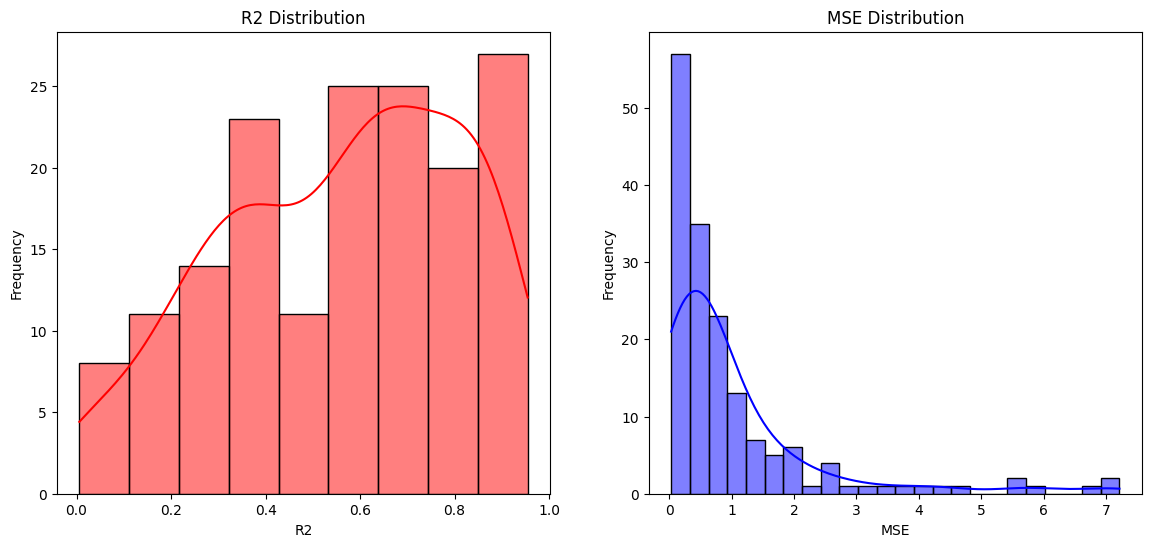

In [23]:
mse_values = [value['mse'] for value in results.values()]
r2_values = [value['r2'] for value in results.values()]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot R2 distribution
sns.histplot(r2_values, kde=True, ax=axes[0], color='red')
axes[0].set_title('R2 Distribution')
axes[0].set_xlabel('R2')
axes[0].set_ylabel('Frequency')

# Plot MSE distribution
sns.histplot(mse_values, kde=True, ax=axes[1], color='blue')
axes[1].set_title('MSE Distribution')
axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Frequency')



In [31]:
import plotly.graph_objects as go

def plot_r2_mse_histogram(results, r2_color='red', mse_color='blue'):
    """
    Plots a histogram of R² and MSE values in descending order for each station.

    Parameters:
    results (dict): A dictionary where keys are station names and values are dictionaries
                    containing evaluation metrics including 'r2' and 'mse'.
                    Example: {'Station1': {'mse': 0.1, 'r2': 0.9}, 'Station2': {'mse': 0.2, 'r2': 0.85}, ...}
    """
    # Extract station names and corresponding R² and MSE values
    stations = list(results.keys())
    r2_values = [results[station]['r2'] for station in stations]
    mse_values = [results[station]['mse'] for station in stations]

    # Sort the stations, R² values, and MSE values in descending order of R² values
    sorted_stations_r2_mse = sorted(zip(stations, r2_values, mse_values), key=lambda x: x[1], reverse=True)
    sorted_stations, sorted_r2_values, sorted_mse_values = zip(*sorted_stations_r2_mse)

    # Create the plot
    fig = go.Figure()

    # Add a bar plot for R² values
    fig.add_trace(go.Bar(
        x=sorted_stations,
        y=sorted_r2_values,
        name='R²',
        marker=dict(color=r2_color),
        yaxis='y1'
    ))

    # Add a bar plot for MSE values
    fig.add_trace(go.Bar(
        x=sorted_stations,
        y=sorted_mse_values,
        name='MSE',
        marker=dict(color=mse_color),
        yaxis='y2'
    ))

    # Customize the layout
    fig.update_layout(
        title=dict(
            text='R² and MSE Values for each FLUXNET station',
            font=dict(color='black')
        ),
        xaxis=dict(
            title=dict(
                text='FLUXNET stations',
                font=dict(color='black')
            ),
            tickfont=dict(color='black'),
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title='R²',
            titlefont=dict(color=r2_color),
            tickfont=dict(color=r2_color),
            linecolor='black',
            mirror=True
        ),
        yaxis2=dict(
            title='MSE',
            titlefont=dict(color=mse_color),
            tickfont=dict(color=mse_color),
            overlaying='y',
            side='right',
            linecolor='black',
            mirror=True
        ),
        xaxis_tickangle=-45,
        template='plotly_white',
        legend=dict(
            x=0.1, y=1.1, orientation='h',
            font=dict(color='black')
        )
    )

    # Show the plot
    fig.show()

# Example usage


plot_r2_mse_histogram(results)

#### Experiment with valid stations treshold

In [10]:
igtp_list = ['ENF','GRA','DBF','CRO','WET','OSH','MF']
# Filter the DataFrame
cleaned_df = cleaned_df[cleaned_df['IGBP'].isin(igtp_list)]

In [11]:
ts_model_res = {}
IGBP_vareity = {}

for treshold in tqdm(np.arange(0.05, 1, 0.05)):

    valid_sations = {}
    for key in list(results):
        if results[key]['r2'] > treshold:
            valid_sations[key] = results[key]

    stations_to_keep = valid_sations.keys()
    filtered_df = cleaned_df[cleaned_df['station'].isin(stations_to_keep)]
    IGBP_vareity[treshold] = filtered_df.IGBP.value_counts().to_dict()


    mse, r2 = evaluate_station(filtered_df)
    ts_model_res[treshold] = {'mse': mse, 'r2': r2}
    print(treshold)

  0%|          | 0/19 [00:00<?, ?it/s]

0:	learn: 1.9503026	total: 17.6ms	remaining: 17.6s
100:	learn: 1.1422900	total: 2.14s	remaining: 19s
200:	learn: 0.9987639	total: 4.01s	remaining: 16s
300:	learn: 0.9095493	total: 5.9s	remaining: 13.7s
400:	learn: 0.8448606	total: 7.78s	remaining: 11.6s
500:	learn: 0.7911758	total: 9.69s	remaining: 9.65s
600:	learn: 0.7422627	total: 11.6s	remaining: 7.68s
700:	learn: 0.7023172	total: 13.4s	remaining: 5.73s
800:	learn: 0.6687659	total: 15.3s	remaining: 3.8s
900:	learn: 0.6359752	total: 17.1s	remaining: 1.88s


  5%|▌         | 1/19 [00:19<05:46, 19.25s/it]

999:	learn: 0.6107652	total: 19s	remaining: 0us
Mean Squared Error: 1.1939888296206358
R-squared: 0.7301039450533496
0.05
0:	learn: 1.9626986	total: 16ms	remaining: 16s
100:	learn: 1.1514759	total: 1.82s	remaining: 16.2s
200:	learn: 1.0033457	total: 3.6s	remaining: 14.3s
300:	learn: 0.9215005	total: 5.41s	remaining: 12.6s
400:	learn: 0.8622409	total: 7.19s	remaining: 10.7s
500:	learn: 0.8131849	total: 8.93s	remaining: 8.9s
600:	learn: 0.7718439	total: 10.7s	remaining: 7.1s
700:	learn: 0.7322017	total: 12.5s	remaining: 5.32s
800:	learn: 0.6956705	total: 14.2s	remaining: 3.54s
900:	learn: 0.6676214	total: 16.1s	remaining: 1.77s


 11%|█         | 2/19 [00:37<05:16, 18.60s/it]

999:	learn: 0.6394953	total: 17.9s	remaining: 0us
Mean Squared Error: 1.19884514596258
R-squared: 0.7290621163590341
0.1
0:	learn: 1.9663766	total: 15.4ms	remaining: 15.4s
100:	learn: 1.1467989	total: 1.78s	remaining: 15.9s
200:	learn: 0.9815730	total: 3.58s	remaining: 14.2s
300:	learn: 0.8826642	total: 5.36s	remaining: 12.4s
400:	learn: 0.8189915	total: 7.15s	remaining: 10.7s
500:	learn: 0.7696439	total: 8.99s	remaining: 8.96s
600:	learn: 0.7282306	total: 10.9s	remaining: 7.22s
700:	learn: 0.6886680	total: 12.7s	remaining: 5.41s
800:	learn: 0.6540782	total: 14.5s	remaining: 3.61s
900:	learn: 0.6229265	total: 16.4s	remaining: 1.8s


 16%|█▌        | 3/19 [00:55<04:55, 18.48s/it]

999:	learn: 0.5956719	total: 18.1s	remaining: 0us
Mean Squared Error: 1.2046992225009165
R-squared: 0.7269990710996748
0.15000000000000002
0:	learn: 1.9685445	total: 15.5ms	remaining: 15.5s
100:	learn: 1.1167461	total: 1.76s	remaining: 15.7s
200:	learn: 0.9661625	total: 3.49s	remaining: 13.9s
300:	learn: 0.8808402	total: 5.2s	remaining: 12.1s
400:	learn: 0.8161079	total: 6.91s	remaining: 10.3s
500:	learn: 0.7618400	total: 8.67s	remaining: 8.64s
600:	learn: 0.7153402	total: 10.4s	remaining: 6.92s
700:	learn: 0.6756377	total: 12.2s	remaining: 5.2s
800:	learn: 0.6414633	total: 13.9s	remaining: 3.46s
900:	learn: 0.6121801	total: 15.7s	remaining: 1.73s


 21%|██        | 4/19 [01:13<04:32, 18.14s/it]

999:	learn: 0.5849013	total: 17.4s	remaining: 0us
Mean Squared Error: 1.280486157140225
R-squared: 0.7163053427208311
0.2
0:	learn: 1.9791824	total: 15.5ms	remaining: 15.5s
100:	learn: 1.1215304	total: 1.79s	remaining: 15.9s
200:	learn: 0.9720628	total: 3.56s	remaining: 14.2s
300:	learn: 0.8808696	total: 5.34s	remaining: 12.4s
400:	learn: 0.8143453	total: 7.04s	remaining: 10.5s
500:	learn: 0.7594831	total: 8.78s	remaining: 8.75s
600:	learn: 0.7170363	total: 10.5s	remaining: 6.97s
700:	learn: 0.6797880	total: 12.2s	remaining: 5.21s
800:	learn: 0.6446228	total: 13.9s	remaining: 3.46s
900:	learn: 0.6109543	total: 15.7s	remaining: 1.72s


 26%|██▋       | 5/19 [01:30<04:11, 17.94s/it]

999:	learn: 0.5837978	total: 17.4s	remaining: 0us
Mean Squared Error: 1.239753817316237
R-squared: 0.7272360943579794
0.25
0:	learn: 1.9798038	total: 14.8ms	remaining: 14.8s
100:	learn: 1.0658529	total: 1.72s	remaining: 15.3s
200:	learn: 0.9219224	total: 3.4s	remaining: 13.5s
300:	learn: 0.8285402	total: 5.1s	remaining: 11.9s
400:	learn: 0.7672586	total: 6.8s	remaining: 10.2s
500:	learn: 0.7194488	total: 8.5s	remaining: 8.46s
600:	learn: 0.6757690	total: 10.2s	remaining: 6.75s
700:	learn: 0.6390228	total: 11.9s	remaining: 5.05s
800:	learn: 0.6048665	total: 13.6s	remaining: 3.37s
900:	learn: 0.5745626	total: 15.3s	remaining: 1.68s


 32%|███▏      | 6/19 [01:48<03:49, 17.68s/it]

999:	learn: 0.5463290	total: 17s	remaining: 0us
Mean Squared Error: 1.1130260528570248
R-squared: 0.7538903285240895
0.3
0:	learn: 2.0189696	total: 14.6ms	remaining: 14.6s
100:	learn: 1.0499910	total: 1.72s	remaining: 15.4s
200:	learn: 0.8938788	total: 3.39s	remaining: 13.5s
300:	learn: 0.8001400	total: 5.08s	remaining: 11.8s
400:	learn: 0.7319888	total: 6.76s	remaining: 10.1s
500:	learn: 0.6793457	total: 8.44s	remaining: 8.41s
600:	learn: 0.6363134	total: 10.1s	remaining: 6.71s
700:	learn: 0.5992792	total: 11.8s	remaining: 5.03s
800:	learn: 0.5642051	total: 13.4s	remaining: 3.33s
900:	learn: 0.5360738	total: 15.1s	remaining: 1.65s


 37%|███▋      | 7/19 [02:04<03:28, 17.41s/it]

999:	learn: 0.5065174	total: 16.7s	remaining: 0us
Mean Squared Error: 0.9977053317902598
R-squared: 0.7669488323178125
0.35000000000000003
0:	learn: 2.0535209	total: 14.1ms	remaining: 14.1s
100:	learn: 1.0479087	total: 1.66s	remaining: 14.8s
200:	learn: 0.8788131	total: 3.31s	remaining: 13.1s
300:	learn: 0.7860840	total: 4.96s	remaining: 11.5s
400:	learn: 0.7227313	total: 6.6s	remaining: 9.86s
500:	learn: 0.6720463	total: 8.26s	remaining: 8.22s
600:	learn: 0.6292741	total: 9.9s	remaining: 6.57s
700:	learn: 0.5928445	total: 11.6s	remaining: 4.93s
800:	learn: 0.5582725	total: 13.2s	remaining: 3.28s
900:	learn: 0.5286141	total: 14.8s	remaining: 1.63s


 42%|████▏     | 8/19 [02:21<03:09, 17.18s/it]

999:	learn: 0.5027437	total: 16.5s	remaining: 0us
Mean Squared Error: 0.8747852015821742
R-squared: 0.8026505506379837
0.4
0:	learn: 1.9953011	total: 14.6ms	remaining: 14.6s
100:	learn: 0.9514631	total: 1.68s	remaining: 15s
200:	learn: 0.7951289	total: 3.29s	remaining: 13.1s
300:	learn: 0.7034203	total: 4.95s	remaining: 11.5s
400:	learn: 0.6360909	total: 6.54s	remaining: 9.78s
500:	learn: 0.5865046	total: 8.17s	remaining: 8.14s
600:	learn: 0.5444331	total: 9.76s	remaining: 6.48s
700:	learn: 0.5081282	total: 11.4s	remaining: 4.86s
800:	learn: 0.4776111	total: 13s	remaining: 3.23s
900:	learn: 0.4493166	total: 14.6s	remaining: 1.61s


 47%|████▋     | 9/19 [02:38<02:49, 16.95s/it]

999:	learn: 0.4253980	total: 16.2s	remaining: 0us
Mean Squared Error: 0.919401135406148
R-squared: 0.8036803554811841
0.45
0:	learn: 2.0306805	total: 13.1ms	remaining: 13.1s
100:	learn: 0.9529127	total: 1.62s	remaining: 14.4s
200:	learn: 0.8118968	total: 3.21s	remaining: 12.8s
300:	learn: 0.7155230	total: 4.85s	remaining: 11.3s
400:	learn: 0.6450204	total: 6.46s	remaining: 9.65s
500:	learn: 0.5898194	total: 8.11s	remaining: 8.08s
600:	learn: 0.5470862	total: 9.73s	remaining: 6.46s
700:	learn: 0.5080098	total: 11.3s	remaining: 4.83s
800:	learn: 0.4750477	total: 12.9s	remaining: 3.21s
900:	learn: 0.4450809	total: 14.5s	remaining: 1.6s


 53%|█████▎    | 10/19 [02:54<02:30, 16.74s/it]

999:	learn: 0.4209750	total: 16.1s	remaining: 0us
Mean Squared Error: 0.8964687445448299
R-squared: 0.7977988209761613
0.5
0:	learn: 2.0320566	total: 13.8ms	remaining: 13.8s
100:	learn: 0.9260021	total: 1.64s	remaining: 14.6s
200:	learn: 0.7741592	total: 3.21s	remaining: 12.8s
300:	learn: 0.6852695	total: 4.8s	remaining: 11.1s
400:	learn: 0.6205405	total: 6.36s	remaining: 9.51s
500:	learn: 0.5655990	total: 8s	remaining: 7.97s
600:	learn: 0.5212429	total: 9.6s	remaining: 6.37s
700:	learn: 0.4827160	total: 11.2s	remaining: 4.78s
800:	learn: 0.4506917	total: 12.7s	remaining: 3.16s
900:	learn: 0.4239476	total: 14.3s	remaining: 1.57s


 58%|█████▊    | 11/19 [03:10<02:12, 16.54s/it]

999:	learn: 0.3977971	total: 15.9s	remaining: 0us
Mean Squared Error: 0.9015684296906137
R-squared: 0.8206920002268354
0.55
0:	learn: 2.1019677	total: 13.9ms	remaining: 13.9s
100:	learn: 0.9241391	total: 1.61s	remaining: 14.4s
200:	learn: 0.7772344	total: 3.15s	remaining: 12.5s
300:	learn: 0.6809116	total: 4.71s	remaining: 10.9s
400:	learn: 0.6108101	total: 6.25s	remaining: 9.34s
500:	learn: 0.5562696	total: 7.82s	remaining: 7.79s
600:	learn: 0.5134057	total: 9.41s	remaining: 6.25s
700:	learn: 0.4740538	total: 11s	remaining: 4.7s
800:	learn: 0.4383223	total: 12.6s	remaining: 3.12s
900:	learn: 0.4094887	total: 14.1s	remaining: 1.55s


 63%|██████▎   | 12/19 [03:26<01:54, 16.33s/it]

999:	learn: 0.3855411	total: 15.6s	remaining: 0us
Mean Squared Error: 0.789452635540347
R-squared: 0.8296598401717948
0.6000000000000001
0:	learn: 2.1705156	total: 13ms	remaining: 13s
100:	learn: 0.8975035	total: 1.59s	remaining: 14.2s
200:	learn: 0.7239045	total: 3.13s	remaining: 12.4s
300:	learn: 0.6265760	total: 4.67s	remaining: 10.8s
400:	learn: 0.5609691	total: 6.19s	remaining: 9.24s
500:	learn: 0.5049469	total: 7.72s	remaining: 7.69s
600:	learn: 0.4610378	total: 9.23s	remaining: 6.13s
700:	learn: 0.4218130	total: 10.8s	remaining: 4.62s
800:	learn: 0.3888766	total: 12.3s	remaining: 3.06s
900:	learn: 0.3614128	total: 13.9s	remaining: 1.53s


 68%|██████▊   | 13/19 [03:41<01:36, 16.10s/it]

999:	learn: 0.3391039	total: 15.4s	remaining: 0us
Mean Squared Error: 0.6354248698142186
R-squared: 0.8674271137701833
0.6500000000000001
0:	learn: 2.2326398	total: 12.2ms	remaining: 12.2s
100:	learn: 0.8521191	total: 1.54s	remaining: 13.7s
200:	learn: 0.6912394	total: 3s	remaining: 11.9s
300:	learn: 0.5943261	total: 4.56s	remaining: 10.6s
400:	learn: 0.5263447	total: 6.13s	remaining: 9.16s
500:	learn: 0.4724933	total: 7.81s	remaining: 7.78s
600:	learn: 0.4287429	total: 9.51s	remaining: 6.31s
700:	learn: 0.3921091	total: 11.3s	remaining: 4.81s
800:	learn: 0.3587230	total: 13s	remaining: 3.24s
900:	learn: 0.3328532	total: 14.7s	remaining: 1.62s


 74%|███████▎  | 14/19 [03:58<01:21, 16.24s/it]

999:	learn: 0.3078839	total: 16.4s	remaining: 0us
Mean Squared Error: 0.9134390825617508
R-squared: 0.8447011588095003
0.7000000000000001
0:	learn: 2.3446504	total: 13.9ms	remaining: 13.9s
100:	learn: 0.8597403	total: 1.74s	remaining: 15.5s
200:	learn: 0.6860139	total: 3.42s	remaining: 13.6s
300:	learn: 0.5783304	total: 5.14s	remaining: 11.9s
400:	learn: 0.5034524	total: 6.83s	remaining: 10.2s
500:	learn: 0.4486755	total: 8.69s	remaining: 8.65s
600:	learn: 0.4067892	total: 10.4s	remaining: 6.87s
700:	learn: 0.3665546	total: 12.1s	remaining: 5.15s
800:	learn: 0.3344462	total: 13.7s	remaining: 3.41s
900:	learn: 0.3066104	total: 15.4s	remaining: 1.69s


 79%|███████▉  | 15/19 [04:15<01:06, 16.55s/it]

999:	learn: 0.2826002	total: 17.1s	remaining: 0us
Mean Squared Error: 0.8027592435159461
R-squared: 0.879107411606112
0.7500000000000001
0:	learn: 2.4857577	total: 13.5ms	remaining: 13.5s
100:	learn: 0.8399732	total: 1.65s	remaining: 14.7s
200:	learn: 0.6749997	total: 3.29s	remaining: 13.1s
300:	learn: 0.5715649	total: 4.95s	remaining: 11.5s
400:	learn: 0.5001117	total: 6.49s	remaining: 9.7s
500:	learn: 0.4433104	total: 7.95s	remaining: 7.92s
600:	learn: 0.3957222	total: 9.53s	remaining: 6.33s
700:	learn: 0.3539965	total: 11.1s	remaining: 4.74s
800:	learn: 0.3174438	total: 12.6s	remaining: 3.14s
900:	learn: 0.2865366	total: 14.2s	remaining: 1.56s


 84%|████████▍ | 16/19 [04:31<00:49, 16.37s/it]

999:	learn: 0.2618143	total: 15.7s	remaining: 0us
Mean Squared Error: 0.7450909600585695
R-squared: 0.8956962039898476
0.8
0:	learn: 2.5901254	total: 12.2ms	remaining: 12.2s
100:	learn: 0.7486054	total: 1.51s	remaining: 13.5s
200:	learn: 0.5682620	total: 2.95s	remaining: 11.7s
300:	learn: 0.4608607	total: 4.56s	remaining: 10.6s
400:	learn: 0.3826309	total: 5.99s	remaining: 8.95s
500:	learn: 0.3247453	total: 7.55s	remaining: 7.52s
600:	learn: 0.2787415	total: 8.98s	remaining: 5.96s
700:	learn: 0.2422446	total: 10.5s	remaining: 4.5s
800:	learn: 0.2140172	total: 12.1s	remaining: 3s
900:	learn: 0.1911528	total: 13.6s	remaining: 1.49s


 89%|████████▉ | 17/19 [04:46<00:32, 16.03s/it]

999:	learn: 0.1725812	total: 15s	remaining: 0us
Mean Squared Error: 0.9938871108407062
R-squared: 0.8622605112202435
0.8500000000000001
0:	learn: 3.0330769	total: 12.4ms	remaining: 12.4s
100:	learn: 0.5417557	total: 1.47s	remaining: 13.1s
200:	learn: 0.3113156	total: 2.9s	remaining: 11.5s
300:	learn: 0.1884798	total: 4.31s	remaining: 10s
400:	learn: 0.1284762	total: 5.83s	remaining: 8.7s
500:	learn: 0.0859827	total: 7.24s	remaining: 7.21s
600:	learn: 0.0620692	total: 8.77s	remaining: 5.82s
700:	learn: 0.0462079	total: 10.2s	remaining: 4.36s
800:	learn: 0.0340778	total: 11.8s	remaining: 2.92s
900:	learn: 0.0246768	total: 13.3s	remaining: 1.46s


 95%|█████████▍| 18/19 [05:01<00:15, 15.69s/it]

999:	learn: 0.0194971	total: 14.7s	remaining: 0us
Mean Squared Error: 1.2193367232334786
R-squared: 0.8832686420525755
0.9000000000000001
0:	learn: 3.8700625	total: 1.08ms	remaining: 1.07s
100:	learn: 0.1269621	total: 88ms	remaining: 784ms
200:	learn: 0.0174791	total: 158ms	remaining: 626ms
300:	learn: 0.0031986	total: 224ms	remaining: 519ms
400:	learn: 0.0007463	total: 288ms	remaining: 431ms
500:	learn: 0.0001837	total: 356ms	remaining: 354ms
600:	learn: 0.0000468	total: 424ms	remaining: 281ms
700:	learn: 0.0000131	total: 490ms	remaining: 209ms


100%|██████████| 19/19 [05:02<00:00, 15.93s/it]

800:	learn: 0.0000036	total: 560ms	remaining: 139ms
900:	learn: 0.0000011	total: 630ms	remaining: 69.2ms
999:	learn: 0.0000003	total: 692ms	remaining: 0us
Mean Squared Error: 0.8291344225303632
R-squared: 0.9546361874372638
0.9500000000000001


In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_ecosystem_data(data, color_mapping, ts_model_res):
    """
    Plots a stacked bar chart for ecosystem data and a line plot for R2 scores using Plotly.

    Parameters:
    data (dict): A dictionary where keys are thresholds and values are dictionaries
                 of ecosystem counts.
    color_mapping (dict): A dictionary mapping ecosystem names to color codes.
    ts_model_res (dict): A dictionary where keys are parameters and values are dictionaries
                         containing 'r2' scores.
    """
    # Extract thresholds and ecosystems
    thresholds = list(data.keys())
    ecosystems = list({eco for d in data.values() for eco in d.keys()})

    # Prepare data for plotting
    plot_data = {eco: [data[t].get(eco, 0) for t in thresholds] for eco in ecosystems}

    # Extract keys and R2 values for the line plot
    keys = list(ts_model_res.keys())
    r2_values = [ts_model_res[key]['r2'] for key in keys]

    # Create the subplot figure with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Ecosystem distribution in data', 'R² for treshold value'))

    # Add traces for each ecosystem (stacked bar chart)
    for eco, values in plot_data.items():
        fig.add_trace(go.Bar(
            x=thresholds,
            y=values,
            name=eco,
            marker_color=color_mapping.get(eco, '#000000')  # Default to black if not found
        ), row=1, col=1)

    # Add the line plot for R2 scores
    fig.add_trace(go.Scatter(
        x=keys,
        y=r2_values,
        mode='lines+markers',
        name='R2 Score',
        marker=dict(color='blue')
    ), row=1, col=2)

    # Update layout for better visualization
    fig.update_layout(
        barmode='stack',
        xaxis=dict(
            title='Threshold',
            showgrid=True,  # Show gridlines on x-axis
            gridcolor='lightgrey'  # Color of the gridlines
        ),
        yaxis=dict(
            title='Total Number of measurements',
            showgrid=True,  # Show gridlines on y-axis
            gridcolor='lightgrey'  # Color of the gridlines
        ),
        xaxis2=dict(
            title='Threshold',
            showgrid=True,  # Show gridlines on x-axis
            gridcolor='lightgrey',  # Color of the gridlines
            dtick=0.2  # More vertical grid line
        ),
        yaxis2=dict(
            title='R² Score',
            showgrid=True,  # Show gridlines on y-axis
            gridcolor='lightgrey'  # Color of the gridlines
        ),
        legend=dict(
            title='',
            orientation='h',  # Horizontal legend
            yanchor='bottom',
            y=-0.3,  # Position legend below the plots
            xanchor='center',
            x=0.5
        ),
        plot_bgcolor='white',  # Set the plot background color to white
        paper_bgcolor='white'  # Set the paper background color to white
    )

    # Show the plot
    fig.show()



color_mapping = {
    'ENF': '#008001',
    'GRA': '#FF9900',
    'DBF': '#99FF99', 
    'CRO': '#FFFF00',
    'WET': '#006699', 
    'OSH': '#FFCC99', 
    'MF': '#339966', 
    'EBF': '#02FF00',
    'CSH': '#993365',
}


plot_ecosystem_data(IGBP_vareity, color_mapping, ts_model_res)

In [77]:
# valid_stations_list = 
for key in list(results):
    if results[key]['r2'] > 0.3:
        valid_sations[key] = results[key]

valid_stations_list =  list(valid_sations.keys())

Conclusion: treshhold = 0.3 is optimal number. If we will use only stations that have R2 bigger than 0.3 on on eigenvalue modeling, we will have r2 > 0.76 on overall modelling (Using baseline model). Also such threshold keeps variety in IGBP ecosystems it training data. 

### SHAP

In [4]:
data_preprocessing = DataPreprocessing(r'C:\Univercity\Skoltech\NEE_2.0\forest_meteo_gpp_nee_2024.csv', 
                                  r'C:\Univercity\Skoltech\NEE_2.0\NO_FOREST_meteo_gpp_nee_2024.csv')

data_preprocessing.load_and_clean_data()
data_preprocessing.drop_rows_with_value_counts()

corr_features = data_preprocessing.correlation(data_preprocessing.df.drop(['NEE', 'GPP'], axis=1), 0.6)
data_preprocessing.df.drop(corr_features, axis=1, inplace=True)

cleaned_df, df_date, category = data_preprocessing.mean_daily_data_by_month()
cleaned_df = cleaned_df.interpolate()

In [5]:
features_to_drop = ['Year','Month', 'station', 'lon', 'lat', 'NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Separate categorical and numerical features
X_train_num = X_train.drop(columns=categorical_features)
X_test_num = X_test.drop(columns=categorical_features)

# Fit the scaler on the numerical training data and transform both training and testing numerical data
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert scaled numerical data back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Concatenate scaled numerical data with categorical data
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[categorical_features]], axis=1)

# Create Pool objects for training and testing
train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test_scaled, label=y_test, cat_features=categorical_features)

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
# model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
# Train the model
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

0:	learn: 1.9555124	total: 198ms	remaining: 3m 17s
100:	learn: 1.0884509	total: 6.29s	remaining: 56s
200:	learn: 0.9409877	total: 11.6s	remaining: 46.2s
300:	learn: 0.8528533	total: 16.3s	remaining: 38s
400:	learn: 0.7912653	total: 21.2s	remaining: 31.6s
500:	learn: 0.7354657	total: 25.8s	remaining: 25.7s
600:	learn: 0.6894081	total: 30.6s	remaining: 20.3s
700:	learn: 0.6507482	total: 35.3s	remaining: 15.1s
800:	learn: 0.6156772	total: 40.1s	remaining: 9.97s
900:	learn: 0.5840549	total: 45s	remaining: 4.95s
999:	learn: 0.5573043	total: 49.9s	remaining: 0us
Mean Squared Error: 1.0551811405782516
R-squared: 0.7511225755220825


#### Simple feature importance

In [69]:
# Calculate feature importance
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train_scaled.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Dictionary to store R-squared values
r2_dict = {}

# Iteratively train the model with increasing number of top features
for i in tqdm(range(1, len(feature_importance_df) + 1)):
    top_features = feature_importance_df['Feature'].iloc[:i].tolist()
    
    X_train_top = X_train_scaled[top_features]
    X_test_top = X_test_scaled[top_features]
    
    categorical_features = ['IGBP']
    train_pool_top = Pool(data=X_train_top, label=y_train, cat_features=[f for f in top_features if f in categorical_features])
    test_pool_top = Pool(data=X_test_top, label=y_test, cat_features=[f for f in top_features if f in categorical_features])
    
    model_top = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
    model_top.fit(train_pool_top)
    
    predictions_top = model_top.predict(test_pool_top)
    
    r2_top = r2_score(y_test, predictions_top)
    r2_dict[i] = r2_top




  0%|          | 0/22 [00:00<?, ?it/s]

0:	learn: 1.9644300	total: 1.91ms	remaining: 1.91s
100:	learn: 1.5955181	total: 214ms	remaining: 1.9s
200:	learn: 1.5856451	total: 370ms	remaining: 1.47s
300:	learn: 1.5812611	total: 523ms	remaining: 1.21s
400:	learn: 1.5791903	total: 673ms	remaining: 1s
500:	learn: 1.5781457	total: 824ms	remaining: 821ms
600:	learn: 1.5775960	total: 975ms	remaining: 648ms
700:	learn: 1.5772496	total: 1.13s	remaining: 480ms
800:	learn: 1.5770198	total: 1.28s	remaining: 317ms


  5%|▍         | 1/22 [00:01<00:34,  1.66s/it]

900:	learn: 1.5768689	total: 1.43s	remaining: 157ms
999:	learn: 1.5767727	total: 1.58s	remaining: 0us
0:	learn: 1.9661598	total: 13.7ms	remaining: 13.7s
100:	learn: 1.4979125	total: 1.69s	remaining: 15s
200:	learn: 1.4711773	total: 3.33s	remaining: 13.2s
300:	learn: 1.4553588	total: 4.98s	remaining: 11.6s
400:	learn: 1.4406375	total: 6.61s	remaining: 9.88s
500:	learn: 1.4278966	total: 8.29s	remaining: 8.26s
600:	learn: 1.4172517	total: 9.92s	remaining: 6.59s
700:	learn: 1.4069254	total: 11.6s	remaining: 4.96s
800:	learn: 1.3975199	total: 13.3s	remaining: 3.31s
900:	learn: 1.3889253	total: 15s	remaining: 1.65s


  9%|▉         | 2/22 [00:18<03:30, 10.53s/it]

999:	learn: 1.3811775	total: 16.6s	remaining: 0us
0:	learn: 1.9555098	total: 14.3ms	remaining: 14.3s
100:	learn: 1.3006600	total: 1.67s	remaining: 14.8s
200:	learn: 1.1956857	total: 3.35s	remaining: 13.3s
300:	learn: 1.1359349	total: 5.07s	remaining: 11.8s
400:	learn: 1.0972151	total: 6.85s	remaining: 10.2s
500:	learn: 1.0609042	total: 8.65s	remaining: 8.62s
600:	learn: 1.0325045	total: 10.4s	remaining: 6.91s
700:	learn: 1.0091182	total: 12.1s	remaining: 5.17s
800:	learn: 0.9875289	total: 13.8s	remaining: 3.43s
900:	learn: 0.9701507	total: 15.5s	remaining: 1.7s


 14%|█▎        | 3/22 [00:35<04:18, 13.62s/it]

999:	learn: 0.9553663	total: 17.2s	remaining: 0us
0:	learn: 1.9571265	total: 15.5ms	remaining: 15.5s
100:	learn: 1.1948714	total: 1.79s	remaining: 16s
200:	learn: 1.0923884	total: 3.56s	remaining: 14.2s
300:	learn: 1.0297386	total: 5.31s	remaining: 12.3s
400:	learn: 0.9893889	total: 7.01s	remaining: 10.5s
500:	learn: 0.9570630	total: 8.77s	remaining: 8.74s
600:	learn: 0.9251374	total: 10.5s	remaining: 6.94s
700:	learn: 0.9004194	total: 12.3s	remaining: 5.23s
800:	learn: 0.8792512	total: 14.1s	remaining: 3.5s
900:	learn: 0.8600749	total: 15.9s	remaining: 1.74s


 18%|█▊        | 4/22 [00:53<04:34, 15.23s/it]

999:	learn: 0.8415359	total: 17.6s	remaining: 0us
0:	learn: 1.9591517	total: 14.8ms	remaining: 14.8s
100:	learn: 1.1685512	total: 1.79s	remaining: 15.9s
200:	learn: 1.0609389	total: 3.48s	remaining: 13.9s
300:	learn: 1.0022336	total: 5.28s	remaining: 12.3s
400:	learn: 0.9541664	total: 7.03s	remaining: 10.5s
500:	learn: 0.9142337	total: 8.78s	remaining: 8.74s
600:	learn: 0.8831035	total: 10.5s	remaining: 6.97s
700:	learn: 0.8559788	total: 12.3s	remaining: 5.23s
800:	learn: 0.8313162	total: 14s	remaining: 3.48s
900:	learn: 0.8102090	total: 15.8s	remaining: 1.74s


 23%|██▎       | 5/22 [01:11<04:33, 16.11s/it]

999:	learn: 0.7909097	total: 17.5s	remaining: 0us
0:	learn: 1.9526721	total: 15.2ms	remaining: 15.2s
100:	learn: 1.1381823	total: 1.87s	remaining: 16.7s
200:	learn: 1.0315305	total: 3.65s	remaining: 14.5s
300:	learn: 0.9737979	total: 5.43s	remaining: 12.6s
400:	learn: 0.9286082	total: 7.21s	remaining: 10.8s
500:	learn: 0.8890231	total: 9.08s	remaining: 9.05s
600:	learn: 0.8555085	total: 10.8s	remaining: 7.19s
700:	learn: 0.8264156	total: 12.7s	remaining: 5.41s
800:	learn: 0.8022273	total: 14.5s	remaining: 3.6s
900:	learn: 0.7771718	total: 16.3s	remaining: 1.79s


 27%|██▋       | 6/22 [01:29<04:29, 16.83s/it]

999:	learn: 0.7550694	total: 18.1s	remaining: 0us
0:	learn: 1.9521792	total: 16ms	remaining: 16s
100:	learn: 1.1239013	total: 1.88s	remaining: 16.7s
200:	learn: 1.0152630	total: 3.77s	remaining: 15s
300:	learn: 0.9451970	total: 5.6s	remaining: 13s
400:	learn: 0.8953289	total: 7.41s	remaining: 11.1s
500:	learn: 0.8536576	total: 9.3s	remaining: 9.27s
600:	learn: 0.8161402	total: 11.2s	remaining: 7.42s
700:	learn: 0.7863713	total: 13.1s	remaining: 5.6s
800:	learn: 0.7584432	total: 15s	remaining: 3.73s
900:	learn: 0.7339651	total: 16.9s	remaining: 1.85s


 32%|███▏      | 7/22 [01:48<04:21, 17.46s/it]

999:	learn: 0.7121307	total: 18.6s	remaining: 0us
0:	learn: 1.9561019	total: 16.4ms	remaining: 16.4s
100:	learn: 1.1211044	total: 1.86s	remaining: 16.5s
200:	learn: 1.0082151	total: 3.74s	remaining: 14.9s
300:	learn: 0.9458822	total: 5.69s	remaining: 13.2s
400:	learn: 0.8934100	total: 7.57s	remaining: 11.3s
500:	learn: 0.8507549	total: 9.49s	remaining: 9.45s
600:	learn: 0.8161280	total: 11.3s	remaining: 7.5s
700:	learn: 0.7847622	total: 13.2s	remaining: 5.62s
800:	learn: 0.7547057	total: 15s	remaining: 3.73s
900:	learn: 0.7304639	total: 16.9s	remaining: 1.85s


 36%|███▋      | 8/22 [02:06<04:10, 17.91s/it]

999:	learn: 0.7095674	total: 18.8s	remaining: 0us
0:	learn: 1.9574797	total: 16.2ms	remaining: 16.1s
100:	learn: 1.1156697	total: 1.92s	remaining: 17.1s
200:	learn: 1.0004891	total: 3.77s	remaining: 15s
300:	learn: 0.9269498	total: 5.66s	remaining: 13.2s
400:	learn: 0.8726503	total: 7.58s	remaining: 11.3s
500:	learn: 0.8312752	total: 9.55s	remaining: 9.51s
600:	learn: 0.7948972	total: 11.4s	remaining: 7.58s
700:	learn: 0.7659212	total: 13.3s	remaining: 5.66s
800:	learn: 0.7361424	total: 15.2s	remaining: 3.77s
900:	learn: 0.7099858	total: 17s	remaining: 1.87s


 41%|████      | 9/22 [02:25<03:57, 18.24s/it]

999:	learn: 0.6866453	total: 18.8s	remaining: 0us
0:	learn: 1.9544640	total: 16ms	remaining: 15.9s
100:	learn: 1.1032844	total: 1.84s	remaining: 16.4s
200:	learn: 0.9808418	total: 3.67s	remaining: 14.6s
300:	learn: 0.9084790	total: 5.51s	remaining: 12.8s
400:	learn: 0.8559347	total: 7.32s	remaining: 10.9s
500:	learn: 0.8107357	total: 9.22s	remaining: 9.18s
600:	learn: 0.7758786	total: 11.1s	remaining: 7.36s
700:	learn: 0.7414238	total: 13s	remaining: 5.54s
800:	learn: 0.7101637	total: 14.9s	remaining: 3.69s
900:	learn: 0.6818991	total: 16.7s	remaining: 1.84s


 45%|████▌     | 10/22 [02:44<03:40, 18.37s/it]

999:	learn: 0.6598681	total: 18.5s	remaining: 0us
0:	learn: 1.9535095	total: 15.4ms	remaining: 15.4s
100:	learn: 1.1018444	total: 1.92s	remaining: 17.1s
200:	learn: 0.9759823	total: 3.82s	remaining: 15.2s
300:	learn: 0.9066997	total: 5.67s	remaining: 13.2s
400:	learn: 0.8534712	total: 7.53s	remaining: 11.2s
500:	learn: 0.8041044	total: 9.39s	remaining: 9.36s
600:	learn: 0.7626185	total: 11.2s	remaining: 7.46s
700:	learn: 0.7298093	total: 13.2s	remaining: 5.62s
800:	learn: 0.6992643	total: 15.1s	remaining: 3.74s
900:	learn: 0.6719132	total: 16.9s	remaining: 1.86s


 50%|█████     | 11/22 [03:03<03:23, 18.53s/it]

999:	learn: 0.6446216	total: 18.8s	remaining: 0us
0:	learn: 1.9526006	total: 16.1ms	remaining: 16.1s
100:	learn: 1.0959275	total: 1.88s	remaining: 16.8s
200:	learn: 0.9586053	total: 3.78s	remaining: 15s
300:	learn: 0.8830655	total: 5.72s	remaining: 13.3s
400:	learn: 0.8264626	total: 7.6s	remaining: 11.4s
500:	learn: 0.7799744	total: 9.51s	remaining: 9.47s
600:	learn: 0.7399455	total: 11.5s	remaining: 7.6s
700:	learn: 0.7087587	total: 13.4s	remaining: 5.73s
800:	learn: 0.6789922	total: 15.4s	remaining: 3.82s
900:	learn: 0.6525130	total: 17.2s	remaining: 1.9s


 55%|█████▍    | 12/22 [03:22<03:07, 18.73s/it]

999:	learn: 0.6273490	total: 19.1s	remaining: 0us
0:	learn: 1.9585963	total: 16.5ms	remaining: 16.5s
100:	learn: 1.0925957	total: 1.9s	remaining: 16.9s
200:	learn: 0.9667256	total: 3.75s	remaining: 14.9s
300:	learn: 0.8828369	total: 5.71s	remaining: 13.3s
400:	learn: 0.8252148	total: 7.59s	remaining: 11.3s
500:	learn: 0.7769920	total: 9.54s	remaining: 9.5s
600:	learn: 0.7365413	total: 11.5s	remaining: 7.64s
700:	learn: 0.7009909	total: 13.5s	remaining: 5.76s
800:	learn: 0.6734004	total: 15.5s	remaining: 3.84s
900:	learn: 0.6465349	total: 17.5s	remaining: 1.92s


 59%|█████▉    | 13/22 [03:42<02:50, 18.96s/it]

999:	learn: 0.6214569	total: 19.3s	remaining: 0us
0:	learn: 1.9543959	total: 16.2ms	remaining: 16.2s
100:	learn: 1.1005250	total: 1.93s	remaining: 17.2s
200:	learn: 0.9648904	total: 3.83s	remaining: 15.2s
300:	learn: 0.8846916	total: 5.77s	remaining: 13.4s
400:	learn: 0.8240542	total: 7.72s	remaining: 11.5s
500:	learn: 0.7728028	total: 9.61s	remaining: 9.57s
600:	learn: 0.7297169	total: 11.5s	remaining: 7.66s
700:	learn: 0.6931787	total: 13.5s	remaining: 5.76s
800:	learn: 0.6620967	total: 15.4s	remaining: 3.83s
900:	learn: 0.6334916	total: 17.4s	remaining: 1.91s


 64%|██████▎   | 14/22 [04:01<02:32, 19.10s/it]

999:	learn: 0.6090868	total: 19.3s	remaining: 0us
0:	learn: 1.9553238	total: 17.6ms	remaining: 17.6s
100:	learn: 1.0994461	total: 1.96s	remaining: 17.4s
200:	learn: 0.9587869	total: 3.9s	remaining: 15.5s
300:	learn: 0.8823983	total: 5.84s	remaining: 13.6s
400:	learn: 0.8172759	total: 7.82s	remaining: 11.7s
500:	learn: 0.7666177	total: 9.8s	remaining: 9.76s
600:	learn: 0.7235859	total: 11.7s	remaining: 7.78s
700:	learn: 0.6849560	total: 13.7s	remaining: 5.82s
800:	learn: 0.6520343	total: 15.6s	remaining: 3.88s
900:	learn: 0.6232126	total: 17.6s	remaining: 1.94s


 68%|██████▊   | 15/22 [04:21<02:15, 19.30s/it]

999:	learn: 0.5950563	total: 19.6s	remaining: 0us
0:	learn: 1.9540580	total: 16.6ms	remaining: 16.5s
100:	learn: 1.0856559	total: 1.95s	remaining: 17.4s
200:	learn: 0.9545598	total: 3.89s	remaining: 15.4s
300:	learn: 0.8727672	total: 5.9s	remaining: 13.7s
400:	learn: 0.8068499	total: 7.9s	remaining: 11.8s
500:	learn: 0.7551981	total: 9.85s	remaining: 9.81s
600:	learn: 0.7117479	total: 11.8s	remaining: 7.82s
700:	learn: 0.6753256	total: 13.7s	remaining: 5.85s
800:	learn: 0.6449478	total: 15.7s	remaining: 3.91s
900:	learn: 0.6175012	total: 17.7s	remaining: 1.95s


 73%|███████▎  | 16/22 [04:41<01:56, 19.44s/it]

999:	learn: 0.5919516	total: 19.6s	remaining: 0us
0:	learn: 1.9544939	total: 16.5ms	remaining: 16.5s
100:	learn: 1.0874024	total: 1.96s	remaining: 17.5s
200:	learn: 0.9491412	total: 3.93s	remaining: 15.6s
300:	learn: 0.8681770	total: 5.94s	remaining: 13.8s
400:	learn: 0.8064701	total: 7.85s	remaining: 11.7s
500:	learn: 0.7556113	total: 9.79s	remaining: 9.75s
600:	learn: 0.7118131	total: 11.8s	remaining: 7.83s
700:	learn: 0.6758342	total: 13.8s	remaining: 5.88s
800:	learn: 0.6423093	total: 15.7s	remaining: 3.91s
900:	learn: 0.6105409	total: 17.7s	remaining: 1.95s


 77%|███████▋  | 17/22 [05:00<01:37, 19.54s/it]

999:	learn: 0.5855899	total: 19.7s	remaining: 0us
0:	learn: 1.9545657	total: 16.3ms	remaining: 16.3s
100:	learn: 1.0866072	total: 1.92s	remaining: 17.1s
200:	learn: 0.9439547	total: 3.83s	remaining: 15.2s
300:	learn: 0.8592021	total: 5.77s	remaining: 13.4s
400:	learn: 0.7988558	total: 7.67s	remaining: 11.5s
500:	learn: 0.7470394	total: 9.6s	remaining: 9.56s
600:	learn: 0.7031171	total: 11.6s	remaining: 7.69s
700:	learn: 0.6667876	total: 13.5s	remaining: 5.78s
800:	learn: 0.6333980	total: 15.4s	remaining: 3.83s
900:	learn: 0.6039686	total: 17.3s	remaining: 1.91s


 82%|████████▏ | 18/22 [05:20<01:17, 19.48s/it]

999:	learn: 0.5789204	total: 19.2s	remaining: 0us
0:	learn: 1.9567400	total: 16.6ms	remaining: 16.5s
100:	learn: 1.0908044	total: 1.97s	remaining: 17.5s
200:	learn: 0.9444569	total: 3.94s	remaining: 15.7s
300:	learn: 0.8613124	total: 5.83s	remaining: 13.5s
400:	learn: 0.8013446	total: 7.71s	remaining: 11.5s
500:	learn: 0.7509706	total: 9.69s	remaining: 9.65s
600:	learn: 0.7046557	total: 11.6s	remaining: 7.68s
700:	learn: 0.6650033	total: 13.5s	remaining: 5.75s
800:	learn: 0.6330717	total: 15.4s	remaining: 3.82s
900:	learn: 0.6022243	total: 17.4s	remaining: 1.91s


 86%|████████▋ | 19/22 [05:39<00:58, 19.46s/it]

999:	learn: 0.5754930	total: 19.3s	remaining: 0us
0:	learn: 1.9593509	total: 17.5ms	remaining: 17.5s
100:	learn: 1.0906634	total: 1.95s	remaining: 17.3s
200:	learn: 0.9485139	total: 3.91s	remaining: 15.6s
300:	learn: 0.8588328	total: 5.89s	remaining: 13.7s
400:	learn: 0.7951579	total: 7.81s	remaining: 11.7s
500:	learn: 0.7456985	total: 9.73s	remaining: 9.69s
600:	learn: 0.6978994	total: 11.6s	remaining: 7.71s
700:	learn: 0.6595151	total: 13.6s	remaining: 5.78s
800:	learn: 0.6249809	total: 15.5s	remaining: 3.84s
900:	learn: 0.5935622	total: 17.5s	remaining: 1.92s


 91%|█████████ | 20/22 [05:59<00:38, 19.49s/it]

999:	learn: 0.5651622	total: 19.4s	remaining: 0us
0:	learn: 1.9568037	total: 16.8ms	remaining: 16.8s
100:	learn: 1.0923899	total: 1.95s	remaining: 17.4s
200:	learn: 0.9477992	total: 3.84s	remaining: 15.3s
300:	learn: 0.8575384	total: 5.82s	remaining: 13.5s
400:	learn: 0.7922260	total: 7.79s	remaining: 11.6s
500:	learn: 0.7371342	total: 9.75s	remaining: 9.71s
600:	learn: 0.6933033	total: 11.7s	remaining: 7.76s
700:	learn: 0.6543362	total: 13.6s	remaining: 5.8s
800:	learn: 0.6209827	total: 15.6s	remaining: 3.88s
900:	learn: 0.5915280	total: 17.6s	remaining: 1.94s


 95%|█████████▌| 21/22 [06:18<00:19, 19.54s/it]

999:	learn: 0.5649651	total: 19.5s	remaining: 0us
0:	learn: 1.9528609	total: 18.4ms	remaining: 18.4s
100:	learn: 1.0845482	total: 1.96s	remaining: 17.4s
200:	learn: 0.9383507	total: 3.95s	remaining: 15.7s
300:	learn: 0.8562390	total: 5.96s	remaining: 13.8s
400:	learn: 0.7924097	total: 7.89s	remaining: 11.8s
500:	learn: 0.7375972	total: 9.86s	remaining: 9.82s
600:	learn: 0.6936885	total: 11.8s	remaining: 7.83s
700:	learn: 0.6560013	total: 13.9s	remaining: 5.92s
800:	learn: 0.6233751	total: 15.9s	remaining: 3.94s
900:	learn: 0.5914965	total: 17.8s	remaining: 1.96s


100%|██████████| 22/22 [06:38<00:00, 18.12s/it]

999:	learn: 0.5647766	total: 19.7s	remaining: 0us


In [90]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_feature_importance_and_r2(model, train_pool, X_train_scaled, r2_dict):
    """
    Plots feature importances and R2 values side by side using Plotly.

    Parameters:
    model: The trained model object.
    train_pool: The training data pool used by the model.
    X_train_scaled: The scaled training data used by the model.
    r2_dict (dict): A dictionary where keys are parameters and values are R2 scores.
    """
    # Get feature importances
    feature_importances = model.get_feature_importance(train_pool)
    feature_names = X_train_scaled.columns

    # Create a DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=True)

    # Extract keys and R2 values for the bar plot
    keys = list(r2_dict.keys())
    r2_values = list(r2_dict.values())

    # Calculate the height of the plot based on the number of features
    num_features = len(importance_df)
    plot_height = max(600, num_features * 20)  # Adjust the multiplier as needed

    # Create the subplot figure with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Feature Importances', 'Stepwise Forward Selection'))

    # Add the bar plot for feature importances
    fig.add_trace(go.Bar(
        x=importance_df['Importance'],
        y=importance_df['Feature'],
        orientation='h',
        name='Feature Importance',
        marker_color='orange'
    ), row=1, col=1)

    # Add the bar plot for R2 values
    fig.add_trace(go.Bar(
        x=keys,
        y=r2_values,
        name='R² Value',
        marker_color='green'
    ), row=1, col=2)

    # Add a red arrow annotation above the tenth bar on the right plot
    if len(keys) >= 10:
        fig.add_annotation(
            x=keys[9],  # The x position of the tenth bar
            y=r2_values[9] + 0.05,  # Slightly above the tenth bar
            text='',  # No text, just an arrow
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='red',
            ax=0,  # Arrow tail x position
            ay=-40,  # Arrow tail y position (negative value means above the point)
            xref='x2',  # Reference to the x-axis of the second plot
            yref='y2'   # Reference to the y-axis of the second plot
        )

    # Update layout for better visualization
    fig.update_layout(
        height=plot_height,
        width=1200,
        xaxis=dict(
            title='Importance',
            showgrid=True,  # Show gridlines on x-axis
            gridcolor='lightgrey'  # Color of the gridlines
        ),
        yaxis=dict(
            title='Feature',
            showgrid=True,  # Show gridlines on y-axis
            gridcolor='lightgrey'  # Color of the gridlines
        ),
        xaxis2=dict(
            title='Number of Features',
            showgrid=True,  # Show gridlines on x-axis
            gridcolor='lightgrey'  # Color of the gridlines
        ),
        yaxis2=dict(
            title='R² value',
            showgrid=True,  # Show gridlines on y-axis
            gridcolor='lightgrey'  # Color of the gridlines
        ),
        legend=dict(
            title='',
            orientation='h',  # Horizontal legend
            yanchor='bottom',
            y=-0.3,  # Position legend below the plots
            xanchor='center',
            x=0.5,
            font=dict(size=20)  # Increase the size of the legend text
        ),
        plot_bgcolor='white',  # Set the plot background color to white
        paper_bgcolor='white'  # Set the paper background color to white
    )

    # Show the plot
    fig.show()

# Example usage
# Assuming model, train_pool, X_train_scaled, and r2_dict are already defined
plot_feature_importance_and_r2(model, train_pool, X_train_scaled, r2_dict)

In [ ]:
l = [GPP, IGBP, ZOM, RHOA, PW, ALLSKY_SRF_ALB, TS_RANGE, CLRSKY_SRF_ALB, WS50M_MIN, ZENITH_LUMINANCE, EVPTRNS, GWETTOP, ALLSKY_NKT, WS50M_RANGE, TROPT, WD50M, CLOUD_OD, PRECTOTCORR, V50M, PRECSNOLAND, CLRSKY_DAYS, SLP]

In [16]:
top_features[:10]

['GPP',
 'IGBP',
 'Z0M',
 'RHOA',
 'PW',
 'ALLSKY_SRF_ALB',
 'TS_RANGE',
 'CLRSKY_SRF_ALB',
 'WS50M_MIN',
 'ZENITH_LUMINANCE']

In [17]:
valid_features = ['GPP', 'IGBP', 'Z0M', 'RHOA', 'PW', 'ALLSKY_SRF_ALB',
                   'TS_RANGE', 'CLRSKY_SRF_ALB', 'WS50M_MIN', 'ZENITH_LUMINANCE']

Conclusion: 10 features are enough, after this number results dont change much. 

#### SHAP plots

In [6]:
data_preprocessing = DataPreprocessing(r'C:\Univercity\Skoltech\NEE_2.0\forest_meteo_gpp_nee_2024.csv', 
                                  r'C:\Univercity\Skoltech\NEE_2.0\NO_FOREST_meteo_gpp_nee_2024.csv')

data_preprocessing.load_and_clean_data()
data_preprocessing.drop_rows_with_value_counts()

corr_features = data_preprocessing.correlation(data_preprocessing.df.drop(['NEE', 'GPP'], axis=1), 0.6)
data_preprocessing.df.drop(corr_features, axis=1, inplace=True)

cleaned_df, df_date, category = data_preprocessing.mean_daily_data_by_month()
cleaned_df = cleaned_df.interpolate()

valid_features = ['GPP', 'IGBP', 'Z0M', 'RHOA', 'PW', 'ALLSKY_SRF_ALB',
                   'TS_RANGE', 'CLRSKY_SRF_ALB', 'WS50M_MIN', 'ZENITH_LUMINANCE']
columns_to_select = valid_features + ['NEE']

# Select the columns from the DataFrame
cleaned_df= cleaned_df[columns_to_select]


In [7]:
features_to_drop = ['NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Separate categorical and numerical features
X_train_num = X_train.drop(columns=categorical_features)
X_test_num = X_test.drop(columns=categorical_features)

# Fit the scaler on the numerical training data and transform both training and testing numerical data
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert scaled numerical data back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Concatenate scaled numerical data with categorical data
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[categorical_features]], axis=1)

# Create Pool objects for training and testing
train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test_scaled, label=y_test, cat_features=categorical_features)

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
# model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
# Train the model
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

0:	learn: 1.9544640	total: 26.9ms	remaining: 26.9s
100:	learn: 1.1032844	total: 3.27s	remaining: 29.1s
200:	learn: 0.9808418	total: 6.32s	remaining: 25.1s
300:	learn: 0.9084790	total: 11s	remaining: 25.5s
400:	learn: 0.8559347	total: 16s	remaining: 23.9s
500:	learn: 0.8107357	total: 21s	remaining: 20.9s
600:	learn: 0.7758786	total: 26s	remaining: 17.3s
700:	learn: 0.7414238	total: 30.9s	remaining: 13.2s
800:	learn: 0.7101637	total: 35.6s	remaining: 8.85s
900:	learn: 0.6818991	total: 40.6s	remaining: 4.46s
999:	learn: 0.6598681	total: 45.5s	remaining: 0us
Mean Squared Error: 0.9924529952823227
R-squared: 0.7659177785854845


In [12]:
shap.initjs()
# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

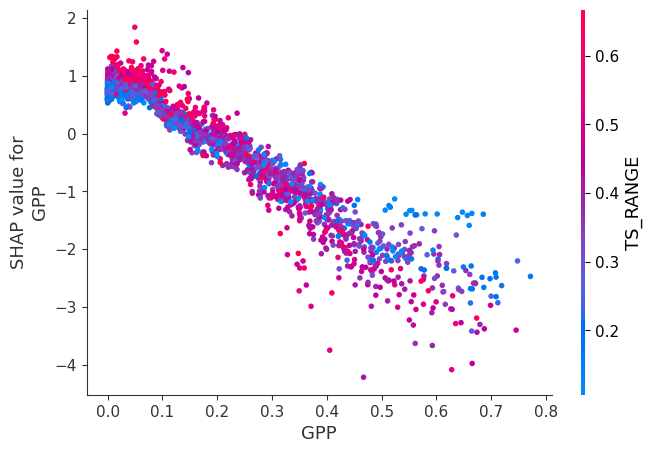

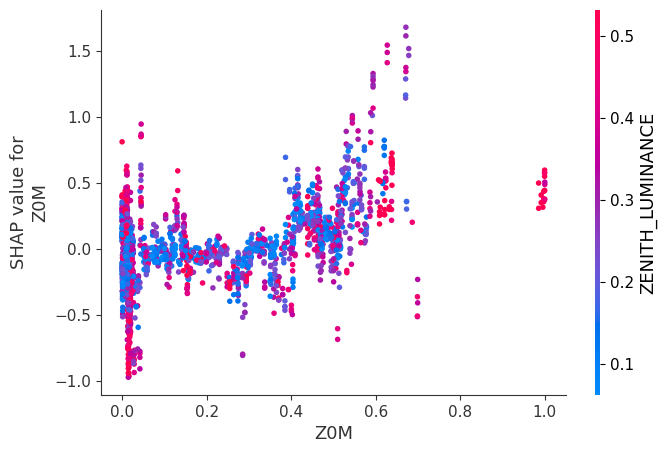

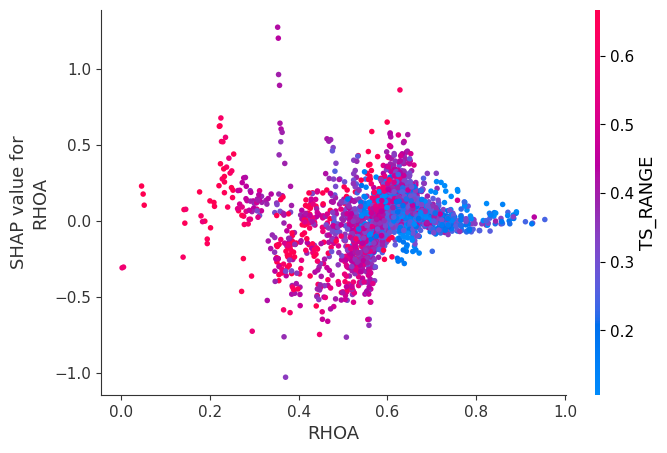

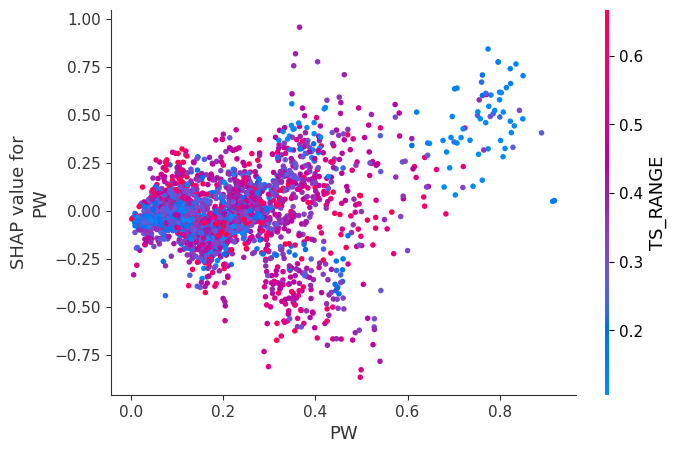

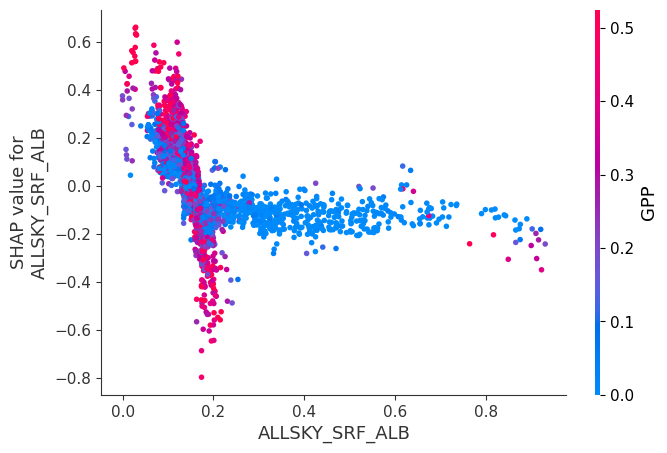

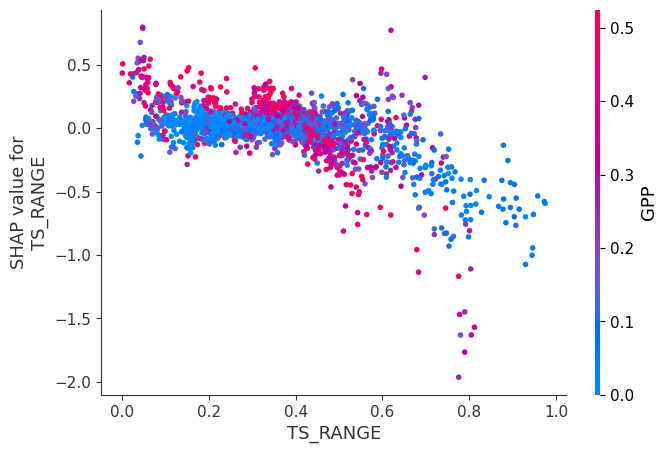

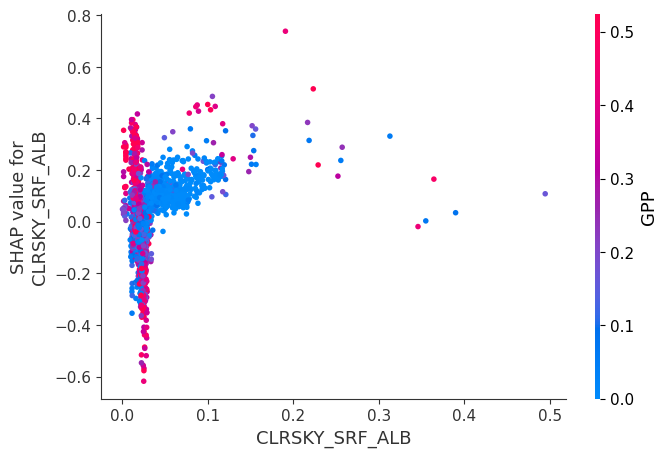

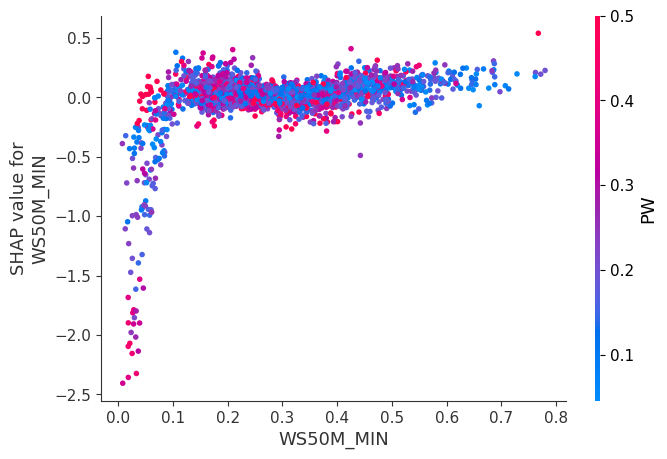

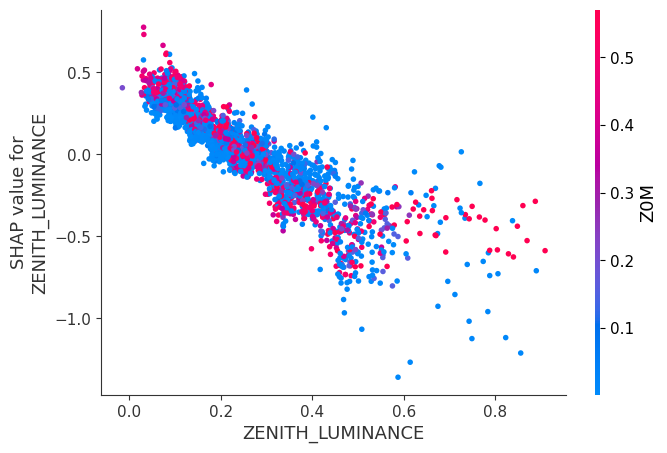

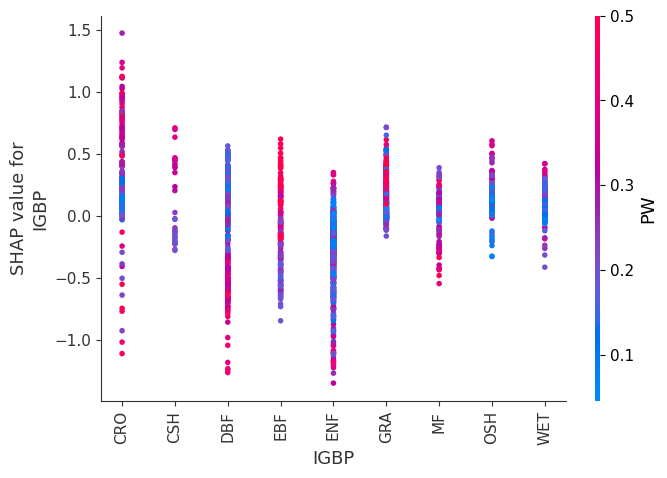

In [21]:
for feature in X_test_scaled.columns:
    shap.dependence_plot(feature, shap_values, X_test_scaled)
    plt.show()

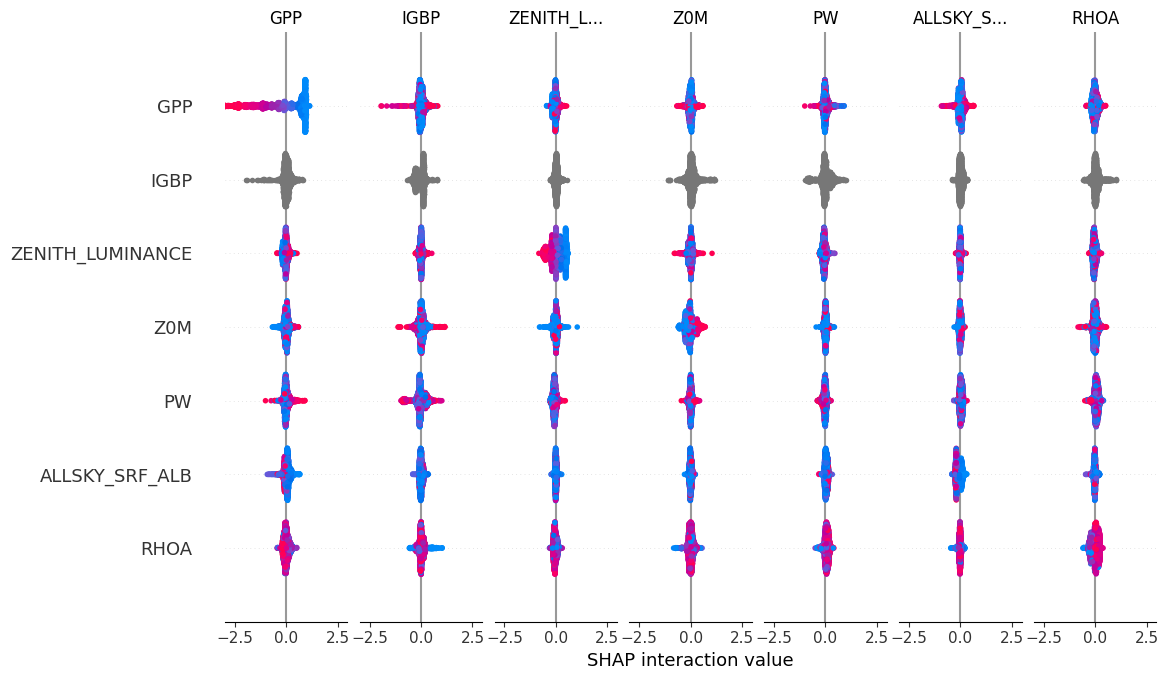

In [15]:
shap_interaction_values = explainer.shap_interaction_values(X_test_scaled)
shap.summary_plot(shap_interaction_values, X_test_scaled)

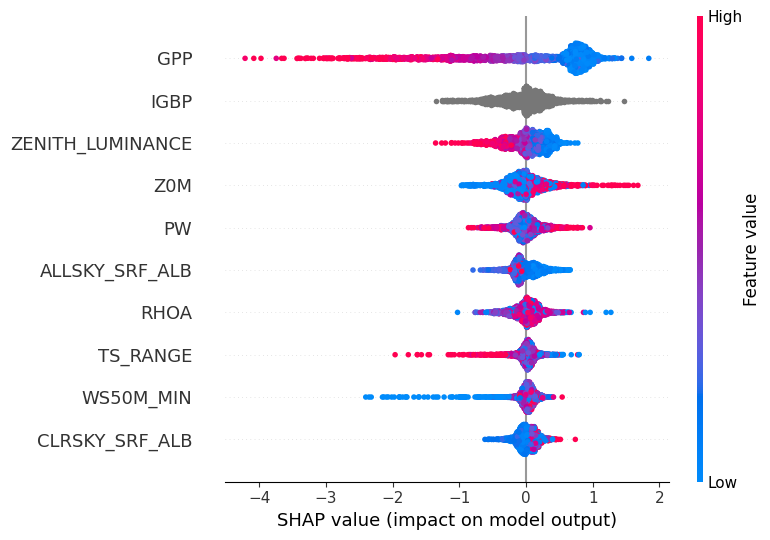

In [17]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="dot")

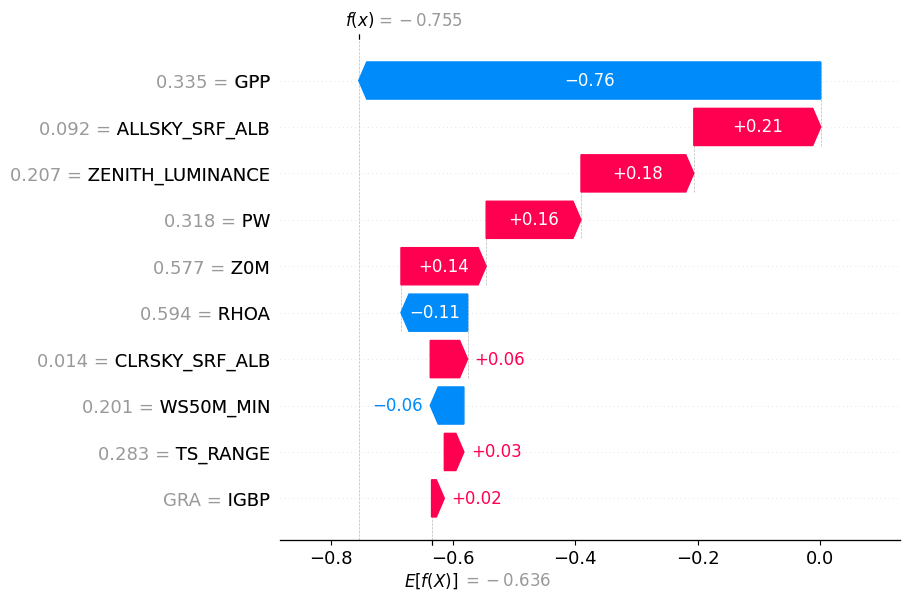

In [9]:
# Plot the SHAP values for a single prediction
shap.plots.waterfall(shap_values[10])

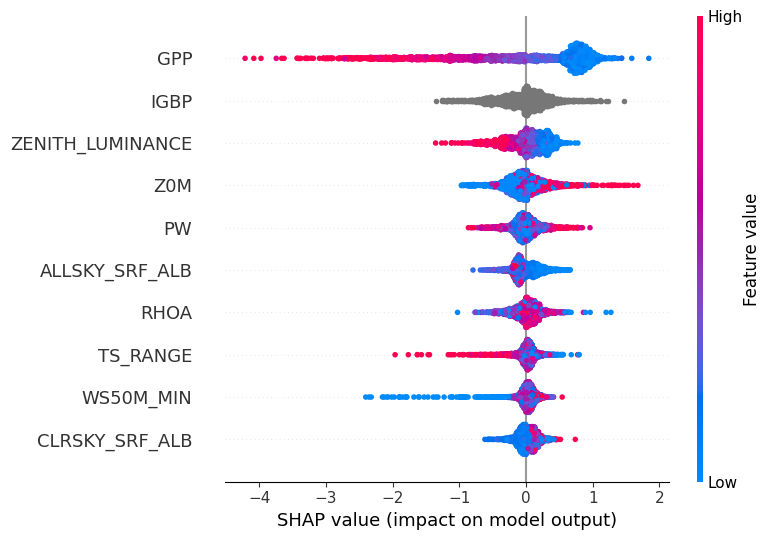

In [11]:
# Plot the summary of SHAP values for the entire test set
shap.summary_plot(shap_values, X_test_scaled)

In [22]:
shap.plots.force(shap_values[0, ...])

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [35]:
shap.plots.force(shap_values)

# PICP

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, Pool
import numpy as np

# Features to drop
features_to_drop = ['NEE']
X = cleaned_df.drop(features_to_drop, axis=1)
y = cleaned_df['NEE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the categorical features
categorical_features = ['IGBP']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Separate categorical and numerical features
X_train_num = X_train.drop(columns=categorical_features)
X_test_num = X_test.drop(columns=categorical_features)

# Fit the scaler on the numerical training data and transform both training and testing numerical data
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert scaled numerical data back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Concatenate scaled numerical data with categorical data
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[categorical_features]], axis=1)

# Create Pool objects for training and testing
train_pool = Pool(data=X_train_scaled, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test_scaled, label=y_test, cat_features=categorical_features)

# Train models for different quantiles
quantiles = [0.05, 0.95]
models = {}

for quantile in quantiles:
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100, loss_function='Quantile:alpha={}'.format(quantile))
    model.fit(train_pool)
    models[quantile] = model

# Make quantile predictions
predictions_lower = models[0.05].predict(test_pool)
predictions_upper = models[0.95].predict(test_pool)

# Calculate PICP
def calculate_picp(y_true, y_lower, y_upper):
    within_interval = np.logical_and(y_true >= y_lower, y_true <= y_upper)
    picp = np.mean(within_interval)
    return picp

picp = calculate_picp(y_test, predictions_lower, predictions_upper)
print(f'PICP: {picp}')

In other words, if you constructed prediction intervals such that you expect them to capture 90% of future observations (e.g., between the 5th and 95th percentiles), but your PICP is 0.8325, it indicates that only 83.25% of the actual observations are within these intervals. This might suggest that your prediction intervals are slightly narrower than desired, or that your model's uncertainty estimation is not perfectly aligned with the actual variability in the data.


To interpret this result:


If your target coverage was 90%, a PICP of 0.8325 suggests that your intervals are not capturing as many observations as expected, and you might need to adjust your model or interval estimation method.
If your target coverage was 80%, a PICP of 0.8325 indicates that your intervals are performing better than expected, capturing more observations than the target.

In general, the closer the PICP is to your desired coverage probability, the better your prediction intervals are performing.
